# Your first neural network

In this project, you'll build your first neural network and use it to predict daily bike rental ridership. We've provided some of the code, but left the implementation of the neural network up to you (for the most part). After you've submitted this project, feel free to explore the data and the model more.



In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load and prepare the data

A critical step in working with neural networks is preparing the data correctly. Variables on different scales make it difficult for the network to efficiently learn the correct weights. Below, we've written the code to load and prepare the data. You'll learn more about this soon!

In [2]:
data_path = 'Bike-Sharing-Dataset/hour.csv'

rides = pd.read_csv(data_path)

In [3]:
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Checking out the data

This dataset has the number of riders for each hour of each day from January 1 2011 to December 31 2012. The number of riders is split between casual and registered, summed up in the `cnt` column. You can see the first few rows of the data above.

Below is a plot showing the number of bike riders over the first 10 days or so in the data set. (Some days don't have exactly 24 entries in the data set, so it's not exactly 10 days.) You can see the hourly rentals here. This data is pretty complicated! The weekends have lower over all ridership and there are spikes when people are biking to and from work during the week. Looking at the data above, we also have information about temperature, humidity, and windspeed, all of these likely affecting the number of riders. You'll be trying to capture all this with your model.

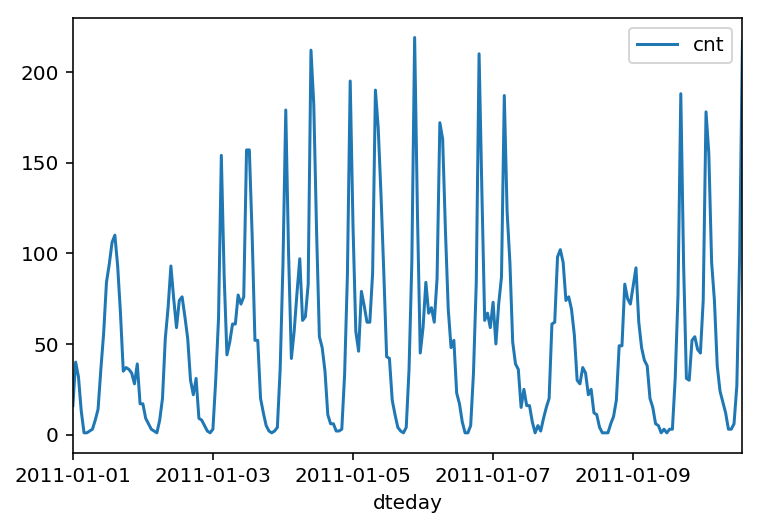

In [4]:
rides[:24*10].plot(x='dteday', y='cnt')

### Dummy variables
Here we have some categorical variables like season, weather, month. To include these in our model, we'll need to make binary dummy variables. This is simple to do with Pandas thanks to `get_dummies()`.

In [5]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


### Scaling target variables
To make training the network easier, we'll standardize each of the continuous variables. That is, we'll shift and scale the variables such that they have zero mean and a standard deviation of 1.

The scaling factors are saved so we can go backwards when we use the network for predictions.

In [6]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

### Splitting the data into training, testing, and validation sets

We'll save the data for the last approximately 21 days to use as a test set after we've trained the network. We'll use this set to make predictions and compare them with the actual number of riders.

In [7]:
# Save data for approximately the last 21 days 
test_data = data[-21*24:]

# Now remove the test data from the data set 
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

We'll split the data into two sets, one for training and one for validating as the network is being trained. Since this is time series data, we'll train on historical data, then try to predict on future data (the validation set).

In [8]:
# Hold out the last 60 days or so of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

## Time to build the network

Below you'll build your network. We've built out the structure and the backwards pass. You'll implement the forward pass through the network. You'll also set the hyperparameters: the learning rate, the number of hidden units, and the number of training passes.

<img src="assets/neural_network.png" width=300px>

The network has two layers, a hidden layer and an output layer. The hidden layer will use the sigmoid function for activations. The output layer has only one node and is used for the regression, the output of the node is the same as the input of the node. That is, the activation function is $f(x)=x$. A function that takes the input signal and generates an output signal, but takes into account the threshold, is called an activation function. We work through each layer of our network calculating the outputs for each neuron. All of the outputs from one layer become inputs to the neurons on the next layer. This process is called *forward propagation*.

We use the weights to propagate signals forward from the input to the output layers in a neural network. We use the weights to also propagate error backwards from the output back into the network to update our weights. This is called *backpropagation*.

> **Hint:** You'll need the derivative of the output activation function ($f(x) = x$) for the backpropagation implementation. If you aren't familiar with calculus, this function is equivalent to the equation $y = x$. What is the slope of that equation? That is the derivative of $f(x)$.

Below, you have these tasks:
1. Implement the sigmoid function to use as the activation function. Set `self.activation_function` in `__init__` to your sigmoid function.
2. Implement the forward pass in the `train` method.
3. Implement the backpropagation algorithm in the `train` method, including calculating the output error.
4. Implement the forward pass in the `run` method.
  

In [9]:
#############
# In the my_answers.py file, fill out the TODO sections as specified
#############

from my_answers import NeuralNetwork

In [10]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

## Unit tests

Run these unit tests to check the correctness of your network implementation. This will help you be sure your network was implemented correctly befor you starting trying to train it. These tests must all be successful to pass the project.

In [16]:
import unittest

inputs = np.array([[0.5, -0.2, 0.1]])
targets = np.array([[0.4]])
test_w_i_h = np.array([[0.1, -0.2],
                       [0.4, 0.5],
                       [-0.3, 0.2]])
test_w_h_o = np.array([[0.3],
                       [-0.1]])

class TestMethods(unittest.TestCase):
    
    ##########
    # Unit tests for data loading
    ##########
    
    def test_data_path(self):
        # Test that file path to dataset has been unaltered
        self.assertTrue(data_path.lower() == 'bike-sharing-dataset/hour.csv')
        
    def test_data_loaded(self):
        # Test that data frame loaded
        self.assertTrue(isinstance(rides, pd.DataFrame))
    
    ##########
    # Unit tests for network functionality
    ##########

    def test_activation(self):
        network = NeuralNetwork(3, 2, 1, 0.5)
        # Test that the activation function is a sigmoid
        self.assertTrue(np.all(network.activation_function(0.5) == 1/(1+np.exp(-0.5))))

    def test_train(self):
        # Test that weights are updated correctly on training
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()
        
        network.train(inputs, targets)
       
        self.assertTrue(np.allclose(network.weights_hidden_to_output, 
                                    np.array([[ 0.37275328], 
                                              [-0.03172939]])))
        self.assertTrue(np.allclose(network.weights_input_to_hidden,
                                    np.array([[ 0.10562014, -0.20185996], 
                                              [0.39775194, 0.50074398], 
                                              [-0.29887597, 0.19962801]])))

    def test_run(self):
        # Test correctness of run method
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()

        self.assertTrue(np.allclose(network.run(inputs), 0.09998924))

suite = unittest.TestLoader().loadTestsFromModule(TestMethods())
unittest.TextTestRunner().run(suite)

....F

[[ 0.10001012 -0.20000335]
 [ 0.39999595  0.50000134]
 [-0.29999798  0.19999933]]



FAIL: test_train (__main__.TestMethods)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-16-27329c4807b2>", line 44, in test_train
    [-0.03172939]])))
AssertionError: False is not true

----------------------------------------------------------------------
Ran 5 tests in 0.007s

FAILED (failures=1)


<unittest.runner.TextTestResult run=5 errors=0 failures=1>

## Training the network

Here you'll set the hyperparameters for the network. The strategy here is to find hyperparameters such that the error on the training set is low, but you're not overfitting to the data. If you train the network too long or have too many hidden nodes, it can become overly specific to the training set and will fail to generalize to the validation set. That is, the loss on the validation set will start increasing as the training set loss drops.

You'll also be using a method know as Stochastic Gradient Descent (SGD) to train the network. The idea is that for each training pass, you grab a random sample of the data instead of using the whole data set. You use many more training passes than with normal gradient descent, but each pass is much faster. This ends up training the network more efficiently. You'll learn more about SGD later.

### Choose the number of iterations
This is the number of batches of samples from the training data we'll use to train the network. The more iterations you use, the better the model will fit the data. However, this process can have sharply diminishing returns and can waste computational resources if you use too many iterations.  You want to find a number here where the network has a low training loss, and the validation loss is at a minimum. The ideal number of iterations would be a level that stops shortly after the validation loss is no longer decreasing.

### Choose the learning rate
This scales the size of weight updates. If this is too big, the weights tend to explode and the network fails to fit the data. Normally a good choice to start at is 0.1; however, if you effectively divide the learning rate by n_records, try starting out with a learning rate of 1. In either case, if the network has problems fitting the data, try reducing the learning rate. Note that the lower the learning rate, the smaller the steps are in the weight updates and the longer it takes for the neural network to converge.

### Choose the number of hidden nodes
In a model where all the weights are optimized, the more hidden nodes you have, the more accurate the predictions of the model will be.  (A fully optimized model could have weights of zero, after all.) However, the more hidden nodes you have, the harder it will be to optimize the weights of the model, and the more likely it will be that suboptimal weights will lead to overfitting. With overfitting, the model will memorize the training data instead of learning the true pattern, and won't generalize well to unseen data.  

Try a few different numbers and see how it affects the performance. You can look at the losses dictionary for a metric of the network performance. If the number of hidden units is too low, then the model won't have enough space to learn and if it is too high there are too many options for the direction that the learning can take. The trick here is to find the right balance in number of hidden units you choose.  You'll generally find that the best number of hidden nodes to use ends up being between the number of input and output nodes.

In [12]:
import sys

####################
### Set the hyperparameters in you myanswers.py file ###
####################

from my_answers import iterations, learning_rate, hidden_nodes, output_nodes


N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for ii in range(iterations):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    X, y = train_features.ix[batch].values, train_targets.ix[batch]['cnt']
                             
    network.train(X, y)
    
    # Printing out the training progress
    train_loss = MSE(network.run(train_features).T, train_targets['cnt'].values)
    val_loss = MSE(network.run(val_features).T, val_targets['cnt'].values)
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

/home/victor-hotmart/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


o-term:  [-0.18431808]
hidden_outputs:  [ 0.26407945  0.41390905]
delta:  [[-0.04867462]
 [-0.07629092]]
o-term:  [ 0.03901476]
hidden_outputs:  [ 0.40760431  0.45888881]
delta:  [[-0.03277203]
 [-0.05838748]]
o-term:  [-0.00545621]
hidden_outputs:  [ 0.44378588  0.49544366]
delta:  [[-0.03519342]
 [-0.06109073]]
o-term:  [-0.00684143]
hidden_outputs:  [ 0.37974907  0.51134566]
delta:  [[-0.03779145]
 [-0.06458906]]
o-term:  [-0.07747773]
hidden_outputs:  [ 0.34323537  0.59793944]
delta:  [[-0.06438454]
 [-0.11091605]]
o-term:  [-0.03133808]
hidden_outputs:  [ 0.45250833  0.5166775 ]
delta:  [[-0.07856529]
 [-0.12710773]]
o-term:  [-0.10039384]
hidden_outputs:  [ 0.35386451  0.60608045]
delta:  [[-0.1140911 ]
 [-0.18795448]]
o-term:  [-0.07398908]
hidden_outputs:  [ 0.39091346  0.60786232]
delta:  [[-0.14301443]
 [-0.23292965]]
o-term:  [ 0.06171238]
hidden_outputs:  [ 0.43484357  0.53826671]
delta:  [[-0.1161792 ]
 [-0.19971193]]
o-term:  [-0.04708239]
hidden_outputs:  [ 0.50890364  0

Progress: 0.0% ... Training loss: 0.984 ... Validation loss: 1.423o-term:  [ 0.02165245]
hidden_outputs:  [ 0.52295654  0.63740448]
delta:  [[ 0.01132329]
 [ 0.01380137]]
o-term:  [-0.17231662]
hidden_outputs:  [ 0.45757774  0.53385646]
delta:  [[-0.06752496]
 [-0.07819097]]
o-term:  [-0.08252108]
hidden_outputs:  [ 0.35245048  0.48701925]
delta:  [[-0.09660955]
 [-0.11838033]]
o-term:  [ 0.07870415]
hidden_outputs:  [ 0.42868139  0.68044983]
delta:  [[-0.06287055]
 [-0.0648261 ]]
o-term:  [ 0.0560073]
hidden_outputs:  [ 0.38139461  0.41507186]
delta:  [[-0.04150966]
 [-0.04157904]]
o-term:  [-0.01230137]
hidden_outputs:  [ 0.43402594  0.54605259]
delta:  [[-0.04684878]
 [-0.04829624]]
o-term:  [-0.0284454]
hidden_outputs:  [ 0.4894291   0.63886961]
delta:  [[-0.06077078]
 [-0.06646914]]
o-term:  [ 0.04267777]
hidden_outputs:  [ 0.43000308  0.5761311 ]
delta:  [[-0.04241921]
 [-0.04188115]]
o-term:  [ 0.01837349]
hidden_outputs:  [ 0.49248291  0.6334635 ]
delta:  [[-0.03337058]
 [-0.03

hidden_outputs:  [ 0.41853676  0.6220061 ]
delta:  [[-0.32131762]
 [-0.71630152]]
o-term:  [ 0.04325147]
hidden_outputs:  [ 0.46208918  0.47001107]
delta:  [[-0.30133158]
 [-0.69597285]]
o-term:  [-0.02720823]
hidden_outputs:  [ 0.36599826  0.47946173]
delta:  [[-0.31128975]
 [-0.70901816]]
o-term:  [ 0.05167877]
hidden_outputs:  [ 0.51087014  0.46645881]
delta:  [[-0.28488861]
 [-0.68491214]]
o-term:  [ 0.0901296]
hidden_outputs:  [ 0.40420231  0.63532757]
delta:  [[-0.24845801]
 [-0.62765032]]
o-term:  [ 0.08538857]
hidden_outputs:  [ 0.50834238  0.51828327]
delta:  [[-0.20505138]
 [-0.58339485]]
o-term:  [ 0.04083172]
hidden_outputs:  [ 0.44889586  0.51843787]
delta:  [[-0.18672219]
 [-0.56222614]]
o-term:  [-0.25003446]
hidden_outputs:  [ 0.45125458  0.61676209]
delta:  [[-0.29955139]
 [-0.71643792]]
o-term:  [ 0.05375252]
hidden_outputs:  [ 0.50119759  0.63407617]
delta:  [[-0.27261076]
 [-0.68235473]]
o-term:  [ 0.02895991]
hidden_outputs:  [ 0.45898054  0.43748595]
delta:  [[-0.

o-term:  [-0.06084919]
hidden_outputs:  [ 0.54594133  0.49748553]
delta:  [[-0.24969226]
 [-0.53565631]]
o-term:  [ 0.09301949]
hidden_outputs:  [ 0.44930284  0.58848989]
delta:  [[-0.20789834]
 [-0.48091528]]
o-term:  [ 0.0962571]
hidden_outputs:  [ 0.36771345  0.55166829]
delta:  [[-0.17250331]
 [-0.42781329]]
o-term:  [ 0.01008858]
hidden_outputs:  [ 0.46055518  0.55201222]
delta:  [[-0.16785697]
 [-0.42224428]]
o-term:  [ 0.0604676]
hidden_outputs:  [ 0.44111455  0.66246163]
delta:  [[-0.14118383]
 [-0.38218681]]
o-term:  [ 0.05040725]
hidden_outputs:  [ 0.48023671  0.53077448]
delta:  [[-0.11697642]
 [-0.35543193]]
o-term:  [ 0.07747872]
hidden_outputs:  [ 0.43031726  0.45796151]
delta:  [[-0.08363599]
 [-0.31994966]]
o-term:  [-0.01414856]
hidden_outputs:  [ 0.48671207  0.48446236]
delta:  [[-0.09052226]
 [-0.3268041 ]]
o-term:  [ 0.04605818]
hidden_outputs:  [ 0.4143088   0.44316494]
delta:  [[-0.07143996]
 [-0.30639274]]
o-term:  [-0.46770828]
hidden_outputs:  [ 0.42263897  0.5

delta:  [[ 0.12112316]
 [ 0.0744449 ]]
o-term:  [ 0.05489968]
hidden_outputs:  [ 0.28765742  0.4948916 ]
delta:  [[ 0.13691546]
 [ 0.10161429]]
o-term:  [ 0.03675126]
hidden_outputs:  [ 0.42025195  0.55263609]
delta:  [[ 0.15236025]
 [ 0.12192436]]
o-term:  [ 0.03070501]
hidden_outputs:  [ 0.40918117  0.59342846]
delta:  [[ 0.16492416]
 [ 0.14014559]]
o-term:  [ 0.02506361]
hidden_outputs:  [ 0.34589604  0.38163622]
delta:  [[ 0.17359357]
 [ 0.14971078]]
o-term:  [ 0.10916684]
hidden_outputs:  [ 0.34323443  0.58744563]
delta:  [[ 0.21106339]
 [ 0.21384036]]
o-term:  [ 0.05860398]
hidden_outputs:  [ 0.37556651  0.56796148]
delta:  [[ 0.23307308]
 [ 0.24712516]]
o-term:  [ 0.04586795]
hidden_outputs:  [ 0.2880327   0.54116894]
delta:  [[ 0.24628455]
 [ 0.27194747]]
o-term:  [-0.20543674]
hidden_outputs:  [ 0.40293189  0.53522117]
delta:  [[ 0.16350753]
 [ 0.16199338]]
o-term:  [-0.05074566]
hidden_outputs:  [ 0.3753833   0.48952733]
delta:  [[ 0.14445846]
 [ 0.13715199]]
o-term:  [-0.027

Progress: 3.0% ... Training loss: 0.984 ... Validation loss: 1.424o-term:  [ 0.0773293]
hidden_outputs:  [ 0.46811899  0.51920696]
delta:  [[ 0.03619931]
 [ 0.04014991]]
o-term:  [-0.01584479]
hidden_outputs:  [ 0.54652168  0.68875392]
delta:  [[ 0.0275398 ]
 [ 0.02923675]]
o-term:  [-0.31631173]
hidden_outputs:  [ 0.3298383   0.64767393]
delta:  [[-0.07679193]
 [-0.17563011]]
o-term:  [-0.0517731]
hidden_outputs:  [ 0.39665724  0.57068506]
delta:  [[-0.0973281 ]
 [-0.20517624]]
o-term:  [ 0.07274263]
hidden_outputs:  [ 0.40588914  0.43085777]
delta:  [[-0.06780266]
 [-0.17383451]]
o-term:  [-0.13835852]
hidden_outputs:  [ 0.37364129  0.69046185]
delta:  [[-0.11949912]
 [-0.2693658 ]]
o-term:  [-0.01995613]
hidden_outputs:  [ 0.34914921  0.60726062]
delta:  [[-0.12646678]
 [-0.28148437]]
o-term:  [ 0.09648657]
hidden_outputs:  [ 0.43015373  0.68304393]
delta:  [[-0.08496273]
 [-0.2155798 ]]
o-term:  [-0.1514392]
hidden_outputs:  [ 0.33407419  0.61814902]
delta:  [[-0.13555465]
 [-0.309

Progress: 4.0% ... Training loss: 0.984 ... Validation loss: 1.424o-term:  [ 0.09375491]
hidden_outputs:  [ 0.48071667  0.57017391]
delta:  [[ 0.04506955]
 [ 0.05345661]]
o-term:  [ 0.04840535]
hidden_outputs:  [ 0.48267693  0.54575718]
delta:  [[ 0.0684337 ]
 [ 0.07987417]]
o-term:  [ 0.01453665]
hidden_outputs:  [ 0.41447505  0.51950112]
delta:  [[ 0.07445877]
 [ 0.08742598]]
o-term:  [ 0.04087742]
hidden_outputs:  [ 0.45812658  0.51528851]
delta:  [[ 0.0931858 ]
 [ 0.10848964]]
o-term:  [ 0.00030118]
hidden_outputs:  [ 0.47529274  0.55251729]
delta:  [[ 0.09332895]
 [ 0.10865605]]
o-term:  [ 0.01929164]
hidden_outputs:  [ 0.52052526  0.59974579]
delta:  [[ 0.10337074]
 [ 0.12022613]]
o-term:  [ 0.09455712]
hidden_outputs:  [ 0.4467678   0.54638347]
delta:  [[ 0.14561581]
 [ 0.17189057]]
o-term:  [-0.05806996]
hidden_outputs:  [ 0.44374096  0.45899196]
delta:  [[ 0.1198478 ]
 [ 0.14523693]]
o-term:  [ 0.08051112]
hidden_outputs:  [ 0.40259145  0.47449207]
delta:  [[ 0.15226089]
 [ 0.

o-term:  [-0.07071768]
hidden_outputs:  [ 0.51021231  0.53863086]
delta:  [[ 0.42560947]
 [ 0.45664426]]
o-term:  [ 0.05543636]
hidden_outputs:  [ 0.51789222  0.58044736]
delta:  [[ 0.45431953]
 [ 0.48882215]]
o-term:  [-0.00433114]
hidden_outputs:  [ 0.38833207  0.35761418]
delta:  [[ 0.45263761]
 [ 0.48727327]]
o-term:  [ 0.0607069]
hidden_outputs:  [ 0.43555136  0.39062643]
delta:  [[ 0.47907858]
 [ 0.51098699]]
o-term:  [-0.12332664]
hidden_outputs:  [ 0.36883868  0.68444118]
delta:  [[ 0.43359095]
 [ 0.42657716]]
o-term:  [-0.04982581]
hidden_outputs:  [ 0.44449553  0.46196407]
delta:  [[ 0.4114436 ]
 [ 0.40355943]]
o-term:  [-0.02753073]
hidden_outputs:  [ 0.41204356  0.4653795 ]
delta:  [[ 0.40009974]
 [ 0.39074719]]
o-term:  [-0.06195864]
hidden_outputs:  [ 0.45457872  0.56053923]
delta:  [[ 0.37193466]
 [ 0.35601694]]
o-term:  [ 0.11746128]
hidden_outputs:  [ 0.59314973  0.71572714]
delta:  [[ 0.44160679]
 [ 0.44008717]]
o-term:  [ 0.01281822]
hidden_outputs:  [ 0.44059741  0.

 [ 0.16003158]]
o-term:  [-0.10637055]
hidden_outputs:  [ 0.34559737  0.40991057]
delta:  [[ 0.12482323]
 [ 0.11642916]]
o-term:  [-0.00295515]
hidden_outputs:  [ 0.41485072  0.52949074]
delta:  [[ 0.12359728]
 [ 0.11486444]]
o-term:  [ 0.07497783]
hidden_outputs:  [ 0.42808989  0.43822334]
delta:  [[ 0.15569453]
 [ 0.14772147]]
o-term:  [ 0.09184664]
hidden_outputs:  [ 0.51797083  0.57445473]
delta:  [[ 0.20326841]
 [ 0.20048321]]
o-term:  [-0.38071638]
hidden_outputs:  [ 0.41882055  0.60023681]
delta:  [[ 0.04381657]
 [-0.02803677]]
o-term:  [ 0.09710651]
hidden_outputs:  [ 0.42436784  0.54714064]
delta:  [[ 0.08502545]
 [ 0.02509414]]
o-term:  [ 0.07804199]
hidden_outputs:  [ 0.41009179  0.47964121]
delta:  [[ 0.11702983]
 [ 0.0625263 ]]
o-term:  [-0.21204385]
hidden_outputs:  [ 0.44203023  0.57288104]
delta:  [[ 0.02330003]
 [-0.0589496 ]]
o-term:  [-0.00047624]
hidden_outputs:  [ 0.43784737  0.50755074]
delta:  [[ 0.02309151]
 [-0.05919132]]
o-term:  [-0.10319302]
hidden_outputs: 

Progress: 6.0% ... Training loss: 0.985 ... Validation loss: 1.424o-term:  [-0.33037723]
hidden_outputs:  [ 0.38323053  0.48404833]
delta:  [[-0.12661064]
 [-0.15991855]]
o-term:  [-0.02469011]
hidden_outputs:  [ 0.43146104  0.32946078]
delta:  [[-0.13726346]
 [-0.16805297]]
o-term:  [ 0.08264074]
hidden_outputs:  [ 0.49834564  0.49778181]
delta:  [[-0.09607981]
 [-0.12691591]]
o-term:  [ 0.02680228]
hidden_outputs:  [ 0.50076283  0.64438281]
delta:  [[-0.08265822]
 [-0.10964498]]
o-term:  [-0.06452888]
hidden_outputs:  [ 0.52288877  0.5912054 ]
delta:  [[-0.11639965]
 [-0.14779481]]
o-term:  [-0.04725421]
hidden_outputs:  [ 0.46659871  0.69923881]
delta:  [[-0.1384484 ]
 [-0.18083678]]
o-term:  [ 0.07194624]
hidden_outputs:  [ 0.52421245  0.68539192]
delta:  [[-0.10073328]
 [-0.13152541]]
o-term:  [ 0.09074815]
hidden_outputs:  [ 0.49801745  0.54187992]
delta:  [[-0.05553912]
 [-0.08235081]]
o-term:  [ 0.00998632]
hidden_outputs:  [ 0.48802444  0.58306598]
delta:  [[-0.05066555]
 [-0.

delta:  [[ 0.1089422 ]
 [ 0.07594346]]
o-term:  [ 0.1002614]
hidden_outputs:  [ 0.48372559  0.57317057]
delta:  [[ 0.1574412 ]
 [ 0.13341034]]
o-term:  [-0.05922298]
hidden_outputs:  [ 0.55499194  0.5834463 ]
delta:  [[ 0.12457292]
 [ 0.09885691]]
o-term:  [ 0.00912847]
hidden_outputs:  [ 0.60366857  0.64486408]
delta:  [[ 0.13008349]
 [ 0.10474353]]
o-term:  [ 0.04540635]
hidden_outputs:  [ 0.45079684  0.52161587]
delta:  [[ 0.15055253]
 [ 0.12842821]]
o-term:  [ 0.02525744]
hidden_outputs:  [ 0.34589613  0.38164945]
delta:  [[ 0.15928899]
 [ 0.1380677 ]]
o-term:  [-0.18290581]
hidden_outputs:  [ 0.32718787  0.54270536]
delta:  [[ 0.09944442]
 [ 0.03880373]]
o-term:  [ 0.02846213]
hidden_outputs:  [ 0.46034753  0.43633743]
delta:  [[ 0.11254689]
 [ 0.05122282]]
o-term:  [ 0.09780014]
hidden_outputs:  [ 0.5331105   0.58717709]
delta:  [[ 0.16468517]
 [ 0.10864882]]
o-term:  [ 0.06995587]
hidden_outputs:  [ 0.33834851  0.58037726]
delta:  [[ 0.18835464]
 [ 0.14924962]]
o-term:  [-0.0528

delta:  [[-0.15007477]
 [-0.20633245]]
o-term:  [-0.09058307]
hidden_outputs:  [ 0.4297313   0.53958572]
delta:  [[-0.18900115]
 [-0.25520978]]
o-term:  [-0.2074536]
hidden_outputs:  [ 0.40263757  0.53630834]
delta:  [[-0.27252976]
 [-0.36646888]]
o-term:  [-0.13109548]
hidden_outputs:  [ 0.45850922  0.45656043]
delta:  [[-0.33263825]
 [-0.42632188]]
o-term:  [-0.01384953]
hidden_outputs:  [ 0.43582242  0.51902792]
delta:  [[-0.33867418]
 [-0.43351018]]
o-term:  [ 0.08380816]
hidden_outputs:  [ 0.56789541  0.52933449]
delta:  [[-0.29107991]
 [-0.38914763]]
o-term:  [-0.25112237]
hidden_outputs:  [ 0.32187274  0.49939495]
delta:  [[-0.37190936]
 [-0.51455687]]
o-term:  [-0.02123717]
hidden_outputs:  [ 0.43911136  0.47896132]
delta:  [[-0.38123484]
 [-0.52472865]]
o-term:  [ 0.06172919]
hidden_outputs:  [ 0.32689974  0.51822529]
delta:  [[-0.36105559]
 [-0.49273903]]
o-term:  [-0.1606286]
hidden_outputs:  [ 0.41976912  0.5740245 ]
delta:  [[-0.42848251]
 [-0.58494378]]
o-term:  [-0.03279

o-term:  [ 0.06342753]
hidden_outputs:  [ 0.41685743  0.46671608]
delta:  [[-0.21490301]
 [-0.37362302]]
o-term:  [ 0.00309439]
hidden_outputs:  [ 0.48872522  0.49416199]
delta:  [[-0.21339071]
 [-0.37209389]]
o-term:  [-0.17598753]
hidden_outputs:  [ 0.37096407  0.58550014]
delta:  [[-0.27867575]
 [-0.47513461]]
o-term:  [ 0.0674642]
hidden_outputs:  [ 0.47866981  0.60947184]
delta:  [[-0.24638268]
 [-0.43401708]]
o-term:  [ 0.02624217]
hidden_outputs:  [ 0.54764258  0.51223125]
delta:  [[-0.23201135]
 [-0.42057502]]
o-term:  [-0.01342274]
hidden_outputs:  [ 0.48401696  0.45939764]
delta:  [[-0.23850818]
 [-0.4267414 ]]
o-term:  [-0.01305314]
hidden_outputs:  [ 0.49109334  0.59957029]
delta:  [[-0.24491849]
 [-0.43456767]]
o-term:  [-0.06418978]
hidden_outputs:  [ 0.3127137   0.41642043]
delta:  [[-0.26499151]
 [-0.4612976 ]]
o-term:  [ 0.01667735]
hidden_outputs:  [ 0.50077101  0.49085866]
delta:  [[-0.25663998]
 [-0.45311138]]
o-term:  [ 0.02927432]
hidden_outputs:  [ 0.4099685   0.

Progress: 9.0% ... Training loss: 0.985 ... Validation loss: 1.425o-term:  [-0.26264709]
hidden_outputs:  [ 0.29065574  0.61675391]
delta:  [[-0.07633989]
 [-0.16198862]]
o-term:  [-0.10352427]
hidden_outputs:  [ 0.46140605  0.54560479]
delta:  [[-0.12410661]
 [-0.21847196]]
o-term:  [ 0.11355375]
hidden_outputs:  [ 0.39687137  0.68630621]
delta:  [[-0.07904038]
 [-0.14053931]]
o-term:  [ 0.01434318]
hidden_outputs:  [ 0.38981106  0.59809688]
delta:  [[-0.07344925]
 [-0.1319607 ]]
o-term:  [-0.01646705]
hidden_outputs:  [ 0.36602045  0.32839124]
delta:  [[-0.07947653]
 [-0.13736834]]
o-term:  [-0.05747936]
hidden_outputs:  [ 0.48903712  0.44012587]
delta:  [[-0.10758607]
 [-0.16266649]]
o-term:  [ 0.04764397]
hidden_outputs:  [ 0.47929628  0.47967819]
delta:  [[-0.08475049]
 [-0.13981272]]
o-term:  [-0.10090652]
hidden_outputs:  [ 0.40979722  0.44530995]
delta:  [[-0.1261017]
 [-0.1847474]]
o-term:  [ 0.07568329]
hidden_outputs:  [ 0.42678624  0.46635449]
delta:  [[-0.09380112]
 [-0.14

o-term:  [ 0.06394605]
hidden_outputs:  [ 0.4818983   0.40748394]
delta:  [[-0.1523891 ]
 [-0.44051032]]
o-term:  [ 0.07794519]
hidden_outputs:  [ 0.39427947  0.56901094]
delta:  [[-0.12165691]
 [-0.39615866]]
o-term:  [ 0.10106007]
hidden_outputs:  [ 0.46958526  0.59167377]
delta:  [[-0.07420059]
 [-0.33636406]]
o-term:  [ 0.10933147]
hidden_outputs:  [ 0.54004937  0.64823472]
delta:  [[-0.0151562]
 [-0.2654916]]
o-term:  [ 0.03591751]
hidden_outputs:  [ 0.40576318  0.59951095]
delta:  [[-0.00058219]
 [-0.24395866]]
o-term:  [-0.30658503]
hidden_outputs:  [ 0.48544473  0.60481233]
delta:  [[-0.14941228]
 [-0.42938507]]
o-term:  [-0.0165526]
hidden_outputs:  [ 0.44238934  0.62944215]
delta:  [[-0.15673497]
 [-0.43980397]]
o-term:  [ 0.00640365]
hidden_outputs:  [ 0.5034666   0.51998956]
delta:  [[-0.15351095]
 [-0.43647414]]
o-term:  [-0.01676615]
hidden_outputs:  [ 0.38620527  0.4803966 ]
delta:  [[-0.15998612]
 [-0.44452854]]
o-term:  [ 0.09535976]
hidden_outputs:  [ 0.4959543   0.55

hidden_outputs:  [ 0.4722294   0.71313566]
delta:  [[-0.56866768]
 [-0.79028575]]
o-term:  [-0.15058188]
hidden_outputs:  [ 0.44282861  0.48891691]
delta:  [[-0.63534964]
 [-0.86390778]]
o-term:  [ 0.07843663]
hidden_outputs:  [ 0.48618901  0.47478307]
delta:  [[-0.59721461]
 [-0.8266674 ]]
o-term:  [ 0.02575215]
hidden_outputs:  [ 0.49832731  0.55756805]
delta:  [[-0.58438161]
 [-0.81230882]]
o-term:  [-0.1033829]
hidden_outputs:  [ 0.4612176   0.59969743]
delta:  [[-0.63206363]
 [-0.87430728]]
o-term:  [ 0.10997796]
hidden_outputs:  [ 0.48402237  0.63418673]
delta:  [[-0.57883183]
 [-0.80456072]]
o-term:  [ 0.0120749]
hidden_outputs:  [ 0.39535688  0.43969407]
delta:  [[-0.57405794]
 [-0.79925146]]
o-term:  [ 0.08571765]
hidden_outputs:  [ 0.40117324  0.51236303]
delta:  [[-0.53967031]
 [-0.7553329 ]]
o-term:  [ 0.09846277]
hidden_outputs:  [ 0.4906336   0.57352216]
delta:  [[-0.49136117]
 [-0.69886232]]
o-term:  [-0.00272689]
hidden_outputs:  [ 0.47438485  0.55184364]
delta:  [[-0.4

Progress: 11.0% ... Training loss: 0.985 ... Validation loss: 1.425o-term:  [ 0.09378323]
hidden_outputs:  [ 0.44065907  0.52879554]
delta:  [[ 0.04132643]
 [ 0.04959215]]
o-term:  [ 0.09223417]
hidden_outputs:  [ 0.38767543  0.52912549]
delta:  [[ 0.07708335]
 [ 0.09839561]]
o-term:  [-0.02444909]
hidden_outputs:  [ 0.26736058  0.39718036]
delta:  [[ 0.07054663]
 [ 0.08868491]]
o-term:  [ 0.05524045]
hidden_outputs:  [ 0.37710325  0.54365234]
delta:  [[ 0.09137799]
 [ 0.11871651]]
o-term:  [ 0.04754189]
hidden_outputs:  [ 0.36562994  0.52187246]
delta:  [[ 0.10876073]
 [ 0.14352732]]
o-term:  [-0.003173]
hidden_outputs:  [ 0.3850093   0.62677485]
delta:  [[ 0.10753909]
 [ 0.14153856]]
o-term:  [-0.07468822]
hidden_outputs:  [ 0.43331073  0.46029035]
delta:  [[ 0.07517588]
 [ 0.10716029]]
o-term:  [-0.21065043]
hidden_outputs:  [ 0.33421835  0.56470846]
delta:  [[ 0.00477265]
 [-0.01179579]]
o-term:  [-0.02960682]
hidden_outputs:  [ 0.32161019  0.44939116]
delta:  [[-0.00474921]
 [-0.0

hidden_outputs:  [ 0.37755765  0.39353977]
delta:  [[-0.61617248]
 [-1.0214722 ]]
o-term:  [ 0.0209864]
hidden_outputs:  [ 0.47588266  0.57093679]
delta:  [[-0.60618542]
 [-1.00949029]]
o-term:  [ 0.06516636]
hidden_outputs:  [ 0.4252147   0.49530732]
delta:  [[-0.57847573]
 [-0.97721292]]
o-term:  [-0.06169779]
hidden_outputs:  [ 0.41762348  0.62099   ]
delta:  [[-0.60424217]
 [-1.01552662]]
o-term:  [-0.11448324]
hidden_outputs:  [ 0.46666146  0.49379442]
delta:  [[-0.65766709]
 [-1.07205781]]
o-term:  [ 0.09365071]
hidden_outputs:  [ 0.44264093  0.56162714]
delta:  [[-0.61621345]
 [-1.01946103]]
o-term:  [ 0.01057307]
hidden_outputs:  [ 0.53555493  0.59606926]
delta:  [[-0.61055099]
 [-1.01315875]]
o-term:  [-0.06684144]
hidden_outputs:  [ 0.41280521  0.57727525]
delta:  [[-0.63814348]
 [-1.05174466]]
o-term:  [ 0.09605695]
hidden_outputs:  [ 0.47599887  0.57409049]
delta:  [[-0.59242048]
 [-0.99659927]]
o-term:  [ 0.13922132]
hidden_outputs:  [ 0.40864402  0.74787309]
delta:  [[-0.

o-term:  [ 0.0023798]
hidden_outputs:  [ 0.37393391  0.46771775]
delta:  [[-0.38319658]
 [-0.5484958 ]]
o-term:  [ 0.0983414]
hidden_outputs:  [ 0.37562333  0.52928193]
delta:  [[-0.34625725]
 [-0.49644548]]
o-term:  [ 0.10038234]
hidden_outputs:  [ 0.56934352  0.59342664]
delta:  [[-0.28910522]
 [-0.43687592]]
o-term:  [-0.09373153]
hidden_outputs:  [ 0.39747814  0.36428557]
delta:  [[-0.32636145]
 [-0.47102096]]
o-term:  [ 0.04573473]
hidden_outputs:  [ 0.43663649  0.38354425]
delta:  [[-0.306392  ]
 [-0.45347967]]
o-term:  [-0.12114857]
hidden_outputs:  [ 0.45057133  0.50531909]
delta:  [[-0.36097807]
 [-0.51469836]]
o-term:  [-0.06653117]
hidden_outputs:  [ 0.46804535  0.60620035]
delta:  [[-0.39211767]
 [-0.55502957]]
o-term:  [ 0.0024464]
hidden_outputs:  [ 0.48674997  0.427852  ]
delta:  [[-0.39092689]
 [-0.55398287]]
o-term:  [ 0.0744779]
hidden_outputs:  [ 0.4458821   0.47219589]
delta:  [[-0.35771852]
 [-0.51881471]]
o-term:  [-0.04810866]
hidden_outputs:  [ 0.31496506  0.394

Progress: 13.0% ... Training loss: 0.985 ... Validation loss: 1.426o-term:  [ 0.03068516]
hidden_outputs:  [ 0.40857124  0.33234753]
delta:  [[ 0.01253707]
 [ 0.01019814]]
o-term:  [-0.20309483]
hidden_outputs:  [ 0.44049732  0.50776997]
delta:  [[-0.07692566]
 [-0.09292732]]
o-term:  [-0.40071345]
hidden_outputs:  [ 0.38891597  0.51525482]
delta:  [[-0.23276952]
 [-0.29939686]]
o-term:  [-0.25621011]
hidden_outputs:  [ 0.4551591   0.53228003]
delta:  [[-0.34938588]
 [-0.43577238]]
o-term:  [-0.04214094]
hidden_outputs:  [ 0.46849015  0.49633073]
delta:  [[-0.3691285 ]
 [-0.45668823]]
o-term:  [ 0.08423304]
hidden_outputs:  [ 0.49339301  0.4877353 ]
delta:  [[-0.3275685]
 [-0.4156048]]
o-term:  [ 0.06824953]
hidden_outputs:  [ 0.38975016  0.39591864]
delta:  [[-0.30096824]
 [-0.38858354]]
o-term:  [-0.10776863]
hidden_outputs:  [ 0.49384036  0.62606184]
delta:  [[-0.35418873]
 [-0.45605336]]
o-term:  [-0.04673813]
hidden_outputs:  [ 0.42784252  0.52162983]
delta:  [[-0.37418529]
 [-0.4

hidden_outputs:  [ 0.44775898  0.53067568]
delta:  [[-0.73462993]
 [-1.01895767]]
o-term:  [ 0.11472253]
hidden_outputs:  [ 0.58172078  0.71112568]
delta:  [[-0.66789345]
 [-0.93737553]]
o-term:  [-0.06069737]
hidden_outputs:  [ 0.49502974  0.61664961]
delta:  [[-0.69794045]
 [-0.97480455]]
o-term:  [ 0.05577665]
hidden_outputs:  [ 0.31135371  0.40336814]
delta:  [[-0.68057419]
 [-0.95230602]]
o-term:  [ 0.11039285]
hidden_outputs:  [ 0.52043478  0.67789029]
delta:  [[-0.62312191]
 [-0.87747178]]
o-term:  [-0.28989548]
hidden_outputs:  [ 0.49734149  0.63039965]
delta:  [[-0.76729896]
 [-1.0602218 ]]
o-term:  [ 0.00845264]
hidden_outputs:  [ 0.46014086  0.37980461]
delta:  [[-0.76340956]
 [-1.05701144]]
o-term:  [-0.00582774]
hidden_outputs:  [ 0.45604601  0.54378676]
delta:  [[-0.76606728]
 [-1.06018049]]
o-term:  [ 0.00446187]
hidden_outputs:  [ 0.42217962  0.58469688]
delta:  [[-0.76418357]
 [-1.05757165]]
o-term:  [ 0.06422371]
hidden_outputs:  [ 0.48188723  0.49602635]
delta:  [[-0

hidden_outputs:  [ 0.37373461  0.46056159]
delta:  [[-0.09672166]
 [-0.21014821]]
o-term:  [ 0.00048427]
hidden_outputs:  [ 0.28916858  0.38851405]
delta:  [[-0.09658162]
 [-0.20996007]]
o-term:  [ 0.08863468]
hidden_outputs:  [ 0.50026353  0.55607626]
delta:  [[-0.05224092]
 [-0.16067243]]
o-term:  [-0.10767654]
hidden_outputs:  [ 0.44017143  0.58826293]
delta:  [[-0.09963706]
 [-0.22401454]]
o-term:  [ 0.07563174]
hidden_outputs:  [ 0.39179848  0.42325183]
delta:  [[-0.07000465]
 [-0.19200327]]
o-term:  [ 0.04278585]
hidden_outputs:  [ 0.57423843  0.71143314]
delta:  [[-0.04543537]
 [-0.16156399]]
o-term:  [ 0.02640567]
hidden_outputs:  [ 0.44883183  0.35864818]
delta:  [[-0.03358367]
 [-0.15209365]]
o-term:  [ 0.09269323]
hidden_outputs:  [ 0.45714182  0.51574352]
delta:  [[ 0.00879029]
 [-0.10428771]]
o-term:  [ 0.07957403]
hidden_outputs:  [ 0.4773065   0.54147082]
delta:  [[ 0.04677149]
 [-0.0612007 ]]
o-term:  [ 0.0772226]
hidden_outputs:  [ 0.41541743  0.59838698]
delta:  [[ 0.

Progress: 15.0% ... Training loss: 0.985 ... Validation loss: 1.427o-term:  [-0.03778645]
hidden_outputs:  [ 0.37871858  0.38110398]
delta:  [[-0.01431043]
 [-0.01440057]]
o-term:  [-0.06492036]
hidden_outputs:  [ 0.47759978  0.52125033]
delta:  [[-0.04531638]
 [-0.04824032]]
o-term:  [-0.22152561]
hidden_outputs:  [ 0.43492979  0.56418943]
delta:  [[-0.14166447]
 [-0.17322273]]
o-term:  [ 0.07950079]
hidden_outputs:  [ 0.46479344  0.45396318]
delta:  [[-0.10471302]
 [-0.1371323 ]]
o-term:  [ 0.09696958]
hidden_outputs:  [ 0.54290091  0.61646823]
delta:  [[-0.05206815]
 [-0.07735364]]
o-term:  [ 0.09204168]
hidden_outputs:  [ 0.46815758  0.5123171 ]
delta:  [[-0.00897814]
 [-0.03019911]]
o-term:  [-0.05441814]
hidden_outputs:  [ 0.33524836  0.55523108]
delta:  [[-0.02722173]
 [-0.06041375]]
o-term:  [-0.00856424]
hidden_outputs:  [ 0.52441543  0.58088181]
delta:  [[-0.03171295]
 [-0.06538856]]
o-term:  [-0.28204276]
hidden_outputs:  [ 0.41025779  0.53080435]
delta:  [[-0.14742319]
 [-0

delta:  [[-0.76276326]
 [-1.14371176]]
o-term:  [ 0.06579758]
hidden_outputs:  [ 0.36246605  0.5659403 ]
delta:  [[-0.73891387]
 [-1.10647426]]
o-term:  [ 0.00862454]
hidden_outputs:  [ 0.40141396  0.61033481]
delta:  [[-0.73545186]
 [-1.1012104 ]]
o-term:  [ 0.08627278]
hidden_outputs:  [ 0.46659076  0.5301416 ]
delta:  [[-0.69519778]
 [-1.05547361]]
o-term:  [ 0.0394913]
hidden_outputs:  [ 0.55960468  0.59864818]
delta:  [[-0.67309826]
 [-1.03183222]]
o-term:  [-0.07770255]
hidden_outputs:  [ 0.40327992  0.65544358]
delta:  [[-0.70443414]
 [-1.08276186]]
o-term:  [ 0.05238558]
hidden_outputs:  [ 0.56702923  0.46123864]
delta:  [[-0.67472999]
 [-1.05859961]]
o-term:  [ 0.11135104]
hidden_outputs:  [ 0.53448268  0.68894258]
delta:  [[-0.61521479]
 [-0.98188514]]
o-term:  [ 0.02894624]
hidden_outputs:  [ 0.4906574   0.55210855]
delta:  [[-0.6010121 ]
 [-0.96590367]]
o-term:  [ 0.04467416]
hidden_outputs:  [ 0.45245543  0.32669889]
delta:  [[-0.58079904]
 [-0.95130867]]
o-term:  [-0.1674

o-term:  [-0.00297983]
hidden_outputs:  [ 0.41669186  0.51369955]
delta:  [[-0.43511959]
 [-0.61846571]]
o-term:  [-0.32432447]
hidden_outputs:  [ 0.39249696  0.63642534]
delta:  [[-0.56241596]
 [-0.82487402]]
o-term:  [ 0.08776235]
hidden_outputs:  [ 0.38220372  0.46876334]
delta:  [[-0.52887286]
 [-0.78373424]]
o-term:  [-0.19585471]
hidden_outputs:  [ 0.38289933  0.6416604 ]
delta:  [[-0.6038655 ]
 [-0.90940646]]
o-term:  [ 0.01007445]
hidden_outputs:  [ 0.44951951  0.53307995]
delta:  [[-0.59933684]
 [-0.90403597]]
o-term:  [ 0.04802021]
hidden_outputs:  [ 0.38567032  0.58916458]
delta:  [[-0.58081687]
 [-0.87574417]]
o-term:  [ 0.09326594]
hidden_outputs:  [ 0.438431    0.51496833]
delta:  [[-0.53992619]
 [-0.82771516]]
o-term:  [ 0.07762854]
hidden_outputs:  [ 0.41913194  0.4325843 ]
delta:  [[-0.50738959]
 [-0.79413428]]
o-term:  [ 0.07505783]
hidden_outputs:  [ 0.45974849  0.48276526]
delta:  [[-0.47288187]
 [-0.75789896]]
o-term:  [ 0.07666094]
hidden_outputs:  [ 0.50343504  0

Progress: 17.0% ... Training loss: 0.986 ... Validation loss: 1.428o-term:  [-0.03914403]
hidden_outputs:  [ 0.36466103  0.37452622]
delta:  [[-0.0142743 ]
 [-0.01466047]]
o-term:  [-0.05721338]
hidden_outputs:  [ 0.46112758  0.57285327]
delta:  [[-0.04065697]
 [-0.04743534]]
o-term:  [-0.12430227]
hidden_outputs:  [ 0.28145172  0.47408984]
delta:  [[-0.07564206]
 [-0.10636578]]
o-term:  [ 0.0884907]
hidden_outputs:  [ 0.41712667  0.53625181]
delta:  [[-0.03873023]
 [-0.05891249]]
o-term:  [-0.25056963]
hidden_outputs:  [ 0.44044257  0.61728773]
delta:  [[-0.14909176]
 [-0.21358605]]
o-term:  [ 0.07743596]
hidden_outputs:  [ 0.4989721   0.57759379]
delta:  [[-0.11045338]
 [-0.16885951]]
o-term:  [-0.13608158]
hidden_outputs:  [ 0.42980228  0.47455408]
delta:  [[-0.16894155]
 [-0.23343758]]
o-term:  [ 0.08838253]
hidden_outputs:  [ 0.45774815  0.52460095]
delta:  [[-0.12848461]
 [-0.18707202]]
o-term:  [ 0.08576289]
hidden_outputs:  [ 0.47751054  0.50548048]
delta:  [[-0.08753193]
 [-0.

hidden_outputs:  [ 0.51256061  0.5715438 ]
delta:  [[ 0.19708269]
 [-0.02789353]]
o-term:  [ 0.0169972]
hidden_outputs:  [ 0.43363157  0.46755567]
delta:  [[ 0.20445321]
 [-0.0199464 ]]
o-term:  [ 0.07587413]
hidden_outputs:  [ 0.5285799   0.58791716]
delta:  [[ 0.24455875]
 [ 0.02466131]]
o-term:  [-0.02655038]
hidden_outputs:  [ 0.47537399  0.56961343]
delta:  [[ 0.23193739]
 [ 0.00953785]]
o-term:  [-0.12357]
hidden_outputs:  [ 0.4542994   0.59947604]
delta:  [[ 0.17579961]
 [-0.0645394 ]]
o-term:  [ 0.0799003]
hidden_outputs:  [ 0.40388535  0.60427848]
delta:  [[ 0.20807017]
 [-0.01625737]]
o-term:  [-0.04221555]
hidden_outputs:  [ 0.33803947  0.51281924]
delta:  [[ 0.19379965]
 [-0.03790632]]
o-term:  [ 0.01618494]
hidden_outputs:  [ 0.34702949  0.37602458]
delta:  [[ 0.1994163 ]
 [-0.03182038]]
o-term:  [ 0.02560459]
hidden_outputs:  [ 0.40699929  0.47350012]
delta:  [[ 0.20983735]
 [-0.01969661]]
o-term:  [-0.00710866]
hidden_outputs:  [ 0.35367521  0.53797847]
delta:  [[ 0.2073

hidden_outputs:  [ 0.36833923  0.5394741 ]
delta:  [[-0.08949944]
 [-0.35243033]]
o-term:  [-0.13498367]
hidden_outputs:  [ 0.44234197  0.56489278]
delta:  [[-0.14920838]
 [-0.42868163]]
o-term:  [ 0.08890249]
hidden_outputs:  [ 0.38258307  0.5968835 ]
delta:  [[-0.11519579]
 [-0.3756172 ]]
o-term:  [-0.21965656]
hidden_outputs:  [ 0.4019205   0.53901923]
delta:  [[-0.20348027]
 [-0.49401631]]
o-term:  [ 0.0821484]
hidden_outputs:  [ 0.41492546  0.48347827]
delta:  [[-0.1693948 ]
 [-0.45429934]]
o-term:  [ 0.03687629]
hidden_outputs:  [ 0.43467585  0.44396418]
delta:  [[-0.15336557]
 [-0.43792759]]
o-term:  [ 0.08025116]
hidden_outputs:  [ 0.38974219  0.45448986]
delta:  [[-0.12208831]
 [-0.40145425]]
o-term:  [ 0.00475668]
hidden_outputs:  [ 0.41421802  0.48556806]
delta:  [[-0.12011801]
 [-0.39914456]]
o-term:  [-0.00873771]
hidden_outputs:  [ 0.34183712  0.55496253]
delta:  [[-0.12310488]
 [-0.40399366]]
o-term:  [ 0.08388281]
hidden_outputs:  [ 0.49607497  0.49084209]
delta:  [[-0.

o-term:  [ 0.06318235]
hidden_outputs:  [ 0.38258605  0.40295925]
delta:  [[ 0.22410521]
 [ 0.07234579]]
o-term:  [-0.00611107]
hidden_outputs:  [ 0.48590726  0.60784222]
delta:  [[ 0.2211358 ]
 [ 0.06863122]]
o-term:  [ 0.04330332]
hidden_outputs:  [ 0.4168199   0.69367001]
delta:  [[ 0.23918548]
 [ 0.09866944]]
o-term:  [ 0.05586819]
hidden_outputs:  [ 0.39000838  0.51061168]
delta:  [[ 0.26097454]
 [ 0.12719638]]
o-term:  [ 0.06440151]
hidden_outputs:  [ 0.52381574  0.51348191]
delta:  [[ 0.29470906]
 [ 0.16026539]]
o-term:  [-0.29545519]
hidden_outputs:  [ 0.39252537  0.4680138 ]
delta:  [[ 0.17873541]
 [ 0.02198829]]
o-term:  [-0.07011827]
hidden_outputs:  [ 0.27078613  0.44976234]
delta:  [[ 0.15974835]
 [-0.00954827]]
o-term:  [ 0.02040337]
hidden_outputs:  [ 0.42464847  0.416313  ]
delta:  [[ 0.16841261]
 [-0.00105408]]
o-term:  [-0.08373047]
hidden_outputs:  [ 0.49761199  0.59459281]
delta:  [[ 0.12674733]
 [-0.05083962]]
o-term:  [-0.33239544]
hidden_outputs:  [ 0.4418524   0

delta:  [[-0.05268348]
 [-0.0376211 ]]
o-term:  [ 0.03783939]
hidden_outputs:  [ 0.38821884  0.35470156]
delta:  [[-0.03799352]
 [-0.02419941]]
o-term:  [-0.05550814]
hidden_outputs:  [ 0.45187473  0.5204737 ]
delta:  [[-0.06307624]
 [-0.05308994]]
o-term:  [-0.07318921]
hidden_outputs:  [ 0.4296649   0.45758795]
delta:  [[-0.09452307]
 [-0.08658044]]
o-term:  [ 0.09636566]
hidden_outputs:  [ 0.51431113  0.57633116]
delta:  [[-0.04496114]
 [-0.0310419 ]]
o-term:  [ 0.07620886]
hidden_outputs:  [ 0.48628895  0.44678359]
delta:  [[-0.00790162]
 [ 0.00300696]]
o-term:  [ 0.09527393]
hidden_outputs:  [ 0.42114818  0.52427862]
delta:  [[ 0.03222283]
 [ 0.05295705]]
o-term:  [ 0.0310057]
hidden_outputs:  [ 0.41949525  0.36618757]
delta:  [[ 0.04522957]
 [ 0.06431095]]
o-term:  [ 0.06539766]
hidden_outputs:  [ 0.43096705  0.45315375]
delta:  [[ 0.0734138 ]
 [ 0.09394614]]
o-term:  [-0.04372663]
hidden_outputs:  [ 0.35215586  0.38051877]
delta:  [[ 0.05801522]
 [ 0.07730734]]
o-term:  [ 0.0897

hidden_outputs:  [ 0.51428294  0.42031829]
delta:  [[ 0.01250234]
 [-0.14333661]]
o-term:  [-0.00447361]
hidden_outputs:  [ 0.43636546  0.68997206]
delta:  [[ 0.01055021]
 [-0.14642328]]
o-term:  [ 0.05589971]
hidden_outputs:  [ 0.42977865  0.51606124]
delta:  [[ 0.03457471]
 [-0.1175756 ]]
o-term:  [-0.15761591]
hidden_outputs:  [ 0.36054134  0.37828021]
delta:  [[-0.02225234]
 [-0.17719858]]
o-term:  [ 0.0172599]
hidden_outputs:  [ 0.32666968  0.44800681]
delta:  [[-0.01661405]
 [-0.16946603]]
o-term:  [-0.48333387]
hidden_outputs:  [ 0.43873531  0.64920399]
delta:  [[-0.22866969]
 [-0.4832483 ]]
o-term:  [-0.01010812]
hidden_outputs:  [ 0.50194258  0.66324963]
delta:  [[-0.23374339]
 [-0.48995251]]
o-term:  [-0.00222062]
hidden_outputs:  [ 0.39341891  0.42999774]
delta:  [[-0.23461702]
 [-0.49090738]]
Progress: 21.0% ... Training loss: 0.986 ... Validation loss: 1.428o-term:  [-0.10663674]
hidden_outputs:  [ 0.29377618  0.51197499]
delta:  [[-0.03132733]
 [-0.05459534]]
o-term:  [ 0

o-term:  [-0.03544102]
hidden_outputs:  [ 0.42503733  0.50170765]
delta:  [[-0.2276918 ]
 [-0.29996325]]
o-term:  [-0.0047773]
hidden_outputs:  [ 0.48992507  0.57613428]
delta:  [[-0.23003232]
 [-0.30271561]]
o-term:  [ 0.03535939]
hidden_outputs:  [ 0.48822645  0.51414261]
delta:  [[-0.21276893]
 [-0.28453584]]
o-term:  [ 0.05757304]
hidden_outputs:  [ 0.44150905  0.41489624]
delta:  [[-0.18734991]
 [-0.260649  ]]
o-term:  [-0.0305449]
hidden_outputs:  [ 0.38440827  0.56418134]
delta:  [[-0.19909162]
 [-0.27788186]]
o-term:  [-0.05655583]
hidden_outputs:  [ 0.41025817  0.6348298 ]
delta:  [[-0.22229412]
 [-0.31378519]]
o-term:  [ 0.10327266]
hidden_outputs:  [ 0.45539708  0.57202523]
delta:  [[-0.17526405]
 [-0.25471062]]
o-term:  [-0.32886475]
hidden_outputs:  [ 0.39224568  0.63736011]
delta:  [[-0.30425982]
 [-0.4643159 ]]
o-term:  [ 0.06972755]
hidden_outputs:  [ 0.40590581  0.39883342]
delta:  [[-0.27595701]
 [-0.43650622]]
o-term:  [ 0.07603961]
hidden_outputs:  [ 0.40013967  0.4

 [-0.35897115]]
o-term:  [ 0.09069021]
hidden_outputs:  [ 0.46786778  0.53754202]
delta:  [[-0.10353113]
 [-0.31022135]]
o-term:  [ 0.10354331]
hidden_outputs:  [ 0.34976158  0.53991185]
delta:  [[-0.06731566]
 [-0.25431709]]
o-term:  [ 0.08081121]
hidden_outputs:  [ 0.48283449  0.51933416]
delta:  [[-0.02829722]
 [-0.21234907]]
o-term:  [-0.02090216]
hidden_outputs:  [ 0.41422308  0.47234509]
delta:  [[-0.03695538]
 [-0.2222221 ]]
o-term:  [ 0.05814947]
hidden_outputs:  [ 0.52697561  0.59903006]
delta:  [[-0.00631202]
 [-0.18738882]]
o-term:  [ 0.09412824]
hidden_outputs:  [ 0.39794604  0.53674524]
delta:  [[ 0.03114594]
 [-0.13686594]]
o-term:  [ 0.06040607]
hidden_outputs:  [ 0.43097311  0.63837948]
delta:  [[ 0.05717933]
 [-0.09830394]]
o-term:  [ 0.03302621]
hidden_outputs:  [ 0.42765987  0.73222924]
delta:  [[ 0.07130331]
 [-0.07412119]]
o-term:  [ 0.09735491]
hidden_outputs:  [ 0.48553772  0.55490732]
delta:  [[ 0.11857279]
 [-0.02009823]]
o-term:  [-0.50786365]
hidden_outputs: 

o-term:  [-0.03490024]
hidden_outputs:  [ 0.45234931  0.51729894]
delta:  [[ 0.20574006]
 [ 0.20617248]]
o-term:  [ 0.0171088]
hidden_outputs:  [ 0.51701529  0.62903661]
delta:  [[ 0.21458557]
 [ 0.21693454]]
o-term:  [ 0.07553807]
hidden_outputs:  [ 0.44127072  0.43139902]
delta:  [[ 0.24791831]
 [ 0.24952159]]
o-term:  [ 0.05856739]
hidden_outputs:  [ 0.41594051  0.42837436]
delta:  [[ 0.27227886]
 [ 0.27461036]]
o-term:  [-0.03887935]
hidden_outputs:  [ 0.48473658  0.55989684]
delta:  [[ 0.25343262]
 [ 0.25284193]]
o-term:  [ 0.05019429]
hidden_outputs:  [ 0.39861592  0.42255774]
delta:  [[ 0.27344086]
 [ 0.27405192]]
o-term:  [ 0.07796894]
hidden_outputs:  [ 0.49372607  0.45016126]
delta:  [[ 0.31193616]
 [ 0.30915051]]
o-term:  [ 0.07841952]
hidden_outputs:  [ 0.43259772  0.47872626]
delta:  [[ 0.34586027]
 [ 0.346692  ]]
o-term:  [ 0.09716637]
hidden_outputs:  [ 0.45900937  0.54392911]
delta:  [[ 0.39046054]
 [ 0.39954362]]
o-term:  [-0.09546182]
hidden_outputs:  [ 0.43073604  0.

hidden_outputs:  [ 0.34376416  0.43873817]
delta:  [[ 0.13250388]
 [ 0.1079378 ]]
o-term:  [-0.25995856]
hidden_outputs:  [ 0.36188184  0.50710609]
delta:  [[ 0.0384296 ]
 [-0.02388877]]
o-term:  [-0.09044218]
hidden_outputs:  [ 0.46578725  0.50769737]
delta:  [[-0.00369722]
 [-0.06980603]]
o-term:  [ 0.07164786]
hidden_outputs:  [ 0.34686506  0.38554878]
delta:  [[ 0.02115492]
 [-0.04218228]]
o-term:  [-0.14420402]
hidden_outputs:  [ 0.52713307  0.65005629]
delta:  [[-0.05485978]
 [-0.13592301]]
o-term:  [ 0.06373186]
hidden_outputs:  [ 0.45878573  0.57004489]
delta:  [[-0.02562052]
 [-0.09959299]]
o-term:  [-0.24397212]
hidden_outputs:  [ 0.41447904  0.61392964]
delta:  [[-0.12674185]
 [-0.24937471]]
o-term:  [-0.02528266]
hidden_outputs:  [ 0.43335865  0.52020241]
delta:  [[-0.13769831]
 [-0.26252681]]
o-term:  [-0.12200855]
hidden_outputs:  [ 0.44302158  0.58241511]
delta:  [[-0.19175073]
 [-0.33358643]]
o-term:  [-0.02924899]
hidden_outputs:  [ 0.45962838  0.40644583]
delta:  [[-0

Progress: 25.0% ... Training loss: 0.986 ... Validation loss: 1.429o-term:  [ 0.08625706]
hidden_outputs:  [ 0.48596446  0.57248845]
delta:  [[ 0.04191786]
 [ 0.04938117]]
o-term:  [ 0.011752]
hidden_outputs:  [ 0.32303087  0.4660045 ]
delta:  [[ 0.04571412]
 [ 0.05485765]]
o-term:  [-0.03960375]
hidden_outputs:  [ 0.41540644  0.52352666]
delta:  [[ 0.02926247]
 [ 0.03412403]]
o-term:  [ 0.09467709]
hidden_outputs:  [ 0.31925322  0.52580713]
delta:  [[ 0.05948844]
 [ 0.08390592]]
o-term:  [ 0.03933482]
hidden_outputs:  [ 0.44151245  0.44001351]
delta:  [[ 0.07685525]
 [ 0.10121378]]
o-term:  [-0.0129477]
hidden_outputs:  [ 0.49851708  0.61511042]
delta:  [[ 0.0704006 ]
 [ 0.09324951]]
o-term:  [ 0.01289904]
hidden_outputs:  [ 0.37506738  0.48618826]
delta:  [[ 0.07523861]
 [ 0.09952087]]
o-term:  [ 0.07089634]
hidden_outputs:  [ 0.39238675  0.41672164]
delta:  [[ 0.10305739]
 [ 0.12906491]]
o-term:  [-0.10703245]
hidden_outputs:  [ 0.52366737  0.53326142]
delta:  [[ 0.04700799]
 [ 0.07

hidden_outputs:  [ 0.37056874  0.38870721]
delta:  [[-0.49489443]
 [-0.8592831 ]]
o-term:  [-0.03997919]
hidden_outputs:  [ 0.39431152  0.56275251]
delta:  [[-0.51065868]
 [-0.88178148]]
o-term:  [ 0.05608632]
hidden_outputs:  [ 0.37120284  0.46388552]
delta:  [[-0.48983928]
 [-0.85576385]]
o-term:  [ 0.09662003]
hidden_outputs:  [ 0.56845984  0.66911248]
delta:  [[-0.43491467]
 [-0.79111418]]
o-term:  [-0.19987798]
hidden_outputs:  [ 0.42191173  0.5850852 ]
delta:  [[-0.51924553]
 [-0.90805983]]
o-term:  [ 0.09534337]
hidden_outputs:  [ 0.35779873  0.50442835]
delta:  [[-0.4851318 ]
 [-0.85996593]]
o-term:  [-0.0046288]
hidden_outputs:  [ 0.30688377  0.47316272]
delta:  [[-0.4865523 ]
 [-0.86215611]]
o-term:  [ 0.08331582]
hidden_outputs:  [ 0.41456779  0.46629508]
delta:  [[-0.45201224]
 [-0.82330635]]
o-term:  [ 0.01507887]
hidden_outputs:  [ 0.44369261  0.49957947]
delta:  [[-0.44532186]
 [-0.81577326]]
o-term:  [-0.14685063]
hidden_outputs:  [ 0.51175084  0.57752963]
delta:  [[-0.

o-term:  [-0.11203194]
hidden_outputs:  [ 0.4124697   0.54427521]
delta:  [[-0.08637703]
 [-0.47722955]]
o-term:  [ 0.04606813]
hidden_outputs:  [ 0.44803036  0.47733596]
delta:  [[-0.06573711]
 [-0.45523958]]
o-term:  [ 0.00316092]
hidden_outputs:  [ 0.38552232  0.49938417]
delta:  [[-0.06451851]
 [-0.45366107]]
o-term:  [ 0.07471819]
hidden_outputs:  [ 0.47820109  0.46862662]
delta:  [[-0.02878819]
 [-0.41864613]]
o-term:  [ 0.03009219]
hidden_outputs:  [ 0.50100834  0.56649514]
delta:  [[-0.01371175]
 [-0.40159905]]
o-term:  [-0.12635311]
hidden_outputs:  [ 0.45908808  0.54041567]
delta:  [[-0.07171895]
 [-0.46988225]]
o-term:  [-0.17927105]
hidden_outputs:  [ 0.47591647  0.55148449]
delta:  [[-0.15703699]
 [-0.56874745]]
o-term:  [-0.07295931]
hidden_outputs:  [ 0.43928131  0.51865739]
delta:  [[-0.18908666]
 [-0.60658834]]
o-term:  [-0.26150552]
hidden_outputs:  [ 0.43662371  0.56569785]
delta:  [[-0.30326617]
 [-0.75452145]]
o-term:  [ 0.03246015]
hidden_outputs:  [ 0.46756139  0

o-term:  [-0.01082211]
hidden_outputs:  [ 0.44819769  0.42369058]
delta:  [[-0.07037495]
 [-0.17292022]]
o-term:  [-0.22374408]
hidden_outputs:  [ 0.34896719  0.56614903]
delta:  [[-0.1484543 ]
 [-0.29959271]]
o-term:  [-0.29545071]
hidden_outputs:  [ 0.30509402  0.55370439]
delta:  [[-0.23859454]
 [-0.46318507]]
o-term:  [ 0.05137745]
hidden_outputs:  [ 0.495938    0.52351286]
delta:  [[-0.21311451]
 [-0.43628831]]
o-term:  [ 0.03522566]
hidden_outputs:  [ 0.4573591   0.45327777]
delta:  [[-0.19700374]
 [-0.4203213 ]]
o-term:  [ 0.02137121]
hidden_outputs:  [ 0.30556605  0.56853565]
delta:  [[-0.19047342]
 [-0.40817101]]
o-term:  [-0.20595175]
hidden_outputs:  [ 0.38486849  0.44658728]
delta:  [[-0.26973776]
 [-0.50014644]]
o-term:  [ 0.0910906]
hidden_outputs:  [ 0.50398909  0.50248723]
delta:  [[-0.22382909]
 [-0.45437458]]
o-term:  [ 0.09652809]
hidden_outputs:  [ 0.48271709  0.54488807]
delta:  [[-0.17723333]
 [-0.40177757]]
o-term:  [ 0.08164911]
hidden_outputs:  [ 0.42561451  0.

o-term:  [-0.07781649]
hidden_outputs:  [ 0.36012321  0.47925107]
delta:  [[-0.33344536]
 [-0.96945365]]
o-term:  [ 0.08315334]
hidden_outputs:  [ 0.41099411  0.48781813]
delta:  [[-0.29926983]
 [-0.92888995]]
o-term:  [ 0.10625536]
hidden_outputs:  [ 0.39729747  0.54594178]
delta:  [[-0.25705484]
 [-0.87088071]]
o-term:  [ 0.09547596]
hidden_outputs:  [ 0.45283151  0.53195182]
delta:  [[-0.21382032]
 [-0.8200921 ]]
o-term:  [ 0.10524725]
hidden_outputs:  [ 0.52035283  0.58214239]
delta:  [[-0.15905462]
 [-0.75882321]]
o-term:  [ 0.06008675]
hidden_outputs:  [ 0.42557602  0.49725137]
delta:  [[-0.13348313]
 [-0.72894499]]
o-term:  [ 0.07825371]
hidden_outputs:  [ 0.50354034  0.63203403]
delta:  [[-0.09407924]
 [-0.67948599]]
o-term:  [ 0.06032083]
hidden_outputs:  [ 0.48716445  0.51494182]
delta:  [[-0.06469307]
 [-0.64842427]]
o-term:  [ 0.13079717]
hidden_outputs:  [ 0.44760278  0.69452423]
delta:  [[-0.0061479 ]
 [-0.55758247]]
o-term:  [-0.0450193]
hidden_outputs:  [ 0.41333472  0.

o-term:  [-0.02986526]
hidden_outputs:  [ 0.45930716  0.61487154]
delta:  [[-0.10486025]
 [-0.25396409]]
o-term:  [-0.25405215]
hidden_outputs:  [ 0.2884611   0.51991453]
delta:  [[-0.17814441]
 [-0.3860495 ]]
o-term:  [ 0.07465407]
hidden_outputs:  [ 0.41536606  0.54776154]
delta:  [[-0.14713565]
 [-0.34515687]]
o-term:  [ 0.13069118]
hidden_outputs:  [ 0.4403849   0.68513758]
delta:  [[-0.08958122]
 [-0.25561543]]
o-term:  [-0.00071565]
hidden_outputs:  [ 0.36340523  0.6239998 ]
delta:  [[-0.0898413]
 [-0.256062 ]]
o-term:  [-0.24863237]
hidden_outputs:  [ 0.37069884  0.62933228]
delta:  [[-0.18200903]
 [-0.41253437]]
o-term:  [ 0.09112823]
hidden_outputs:  [ 0.39369988  0.52706433]
delta:  [[-0.14613185]
 [-0.36450393]]
o-term:  [-0.10300848]
hidden_outputs:  [ 0.31782693  0.51538992]
delta:  [[-0.17887072]
 [-0.41759346]]
o-term:  [ 0.06717611]
hidden_outputs:  [ 0.52847881  0.69376112]
delta:  [[-0.14336957]
 [-0.37098929]]
o-term:  [ 0.11622015]
hidden_outputs:  [ 0.52455273  0.6

delta:  [[-0.29042922]
 [-0.49001692]]
o-term:  [-0.00036629]
hidden_outputs:  [ 0.51404321  0.61354481]
delta:  [[-0.29061751]
 [-0.49024165]]
o-term:  [-0.34907958]
hidden_outputs:  [ 0.47353137  0.5845881 ]
delta:  [[-0.45591765]
 [-0.69430943]]
o-term:  [ 0.09755583]
hidden_outputs:  [ 0.45544268  0.61190963]
delta:  [[-0.41148656]
 [-0.63461407]]
o-term:  [ 0.05763711]
hidden_outputs:  [ 0.40054025  0.46313383]
delta:  [[-0.38840058]
 [-0.60792038]]
o-term:  [ 0.0136685]
hidden_outputs:  [ 0.3544346   0.51409759]
delta:  [[-0.38355599]
 [-0.60089344]]
o-term:  [-0.09964483]
hidden_outputs:  [ 0.33160142  0.46142053]
delta:  [[-0.41659835]
 [-0.64687161]]
o-term:  [ 0.09475117]
hidden_outputs:  [ 0.40073822  0.52623438]
delta:  [[-0.37862794]
 [-0.59701028]]
o-term:  [ 0.06775549]
hidden_outputs:  [ 0.34641651  0.4989337 ]
delta:  [[-0.35515632]
 [-0.56320479]]
o-term:  [ 0.001605]
hidden_outputs:  [ 0.37097172  0.46046341]
delta:  [[-0.35456091]
 [-0.56246574]]
o-term:  [-0.056388

Progress: 30.0% ... Training loss: 0.987 ... Validation loss: 1.431o-term:  [-0.08417793]
hidden_outputs:  [ 0.42709229  0.55725699]
delta:  [[-0.03595174]
 [-0.04690874]]
o-term:  [ 0.07148193]
hidden_outputs:  [ 0.44049459  0.42200747]
delta:  [[-0.00446434]
 [-0.01674283]]
o-term:  [-0.35216054]
hidden_outputs:  [ 0.39233019  0.67210064]
delta:  [[-0.14262755]
 [-0.25343015]]
o-term:  [-0.22044595]
hidden_outputs:  [ 0.38235673  0.42591816]
delta:  [[-0.22691654]
 [-0.34732209]]
o-term:  [-0.35319643]
hidden_outputs:  [ 0.32276514  0.60569463]
delta:  [[-0.34091604]
 [-0.56125127]]
o-term:  [-0.12090338]
hidden_outputs:  [ 0.39280387  0.38739005]
delta:  [[-0.38840736]
 [-0.60808803]]
o-term:  [-0.31760355]
hidden_outputs:  [ 0.33540462  0.55865274]
delta:  [[-0.49493306]
 [-0.78551813]]
o-term:  [-0.07241948]
hidden_outputs:  [ 0.3835208   0.48092447]
delta:  [[-0.52270744]
 [-0.82034643]]
o-term:  [ 0.09906581]
hidden_outputs:  [ 0.43037009  0.57544343]
delta:  [[-0.48007247]
 [-0

Progress: 31.0% ... Training loss: 0.987 ... Validation loss: 1.431o-term:  [-0.22039987]
hidden_outputs:  [ 0.4442431   0.56830284]
delta:  [[-0.09791112]
 [-0.12525387]]
o-term:  [-0.2876313]
hidden_outputs:  [ 0.45114558  0.52151791]
delta:  [[-0.22767471]
 [-0.27525875]]
o-term:  [ 0.02883097]
hidden_outputs:  [ 0.53840236  0.67905663]
delta:  [[-0.21215205]
 [-0.25568088]]
o-term:  [ 0.09574426]
hidden_outputs:  [ 0.49340961  0.58223314]
delta:  [[-0.16491091]
 [-0.1999354 ]]
o-term:  [-0.04662765]
hidden_outputs:  [ 0.43904891  0.49617907]
delta:  [[-0.18538273]
 [-0.22307107]]
o-term:  [ 0.09609316]
hidden_outputs:  [ 0.44143958  0.57483375]
delta:  [[-0.1429634 ]
 [-0.16783347]]
o-term:  [ 0.01639971]
hidden_outputs:  [ 0.39466067  0.57634836]
delta:  [[-0.13649108]
 [-0.15838153]]
o-term:  [ 0.05937912]
hidden_outputs:  [ 0.42661068  0.57576271]
delta:  [[-0.11115931]
 [-0.12419324]]
o-term:  [ 0.00219036]
hidden_outputs:  [ 0.40414246  0.72857508]
delta:  [[-0.1102741]
 [-0.1

Progress: 32.0% ... Training loss: 0.987 ... Validation loss: 1.431o-term:  [ 0.08454179]
hidden_outputs:  [ 0.44958202  0.54166456]
delta:  [[ 0.03800847]
 [ 0.04579329]]
o-term:  [ 0.01446951]
hidden_outputs:  [ 0.55218062  0.69399749]
delta:  [[ 0.04599825]
 [ 0.0558351 ]]
o-term:  [-0.11629728]
hidden_outputs:  [ 0.45612545  0.60902322]
delta:  [[-0.0070479 ]
 [-0.01499265]]
o-term:  [ 0.09689761]
hidden_outputs:  [ 0.35119471  0.50393716]
delta:  [[ 0.02698203]
 [ 0.03383766]]
o-term:  [-0.15608503]
hidden_outputs:  [ 0.53609232  0.54157107]
delta:  [[-0.05669395]
 [-0.05069348]]
o-term:  [ 0.01453625]
hidden_outputs:  [ 0.45540532  0.43765656]
delta:  [[-0.05007407]
 [-0.04433159]]
o-term:  [-0.02790373]
hidden_outputs:  [ 0.48689005  0.59968754]
delta:  [[-0.06366012]
 [-0.06106512]]
o-term:  [ 0.06073471]
hidden_outputs:  [ 0.46308263  0.35959994]
delta:  [[-0.03553493]
 [-0.03922492]]
o-term:  [ 0.07530016]
hidden_outputs:  [ 0.42731449  0.45929458]
delta:  [[-0.00335808]
 [-0

Progress: 33.0% ... Training loss: 0.987 ... Validation loss: 1.432o-term:  [-0.04330721]
hidden_outputs:  [ 0.37746203  0.57518572]
delta:  [[-0.01634683]
 [-0.02490969]]
o-term:  [ 0.08037366]
hidden_outputs:  [ 0.47858036  0.46896133]
delta:  [[ 0.02211843]
 [ 0.01278245]]
o-term:  [-0.12231487]
hidden_outputs:  [ 0.45826483  0.58012915]
delta:  [[-0.03393417]
 [-0.05817597]]
o-term:  [-0.05732132]
hidden_outputs:  [ 0.47072861  0.46208007]
delta:  [[-0.06091696]
 [-0.08466301]]
o-term:  [ 0.07829661]
hidden_outputs:  [ 0.41483193  0.46320313]
delta:  [[-0.02843702]
 [-0.04839578]]
o-term:  [ 0.09170802]
hidden_outputs:  [ 0.46259694  0.56459753]
delta:  [[ 0.01398683]
 [ 0.00338235]]
o-term:  [-0.03087326]
hidden_outputs:  [ 0.36578824  0.42018876]
delta:  [[ 0.00269375]
 [-0.00959025]]
o-term:  [-0.00721957]
hidden_outputs:  [ 0.44747471  0.41737106]
delta:  [[-0.00053682]
 [-0.01260349]]
o-term:  [ 0.02486755]
hidden_outputs:  [ 0.42651958  0.39183079]
delta:  [[ 0.01006967]
 [-0

Progress: 34.0% ... Training loss: 0.987 ... Validation loss: 1.432o-term:  [ 0.00396006]
hidden_outputs:  [ 0.4435029   0.49267875]
delta:  [[ 0.0017563 ]
 [ 0.00195104]]
o-term:  [ 0.03343165]
hidden_outputs:  [ 0.31996634  0.56473129]
delta:  [[ 0.0124533 ]
 [ 0.02083093]]
o-term:  [ 0.09207351]
hidden_outputs:  [ 0.31471018  0.58576967]
delta:  [[ 0.04142977]
 [ 0.0747648 ]]
o-term:  [-0.12753077]
hidden_outputs:  [ 0.33484305  0.48219256]
delta:  [[-0.00127302]
 [ 0.01327042]]
o-term:  [-0.06933183]
hidden_outputs:  [ 0.47525325  0.53607589]
delta:  [[-0.0342232 ]
 [-0.02389671]]
o-term:  [ 0.08791301]
hidden_outputs:  [ 0.35760536  0.52661101]
delta:  [[-0.00278504]
 [ 0.02239925]]
o-term:  [-0.0301663]
hidden_outputs:  [ 0.45090847  0.56028273]
delta:  [[-0.01638728]
 [ 0.0054976 ]]
o-term:  [-0.39695351]
hidden_outputs:  [ 0.40756494  0.5742996 ]
delta:  [[-0.17817161]
 [-0.22247265]]
o-term:  [ 0.03281032]
hidden_outputs:  [ 0.52475756  0.58192716]
delta:  [[-0.16095415]
 [-0.

hidden_outputs:  [ 0.54749672  0.51172461]
delta:  [[-0.77771377]
 [-1.16603756]]
o-term:  [-0.0301245]
hidden_outputs:  [ 0.36691863  0.50140599]
delta:  [[-0.78876701]
 [-1.18114216]]
o-term:  [-0.16863499]
hidden_outputs:  [ 0.40681224  0.55649724]
delta:  [[-0.85736979]
 [-1.27498707]]
o-term:  [ 0.06411247]
hidden_outputs:  [ 0.45934316  0.47366211]
delta:  [[-0.82792017]
 [-1.24461942]]
o-term:  [-0.12160616]
hidden_outputs:  [ 0.38735744  0.53100286]
delta:  [[-0.87502521]
 [-1.30919263]]
o-term:  [ 0.04322083]
hidden_outputs:  [ 0.51123311  0.52549137]
delta:  [[-0.8529293 ]
 [-1.28648046]]
o-term:  [-0.04536282]
hidden_outputs:  [ 0.42249182  0.60213472]
delta:  [[-0.87209472]
 [-1.31379499]]
o-term:  [ 0.04622064]
hidden_outputs:  [ 0.43853339  0.39822311]
delta:  [[-0.85182542]
 [-1.29538886]]
o-term:  [-0.12949386]
hidden_outputs:  [ 0.37828485  0.60560544]
delta:  [[-0.90081099]
 [-1.37381105]]
o-term:  [-0.05457204]
hidden_outputs:  [ 0.38015691  0.51142557]
delta:  [[-0.

hidden_outputs:  [ 0.43578043  0.38660169]
delta:  [[ 0.56565939]
 [ 0.53249301]]
o-term:  [-0.09855168]
hidden_outputs:  [ 0.38577769  0.57524144]
delta:  [[ 0.52764035]
 [ 0.475802  ]]
o-term:  [ 0.08752722]
hidden_outputs:  [ 0.48226319  0.54163862]
delta:  [[ 0.56985151]
 [ 0.52321012]]
o-term:  [-0.36830117]
hidden_outputs:  [ 0.37437339  0.56080855]
delta:  [[ 0.43196935]
 [ 0.31666367]]
o-term:  [ 0.10659488]
hidden_outputs:  [ 0.52881867  0.57607269]
delta:  [[ 0.48833871]
 [ 0.37807007]]
o-term:  [-0.06840593]
hidden_outputs:  [ 0.57884325  0.56013213]
delta:  [[ 0.4487424 ]
 [ 0.33975371]]
o-term:  [ 0.08659234]
hidden_outputs:  [ 0.41232483  0.49344623]
delta:  [[ 0.48444657]
 [ 0.38248237]]
o-term:  [-0.16067256]
hidden_outputs:  [ 0.37389203  0.58416866]
delta:  [[ 0.42437238]
 [ 0.2886225 ]]
o-term:  [ 0.05993097]
hidden_outputs:  [ 0.41138705  0.43517713]
delta:  [[ 0.44902721]
 [ 0.31470309]]
o-term:  [ 0.05335587]
hidden_outputs:  [ 0.47805085  0.50569375]
delta:  [[ 0

delta:  [[-0.00945586]
 [-0.34311229]]
o-term:  [ 0.06676604]
hidden_outputs:  [ 0.53699439  0.46553367]
delta:  [[ 0.02639713]
 [-0.31203045]]
o-term:  [-0.0255398]
hidden_outputs:  [ 0.39815102  0.39344744]
delta:  [[ 0.01622843]
 [-0.32207902]]
o-term:  [-0.07994023]
hidden_outputs:  [ 0.45277993  0.4895535 ]
delta:  [[-0.0199669 ]
 [-0.36121404]]
o-term:  [-0.12196021]
hidden_outputs:  [ 0.39554338  0.49991373]
delta:  [[-0.06820745]
 [-0.42218362]]
o-term:  [ 0.05284448]
hidden_outputs:  [ 0.37230572  0.40009683]
delta:  [[-0.04853314]
 [-0.40104071]]
o-term:  [-0.00628512]
hidden_outputs:  [ 0.49258179  0.54576955]
delta:  [[-0.05162908]
 [-0.40447093]]
o-term:  [-0.11230028]
hidden_outputs:  [ 0.49169475  0.59413235]
delta:  [[-0.10684653]
 [-0.47119216]]
o-term:  [-0.23133529]
hidden_outputs:  [ 0.33811175  0.53334153]
delta:  [[-0.18506372]
 [-0.59457288]]
o-term:  [-0.50600792]
hidden_outputs:  [ 0.30741697  0.58058359]
delta:  [[-0.34061914]
 [-0.88835278]]
o-term:  [ 0.1199

delta:  [[-0.59202392]
 [-0.91091723]]
o-term:  [-0.07554451]
hidden_outputs:  [ 0.49869862  0.49301475]
delta:  [[-0.62969786]
 [-0.94816179]]
o-term:  [-0.09218729]
hidden_outputs:  [ 0.49131849  0.49587515]
delta:  [[-0.67499118]
 [-0.99387517]]
o-term:  [ 0.1108614]
hidden_outputs:  [ 0.42835181  0.59205842]
delta:  [[-0.6275035 ]
 [-0.92823875]]
o-term:  [ 0.05616437]
hidden_outputs:  [ 0.50572317  0.55204871]
delta:  [[-0.59909988]
 [-0.89723328]]
o-term:  [ 0.01239033]
hidden_outputs:  [ 0.45906819  0.55425208]
delta:  [[-0.59341187]
 [-0.89036591]]
o-term:  [-0.02314949]
hidden_outputs:  [ 0.43021735  0.48606501]
delta:  [[-0.60337118]
 [-0.90161807]]
o-term:  [ 0.11623306]
hidden_outputs:  [ 0.41481652  0.62946023]
delta:  [[-0.55515579]
 [-0.82845399]]
o-term:  [ 0.00089897]
hidden_outputs:  [ 0.32033856  0.5545656 ]
delta:  [[-0.55486781]
 [-0.82795545]]
o-term:  [ 0.09599175]
hidden_outputs:  [ 0.42231836  0.53774304]
delta:  [[-0.51432873]
 [-0.77633655]]
o-term:  [-0.1024

Progress: 38.0% ... Training loss: 0.988 ... Validation loss: 1.434o-term:  [ 0.08889049]
hidden_outputs:  [ 0.42768749  0.45382738]
delta:  [[ 0.03801735]
 [ 0.04034094]]
o-term:  [ 0.09399189]
hidden_outputs:  [ 0.50089695  0.49154689]
delta:  [[ 0.0850976 ]
 [ 0.08654236]]
o-term:  [-0.06653498]
hidden_outputs:  [ 0.42115004  0.65578415]
delta:  [[ 0.05707639]
 [ 0.04290978]]
o-term:  [ 0.07218229]
hidden_outputs:  [ 0.4282781   0.50473644]
delta:  [[ 0.08799049]
 [ 0.07934281]]
o-term:  [-0.06599793]
hidden_outputs:  [ 0.35618795  0.49130542]
delta:  [[ 0.06448282]
 [ 0.04691767]]
o-term:  [ 0.10294719]
hidden_outputs:  [ 0.43741201  0.53380579]
delta:  [[ 0.10951316]
 [ 0.10187148]]
o-term:  [-0.03438957]
hidden_outputs:  [ 0.40456755  0.41036676]
delta:  [[ 0.09560026]
 [ 0.08775914]]
o-term:  [ 0.08073941]
hidden_outputs:  [ 0.42611005  0.52772641]
delta:  [[ 0.13000413]
 [ 0.13036746]]
o-term:  [ 0.04245792]
hidden_outputs:  [ 0.35132465  0.46620616]
delta:  [[ 0.14492064]
 [ 0

hidden_outputs:  [ 0.43114188  0.45833832]
delta:  [[-0.51772087]
 [-1.00084035]]
o-term:  [ 0.04588037]
hidden_outputs:  [ 0.39269139  0.44844129]
delta:  [[-0.49970405]
 [-0.9802657 ]]
o-term:  [-0.03207236]
hidden_outputs:  [ 0.39660333  0.54128975]
delta:  [[-0.51242405]
 [-0.99762614]]
o-term:  [-0.29374757]
hidden_outputs:  [ 0.42732079  0.50171105]
delta:  [[-0.63794849]
 [-1.14500254]]
o-term:  [ 0.07370593]
hidden_outputs:  [ 0.42868822  0.61781942]
delta:  [[-0.60635163]
 [-1.09946559]]
o-term:  [ 0.02919745]
hidden_outputs:  [ 0.49212013  0.44969235]
delta:  [[-0.59198298]
 [-1.08633572]]
o-term:  [ 0.0833261]
hidden_outputs:  [ 0.42500574  0.69546837]
delta:  [[-0.55656891]
 [-1.02838505]]
o-term:  [ 0.10723304]
hidden_outputs:  [ 0.45087423  0.60104034]
delta:  [[-0.5082203 ]
 [-0.96393367]]
o-term:  [-0.00067251]
hidden_outputs:  [ 0.4244843   0.52182806]
delta:  [[-0.50850577]
 [-0.96428461]]
o-term:  [ 0.08263764]
hidden_outputs:  [ 0.54394481  0.59959928]
delta:  [[-0.

delta:  [[ 0.12892125]
 [ 0.01903869]]
o-term:  [-0.15187354]
hidden_outputs:  [ 0.30974795  0.58546626]
delta:  [[ 0.08187874]
 [-0.06987814]]
o-term:  [-0.1366467]
hidden_outputs:  [ 0.36571413  0.47679715]
delta:  [[ 0.03190511]
 [-0.1350309 ]]
o-term:  [-0.17332256]
hidden_outputs:  [ 0.31223225  0.43332654]
delta:  [[-0.02221179]
 [-0.21013616]]
o-term:  [ 0.0043659]
hidden_outputs:  [ 0.39743695  0.3931141 ]
delta:  [[-0.02047662]
 [-0.20841987]]
o-term:  [ 0.04973614]
hidden_outputs:  [ 0.43447732  0.33972844]
delta:  [[ 0.00113261]
 [-0.19152308]]
o-term:  [ 0.04582837]
hidden_outputs:  [ 0.49421457  0.55655742]
delta:  [[ 0.02378166]
 [-0.16601697]]
o-term:  [ 0.04272628]
hidden_outputs:  [ 0.42763488  0.285728  ]
delta:  [[ 0.04205291]
 [-0.15380887]]
o-term:  [ 0.04433208]
hidden_outputs:  [ 0.39793153  0.60157222]
delta:  [[ 0.05969404]
 [-0.12713992]]
o-term:  [ 0.07722578]
hidden_outputs:  [ 0.42405537  0.47851269]
delta:  [[ 0.09244204]
 [-0.09018641]]
o-term:  [-0.00723

delta:  [[-0.7548654 ]
 [-1.07224445]]
o-term:  [ 0.06566362]
hidden_outputs:  [ 0.44860681  0.51525376]
delta:  [[-0.72540826]
 [-1.03841102]]
o-term:  [-0.0406178]
hidden_outputs:  [ 0.40960156  0.33471119]
delta:  [[-0.74204537]
 [-1.05200625]]
o-term:  [-0.03918804]
hidden_outputs:  [ 0.50043022  0.57155942]
delta:  [[-0.76165625]
 [-1.07440455]]
o-term:  [ 0.08589029]
hidden_outputs:  [ 0.39080375  0.53956562]
delta:  [[-0.72809  ]
 [-1.0280611]]
o-term:  [ 0.06178872]
hidden_outputs:  [ 0.49234467  0.46586638]
delta:  [[-0.69766866]
 [-0.99927581]]
o-term:  [ 0.0072708]
hidden_outputs:  [ 0.47006891  0.58100343]
delta:  [[-0.69425088]
 [-0.99505145]]
o-term:  [ 0.05194541]
hidden_outputs:  [ 0.559664    0.53888877]
delta:  [[-0.6651789 ]
 [-0.96705865]]
o-term:  [-0.01546758]
hidden_outputs:  [ 0.34216747  0.46085062]
delta:  [[-0.6704714 ]
 [-0.97418689]]
o-term:  [ 0.13613185]
hidden_outputs:  [ 0.42514385  0.66753341]
delta:  [[-0.61259578]
 [-0.88331433]]
o-term:  [ 0.1048971

o-term:  [ 0.04728661]
hidden_outputs:  [ 0.32885424  0.60883722]
delta:  [[-0.06536591]
 [-0.21109401]]
o-term:  [-0.06921734]
hidden_outputs:  [ 0.34040107  0.4647858 ]
delta:  [[-0.08892757]
 [-0.24326525]]
o-term:  [-0.00910898]
hidden_outputs:  [ 0.37667465  0.50963047]
delta:  [[-0.09235869]
 [-0.24790747]]
o-term:  [-0.05294919]
hidden_outputs:  [ 0.4293104   0.66477202]
delta:  [[-0.11509033]
 [-0.28310661]]
o-term:  [-0.00913044]
hidden_outputs:  [ 0.39412786  0.57734306]
delta:  [[-0.1186889 ]
 [-0.28837801]]
o-term:  [ 0.02697136]
hidden_outputs:  [ 0.50406452  0.53845875]
delta:  [[-0.10509359]
 [-0.27385504]]
o-term:  [ 0.11088487]
hidden_outputs:  [ 0.47498921  0.60241163]
delta:  [[-0.05242447]
 [-0.20705671]]
o-term:  [ 0.08164113]
hidden_outputs:  [ 0.44686015  0.58156295]
delta:  [[-0.0159423 ]
 [-0.15957725]]
o-term:  [-0.1059147]
hidden_outputs:  [ 0.37274731  0.48088461]
delta:  [[-0.05542172]
 [-0.21051   ]]
o-term:  [ 0.05328788]
hidden_outputs:  [ 0.46587766  0.

o-term:  [ 0.03902253]
hidden_outputs:  [ 0.42988382  0.64853529]
delta:  [[-0.53766953]
 [-0.95251787]]
o-term:  [-0.06661126]
hidden_outputs:  [ 0.36633655  0.58261399]
delta:  [[-0.56207167]
 [-0.99132652]]
o-term:  [ 0.12125736]
hidden_outputs:  [ 0.52498236  0.70397191]
delta:  [[-0.49841369]
 [-0.90596475]]
o-term:  [-0.01970924]
hidden_outputs:  [ 0.46229243  0.62735727]
delta:  [[-0.50752513]
 [-0.91832948]]
o-term:  [ 0.00902431]
hidden_outputs:  [ 0.3675441   0.43638514]
delta:  [[-0.50420829]
 [-0.91439141]]
o-term:  [-0.0545663]
hidden_outputs:  [ 0.42633051  0.52781042]
delta:  [[-0.52747157]
 [-0.94319207]]
o-term:  [ 0.08999561]
hidden_outputs:  [ 0.38605607  0.69872488]
delta:  [[-0.49272822]
 [-0.8803099 ]]
o-term:  [-0.31028473]
hidden_outputs:  [ 0.42465933  0.65392711]
delta:  [[-0.62449353]
 [-1.0832135 ]]
o-term:  [ 0.08602806]
hidden_outputs:  [ 0.39374044  0.42447525]
delta:  [[-0.5906208 ]
 [-1.04669672]]
o-term:  [-0.22229533]
hidden_outputs:  [ 0.34137237  0.

delta:  [[ 0.07582983]
 [-0.01447039]]
o-term:  [ 0.03311542]
hidden_outputs:  [ 0.49393346  0.5295153 ]
delta:  [[ 0.09218664]
 [ 0.00306473]]
o-term:  [ 0.10452428]
hidden_outputs:  [ 0.46980724  0.56500137]
delta:  [[ 0.14129291]
 [ 0.06212109]]
o-term:  [-0.081496]
hidden_outputs:  [ 0.31494897  0.53979003]
delta:  [[ 0.11562583]
 [ 0.01813036]]
o-term:  [ 0.02619448]
hidden_outputs:  [ 0.39668927  0.50623742]
delta:  [[ 0.1260169 ]
 [ 0.03139099]]
o-term:  [-0.02919692]
hidden_outputs:  [ 0.28234093  0.45951571]
delta:  [[ 0.11777341]
 [ 0.01797454]]
o-term:  [ 0.00388363]
hidden_outputs:  [ 0.43280771  0.47453857]
delta:  [[ 0.11945428]
 [ 0.01981748]]
o-term:  [-0.03127906]
hidden_outputs:  [ 0.4685343   0.47892154]
delta:  [[ 0.10479896]
 [ 0.00483726]]
o-term:  [-0.19429806]
hidden_outputs:  [ 0.47720439  0.55644526]
delta:  [[ 0.01207908]
 [-0.10327897]]
o-term:  [ 0.05416759]
hidden_outputs:  [ 0.3989568   0.42119363]
delta:  [[ 0.03368961]
 [-0.08046393]]
o-term:  [ 0.13343

Progress: 44.0% ... Training loss: 0.989 ... Validation loss: 1.436o-term:  [-0.00979759]
hidden_outputs:  [ 0.3308427   0.46383916]
delta:  [[-0.00324146]
 [-0.0045445 ]]
o-term:  [ 0.08349891]
hidden_outputs:  [ 0.42906218  0.50171868]
delta:  [[ 0.03258476]
 [ 0.03734846]]
o-term:  [-0.05333109]
hidden_outputs:  [ 0.3164807   0.50039003]
delta:  [[ 0.0157065 ]
 [ 0.01066211]]
o-term:  [ 0.1234149]
hidden_outputs:  [ 0.33687998  0.59267869]
delta:  [[ 0.05728251]
 [ 0.08380749]]
o-term:  [ 0.08962418]
hidden_outputs:  [ 0.41620729  0.47001234]
delta:  [[ 0.09458475]
 [ 0.12593196]]
o-term:  [ 0.01170171]
hidden_outputs:  [ 0.42080379  0.45281402]
delta:  [[ 0.09950887]
 [ 0.13123066]]
o-term:  [-0.07056651]
hidden_outputs:  [ 0.33727391  0.52467255]
delta:  [[ 0.07570863]
 [ 0.09420635]]
o-term:  [ 0.04025055]
hidden_outputs:  [ 0.53813229  0.68368316]
delta:  [[ 0.09736875]
 [ 0.12172497]]
o-term:  [ 0.02537534]
hidden_outputs:  [ 0.46480344  0.48243463]
delta:  [[ 0.10916329]
 [ 0.

Progress: 45.0% ... Training loss: 0.989 ... Validation loss: 1.436o-term:  [ 0.07214974]
hidden_outputs:  [ 0.40701063  0.42211595]
delta:  [[ 0.02936571]
 [ 0.03045556]]
o-term:  [ 0.12064141]
hidden_outputs:  [ 0.53901342  0.69283548]
delta:  [[ 0.09439305]
 [ 0.11404021]]
o-term:  [-0.10864151]
hidden_outputs:  [ 0.46144097  0.59779328]
delta:  [[ 0.04426141]
 [ 0.04909505]]
o-term:  [ 0.04440972]
hidden_outputs:  [ 0.42567452  0.3883678 ]
delta:  [[ 0.0631655 ]
 [ 0.06634235]]
o-term:  [-0.06420082]
hidden_outputs:  [ 0.31395927  0.46171477]
delta:  [[ 0.04300906]
 [ 0.03669989]]
o-term:  [ 0.01177052]
hidden_outputs:  [ 0.40403995  0.59361954]
delta:  [[ 0.04776482]
 [ 0.0436871 ]]
o-term:  [-0.30499574]
hidden_outputs:  [ 0.32339946  0.50687126]
delta:  [[-0.05087064]
 [-0.11090648]]
o-term:  [ 0.00611639]
hidden_outputs:  [ 0.46299952  0.5237511 ]
delta:  [[-0.04803876]
 [-0.10770301]]
o-term:  [-0.06287228]
hidden_outputs:  [ 0.29956607  0.46073173]
delta:  [[-0.06687316]
 [-0

o-term:  [-0.31245512]
hidden_outputs:  [ 0.43570628  0.51384066]
delta:  [[-0.13629342]
 [-0.51708373]]
o-term:  [ 0.01778547]
hidden_outputs:  [ 0.3886994   0.45204662]
delta:  [[-0.12938022]
 [-0.50904387]]
o-term:  [-0.02942754]
hidden_outputs:  [ 0.38214736  0.5467531 ]
delta:  [[-0.14062588]
 [-0.52513347]]
o-term:  [-0.31519061]
hidden_outputs:  [ 0.45590158  0.55942635]
delta:  [[-0.28432178]
 [-0.7014594 ]]
o-term:  [ 0.00115077]
hidden_outputs:  [ 0.53647077  0.64569565]
delta:  [[-0.28370442]
 [-0.70071635]]
o-term:  [ 0.07483721]
hidden_outputs:  [ 0.43574546  0.48571697]
delta:  [[-0.25109444]
 [-0.66436665]]
o-term:  [ 0.04406636]
hidden_outputs:  [ 0.42948151  0.44431569]
delta:  [[-0.23216875]
 [-0.64478727]]
o-term:  [ 0.07056521]
hidden_outputs:  [ 0.38366865  0.59343554]
delta:  [[-0.2050951 ]
 [-0.60291136]]
o-term:  [ 0.01044596]
hidden_outputs:  [ 0.39743576  0.58044125]
delta:  [[-0.2009435]
 [-0.5968481]]
o-term:  [ 0.06816055]
hidden_outputs:  [ 0.39866217  0.3

hidden_outputs:  [ 0.46872452  0.40857482]
delta:  [[ 0.17931618]
 [-0.01566071]]
o-term:  [ 0.02593287]
hidden_outputs:  [ 0.52177158  0.54493656]
delta:  [[ 0.19284721]
 [-0.00152894]]
o-term:  [ 0.01534827]
hidden_outputs:  [ 0.44207733  0.37759244]
delta:  [[ 0.19963233]
 [ 0.00426645]]
o-term:  [-0.0249034]
hidden_outputs:  [ 0.41634705  0.49989253]
delta:  [[ 0.18926387]
 [-0.00818258]]
o-term:  [ 0.09449776]
hidden_outputs:  [ 0.48190539  0.48724096]
delta:  [[ 0.23480285]
 [ 0.0378606 ]]
o-term:  [ 0.07864819]
hidden_outputs:  [ 0.45560797  0.4638661 ]
delta:  [[ 0.2706356 ]
 [ 0.07434283]]
o-term:  [-0.23820457]
hidden_outputs:  [ 0.27427294  0.45711997]
delta:  [[ 0.20530253]
 [-0.03454523]]
o-term:  [ 0.04347774]
hidden_outputs:  [ 0.4824033   0.52069753]
delta:  [[ 0.22627634]
 [-0.01190648]]
o-term:  [ 0.13421351]
hidden_outputs:  [ 0.52343043  0.72100726]
delta:  [[ 0.29652777]
 [ 0.08486244]]
o-term:  [ 0.07815566]
hidden_outputs:  [ 0.34522658  0.41747079]
delta:  [[ 0.

hidden_outputs:  [ 0.46271826  0.51327351]
delta:  [[ 0.07309065]
 [-0.03479541]]
o-term:  [ 0.06119221]
hidden_outputs:  [ 0.37605393  0.54817306]
delta:  [[ 0.09610222]
 [-0.00125149]]
o-term:  [ 0.01852829]
hidden_outputs:  [ 0.41443918  0.56252967]
delta:  [[ 0.10378107]
 [ 0.00917122]]
o-term:  [-0.21898801]
hidden_outputs:  [ 0.4211744   0.58816442]
delta:  [[ 0.01154893]
 [-0.11962974]]
o-term:  [-0.09622593]
hidden_outputs:  [ 0.37457454  0.55939762]
delta:  [[-0.02449486]
 [-0.1734583 ]]
o-term:  [-0.04037804]
hidden_outputs:  [ 0.39534283  0.61606704]
delta:  [[-0.04045803]
 [-0.19833388]]
o-term:  [ 0.078292]
hidden_outputs:  [ 0.34561489  0.57808276]
delta:  [[-0.01339914]
 [-0.15307462]]
o-term:  [ 0.04762692]
hidden_outputs:  [ 0.4207756  0.5357437]
delta:  [[ 0.0066411]
 [-0.1275588]]
o-term:  [-0.12698568]
hidden_outputs:  [ 0.41942008  0.59925078]
delta:  [[-0.04661924]
 [-0.20365506]]
o-term:  [ 0.12462]
hidden_outputs:  [ 0.43215284  0.62974614]
delta:  [[ 0.00723565

hidden_outputs:  [ 0.35256877  0.53537092]
delta:  [[-0.11529606]
 [-0.34366162]]
o-term:  [-0.05551136]
hidden_outputs:  [ 0.50103437  0.52625512]
delta:  [[-0.14310916]
 [-0.37287476]]
o-term:  [ 0.02070353]
hidden_outputs:  [ 0.39730263  0.56443721]
delta:  [[-0.1348836 ]
 [-0.36118892]]
o-term:  [ 0.12886919]
hidden_outputs:  [ 0.49321915  0.64471449]
delta:  [[-0.07132284]
 [-0.27810508]]
o-term:  [ 0.06257996]
hidden_outputs:  [ 0.3988977  0.5103744]
delta:  [[-0.04635984]
 [-0.24616588]]
o-term:  [ 0.0122352]
hidden_outputs:  [ 0.35712     0.32350959]
delta:  [[-0.04199041]
 [-0.24220767]]
o-term:  [-0.0547265]
hidden_outputs:  [ 0.30825935  0.58514733]
delta:  [[-0.05886036]
 [-0.27423074]]
o-term:  [ 0.05772878]
hidden_outputs:  [ 0.42016684  0.39763352]
delta:  [[-0.03460464]
 [-0.25127584]]
o-term:  [ 0.02318187]
hidden_outputs:  [ 0.42666117  0.60357726]
delta:  [[-0.02471384]
 [-0.23728379]]
o-term:  [-0.08187764]
hidden_outputs:  [ 0.47807853  0.6234146 ]
delta:  [[-0.063

Progress: 49.0% ... Training loss: 0.989 ... Validation loss: 1.437o-term:  [-0.10312231]
hidden_outputs:  [ 0.43758649  0.4406193 ]
delta:  [[-0.04512493]
 [-0.04543768]]
o-term:  [ 0.09436724]
hidden_outputs:  [ 0.47995081  0.47506967]
delta:  [[ 0.0001667 ]
 [-0.00060667]]
o-term:  [ 0.05385341]
hidden_outputs:  [ 0.50601198  0.56462986]
delta:  [[ 0.02741717]
 [ 0.02980058]]
o-term:  [-0.30261718]
hidden_outputs:  [ 0.4493869   0.57197053]
delta:  [[-0.10857502]
 [-0.14328753]]
o-term:  [ 0.09331979]
hidden_outputs:  [ 0.56009982  0.53185651]
delta:  [[-0.05630662]
 [-0.09365479]]
o-term:  [ 0.08573865]
hidden_outputs:  [ 0.50521741  0.53562645]
delta:  [[-0.01298996]
 [-0.0477309 ]]
o-term:  [ 0.07673178]
hidden_outputs:  [ 0.39652059  0.38319623]
delta:  [[ 0.01743577]
 [-0.01832757]]
o-term:  [-0.26114498]
hidden_outputs:  [ 0.40741546  0.47102019]
delta:  [[-0.08895874]
 [-0.14133214]]
o-term:  [ 0.08516445]
hidden_outputs:  [ 0.46909528  0.49387505]
delta:  [[-0.0490085 ]
 [-0

Progress: 50.0% ... Training loss: 0.989 ... Validation loss: 1.437o-term:  [-0.01390296]
hidden_outputs:  [ 0.47008404  0.59129829]
delta:  [[-0.00653556]
 [-0.0082208 ]]
o-term:  [ 0.07843643]
hidden_outputs:  [ 0.49809416  0.58651233]
delta:  [[ 0.03253317]
 [ 0.03778313]]
o-term:  [ 0.09978559]
hidden_outputs:  [ 0.39425318  0.54939751]
delta:  [[ 0.07187395]
 [ 0.09260509]]
o-term:  [ 0.01784422]
hidden_outputs:  [ 0.43915731  0.58823301]
delta:  [[ 0.07971037]
 [ 0.10310164]]
o-term:  [ 0.00242026]
hidden_outputs:  [ 0.32062398  0.53166548]
delta:  [[ 0.08048636]
 [ 0.10438842]]
o-term:  [ 0.04108972]
hidden_outputs:  [ 0.42513256  0.40246867]
delta:  [[ 0.09795494]
 [ 0.12092574]]
o-term:  [-0.01187305]
hidden_outputs:  [ 0.4939045   0.61189734]
delta:  [[ 0.09209079]
 [ 0.11366066]]
o-term:  [-0.0007917]
hidden_outputs:  [ 0.54527462  0.57484121]
delta:  [[ 0.0916591 ]
 [ 0.11320555]]
o-term:  [ 0.05962439]
hidden_outputs:  [ 0.41927482  0.53871423]
delta:  [[ 0.1166581 ]
 [ 0.

Progress: 51.0% ... Training loss: 0.989 ... Validation loss: 1.437o-term:  [-0.16929316]
hidden_outputs:  [ 0.44526401  0.54045329]
delta:  [[-0.07538015]
 [-0.09149505]]
o-term:  [-0.06878917]
hidden_outputs:  [ 0.46072799  0.38335512]
delta:  [[-0.10707325]
 [-0.11786573]]
o-term:  [ 0.08197147]
hidden_outputs:  [ 0.42912973  0.57681012]
delta:  [[-0.07189685]
 [-0.07058375]]
o-term:  [ 0.12017509]
hidden_outputs:  [ 0.56580437  0.64277008]
delta:  [[-0.00390126]
 [ 0.0066612 ]]
o-term:  [ 0.03902764]
hidden_outputs:  [ 0.42369284  0.46222198]
delta:  [[ 0.01263447]
 [ 0.02470063]]
o-term:  [ 0.08455836]
hidden_outputs:  [ 0.39248926  0.42052948]
delta:  [[ 0.04582272]
 [ 0.06025991]]
o-term:  [ 0.03678807]
hidden_outputs:  [ 0.35755959  0.4194936 ]
delta:  [[ 0.05897665]
 [ 0.07569228]]
o-term:  [ 0.00760156]
hidden_outputs:  [ 0.42496748  0.64231702]
delta:  [[ 0.06220706]
 [ 0.08057488]]
o-term:  [ 0.01772551]
hidden_outputs:  [ 0.52302318  0.64314598]
delta:  [[ 0.07147791]
 [ 0

o-term:  [-0.14134133]
hidden_outputs:  [ 0.4777798   0.53003671]
delta:  [[-0.45487933]
 [-0.88615501]]
o-term:  [ 0.01264593]
hidden_outputs:  [ 0.50608239  0.45554261]
delta:  [[-0.44847945]
 [-0.88039425]]
o-term:  [-0.11529959]
hidden_outputs:  [ 0.42868651  0.64350417]
delta:  [[-0.49790683]
 [-0.95459002]]
o-term:  [-0.20882644]
hidden_outputs:  [ 0.46775228  0.62200232]
delta:  [[-0.59558587]
 [-1.08448055]]
o-term:  [ 0.03103458]
hidden_outputs:  [ 0.41057873  0.57520324]
delta:  [[-0.58284373]
 [-1.06662935]]
o-term:  [ 0.01749863]
hidden_outputs:  [ 0.39295929  0.50611195]
delta:  [[-0.57596748]
 [-1.05777309]]
o-term:  [-0.02799743]
hidden_outputs:  [ 0.44818536  0.40136164]
delta:  [[-0.58851551]
 [-1.06901018]]
o-term:  [ 0.00611049]
hidden_outputs:  [ 0.43250926  0.40733747]
delta:  [[-0.58587267]
 [-1.06652115]]
o-term:  [-0.27669859]
hidden_outputs:  [ 0.30593007  0.6085871 ]
delta:  [[-0.67052309]
 [-1.23491634]]
o-term:  [ 0.0234988]
hidden_outputs:  [ 0.45546634  0.

o-term:  [ 0.03687073]
hidden_outputs:  [ 0.35755362  0.41952844]
delta:  [[ 0.2983961 ]
 [ 0.17362469]]
o-term:  [-0.13730534]
hidden_outputs:  [ 0.37866151  0.58977178]
delta:  [[ 0.24640385]
 [ 0.09264588]]
o-term:  [-0.10105787]
hidden_outputs:  [ 0.47947102  0.4986899 ]
delta:  [[ 0.19794953]
 [ 0.04224934]]
o-term:  [ 0.10262361]
hidden_outputs:  [ 0.36916775  0.50656809]
delta:  [[ 0.23583486]
 [ 0.09423518]]
o-term:  [ 0.01870311]
hidden_outputs:  [ 0.43050745  0.47451206]
delta:  [[ 0.24388668]
 [ 0.10311003]]
o-term:  [ 0.1049206]
hidden_outputs:  [ 0.55377859  0.56590724]
delta:  [[ 0.30198946]
 [ 0.16248536]]
o-term:  [ 0.06068299]
hidden_outputs:  [ 0.49029919  0.69525475]
delta:  [[ 0.33174228]
 [ 0.20467549]]
o-term:  [ 0.01488938]
hidden_outputs:  [ 0.51534282  0.51870273]
delta:  [[ 0.33941542]
 [ 0.21239866]]
o-term:  [-0.07809817]
hidden_outputs:  [ 0.41174142  0.60491201]
delta:  [[ 0.30725917]
 [ 0.16515613]]
o-term:  [ 0.06450084]
hidden_outputs:  [ 0.36034476  0.

delta:  [[ 0.05143694]
 [-0.10310976]]
o-term:  [-0.09929109]
hidden_outputs:  [ 0.41923276  0.57928423]
delta:  [[ 0.00981086]
 [-0.16062753]]
o-term:  [ 0.06115832]
hidden_outputs:  [ 0.48732763  0.48793861]
delta:  [[ 0.039615  ]
 [-0.13078602]]
o-term:  [-0.08887504]
hidden_outputs:  [ 0.41935419  0.54440371]
delta:  [[ 0.00234488]
 [-0.17916992]]
o-term:  [-0.10398014]
hidden_outputs:  [ 0.45494009  0.50821648]
delta:  [[-0.04495985]
 [-0.23201434]]
o-term:  [-0.00037855]
hidden_outputs:  [ 0.51046116  0.49792724]
delta:  [[-0.04515309]
 [-0.23220283]]
o-term:  [ 0.08487147]
hidden_outputs:  [ 0.5150069   0.60106107]
delta:  [[-0.0014437]
 [-0.1811899]]
o-term:  [ 0.01638153]
hidden_outputs:  [ 0.42973074  0.54456977]
delta:  [[ 0.00559595]
 [-0.17226901]]
o-term:  [-0.09941127]
hidden_outputs:  [ 0.30221951  0.36014789]
delta:  [[-0.02444807]
 [-0.20807177]]
o-term:  [-0.01261707]
hidden_outputs:  [ 0.42947677  0.48003236]
delta:  [[-0.02986681]
 [-0.21412837]]
o-term:  [ 0.05146

delta:  [[-0.83274531]
 [-1.68063564]]
o-term:  [ 0.05975137]
hidden_outputs:  [ 0.40542531  0.47165915]
delta:  [[-0.8085206 ]
 [-1.65245336]]
o-term:  [ 0.0957147]
hidden_outputs:  [ 0.45740329  0.62127946]
delta:  [[-0.76474037]
 [-1.59298778]]
o-term:  [ 0.12249777]
hidden_outputs:  [ 0.43849179  0.59434342]
delta:  [[-0.71102611]
 [-1.52018204]]
o-term:  [-0.07461572]
hidden_outputs:  [ 0.3716068   0.65889521]
delta:  [[-0.73875382]
 [-1.56934598]]
o-term:  [ 0.00257782]
hidden_outputs:  [ 0.46288489  0.4297319 ]
delta:  [[-0.73756058]
 [-1.56823821]]
o-term:  [ 0.0859189]
hidden_outputs:  [ 0.44269327  0.50301413]
delta:  [[-0.69952487]
 [-1.52501979]]
o-term:  [ 0.07138416]
hidden_outputs:  [ 0.51420583  0.54285846]
delta:  [[-0.66281871]
 [-1.48626829]]
o-term:  [-0.23498709]
hidden_outputs:  [ 0.43776247  0.54468119]
delta:  [[-0.76568724]
 [-1.61426134]]
o-term:  [-0.01181183]
hidden_outputs:  [ 0.3929854   0.53004521]
delta:  [[-0.77032912]
 [-1.62052215]]
o-term:  [ 0.10815

delta:  [[-0.42464046]
 [-0.64106391]]
o-term:  [-0.31322842]
hidden_outputs:  [ 0.33846064  0.62939998]
delta:  [[-0.53065596]
 [-0.83820987]]
o-term:  [-0.09684467]
hidden_outputs:  [ 0.37329209  0.54294194]
delta:  [[-0.56680731]
 [-0.8907909 ]]
o-term:  [ 0.08513321]
hidden_outputs:  [ 0.47699644  0.44279525]
delta:  [[-0.52619907]
 [-0.85309432]]
o-term:  [-0.09405697]
hidden_outputs:  [ 0.47275927  0.55114383]
delta:  [[-0.57066537]
 [-0.90493324]]
o-term:  [ 0.11148387]
hidden_outputs:  [ 0.55163286  0.58021551]
delta:  [[-0.50916721]
 [-0.84024857]]
o-term:  [-0.31669368]
hidden_outputs:  [ 0.36823064  0.4201531 ]
delta:  [[-0.62578352]
 [-0.9733084 ]]
o-term:  [-0.19742845]
hidden_outputs:  [ 0.31001087  0.44689833]
delta:  [[-0.68698849]
 [-1.06153884]]
o-term:  [-0.00530729]
hidden_outputs:  [ 0.45354799  0.54415188]
delta:  [[-0.6893956 ]
 [-1.06442681]]
o-term:  [ 0.0920383]
hidden_outputs:  [ 0.56231363  0.48048543]
delta:  [[-0.63764121]
 [-1.02020375]]
o-term:  [ 0.0750

delta:  [[-1.05177287]
 [-1.43294578]]
o-term:  [-0.17887879]
hidden_outputs:  [ 0.46077131  0.5445247 ]
delta:  [[-1.13419508]
 [-1.5303497 ]]
o-term:  [-0.02962565]
hidden_outputs:  [ 0.48041188  0.55149201]
delta:  [[-1.1484276 ]
 [-1.54668801]]
o-term:  [ 0.04179148]
hidden_outputs:  [ 0.41194207  0.4960117 ]
delta:  [[-1.13121193]
 [-1.52595895]]
o-term:  [-0.05149547]
hidden_outputs:  [ 0.41266448  0.51820243]
delta:  [[-1.15246228]
 [-1.55264403]]
o-term:  [-0.20133019]
hidden_outputs:  [ 0.46059133  0.56621542]
delta:  [[-1.24519322]
 [-1.66664028]]
o-term:  [ 0.08040789]
hidden_outputs:  [ 0.44498846  0.5399966 ]
delta:  [[-1.20941264]
 [-1.6232203 ]]
o-term:  [ 0.06742989]
hidden_outputs:  [ 0.47089472  0.44206661]
delta:  [[-1.17766026]
 [-1.5934118 ]]
o-term:  [ 0.00922564]
hidden_outputs:  [ 0.40036418  0.5029354 ]
delta:  [[-1.17396664]
 [-1.5887719 ]]
o-term:  [-0.19861225]
hidden_outputs:  [ 0.316415    0.64809747]
delta:  [[-1.23681054]
 [-1.71749199]]
o-term:  [-0.008

Progress: 56.0% ... Training loss: 0.991 ... Validation loss: 1.440o-term:  [ 0.02622504]
hidden_outputs:  [ 0.33670909  0.38085073]
delta:  [[ 0.00883021]
 [ 0.00998782]]
o-term:  [ 0.14110916]
hidden_outputs:  [ 0.44263267  0.7031413 ]
delta:  [[ 0.07128973]
 [ 0.1092075 ]]
o-term:  [-0.02171758]
hidden_outputs:  [ 0.5381759  0.4682885]
delta:  [[ 0.05960186]
 [ 0.09903741]]
o-term:  [ 0.10433418]
hidden_outputs:  [ 0.46722173  0.57197356]
delta:  [[ 0.10834905]
 [ 0.1587138 ]]
o-term:  [-0.18254889]
hidden_outputs:  [ 0.35380825  0.49983862]
delta:  [[ 0.04376175]
 [ 0.06746882]]
o-term:  [ 0.07205984]
hidden_outputs:  [ 0.50914305  0.44707524]
delta:  [[ 0.08045052]
 [ 0.09968499]]
o-term:  [ 0.0735143]
hidden_outputs:  [ 0.39833086  0.5232598 ]
delta:  [[ 0.10973353]
 [ 0.13815207]]
o-term:  [-0.21563163]
hidden_outputs:  [ 0.31818592  0.48891081]
delta:  [[ 0.04112258]
 [ 0.03272743]]
o-term:  [ 0.09518641]
hidden_outputs:  [ 0.43032512  0.58050438]
delta:  [[ 0.08208369]
 [ 0.08

delta:  [[-0.10559576]
 [-0.26564694]]
o-term:  [ 0.01781581]
hidden_outputs:  [ 0.34714372  0.37565536]
delta:  [[-0.09941111]
 [-0.25895434]]
o-term:  [ 0.10961143]
hidden_outputs:  [ 0.43280296  0.53726872]
delta:  [[-0.05197096]
 [-0.20006354]]
o-term:  [-0.11046734]
hidden_outputs:  [ 0.35658276  0.57107308]
delta:  [[-0.09136171]
 [-0.26314847]]
o-term:  [ 0.12346923]
hidden_outputs:  [ 0.40651924  0.58372416]
delta:  [[-0.04116909]
 [-0.1910765 ]]
o-term:  [ 0.03863757]
hidden_outputs:  [ 0.47299825  0.48472243]
delta:  [[-0.02289359]
 [-0.172348  ]]
o-term:  [ 0.04224348]
hidden_outputs:  [ 0.49526684  0.53354524]
delta:  [[-0.00197179]
 [-0.14980919]]
o-term:  [ 0.08345434]
hidden_outputs:  [ 0.47178585  0.42692996]
delta:  [[ 0.03740078]
 [-0.11418004]]
o-term:  [ 0.11624504]
hidden_outputs:  [ 0.35518542  0.53533917]
delta:  [[ 0.07868933]
 [-0.05194951]]
o-term:  [ 0.06378834]
hidden_outputs:  [ 0.38602708  0.66266729]
delta:  [[ 0.10331335]
 [-0.00967906]]
o-term:  [-0.028

 [ 0.14460038]]
o-term:  [-0.15185849]
hidden_outputs:  [ 0.46756964  0.64224758]
delta:  [[ 0.16847129]
 [ 0.04706963]]
o-term:  [-0.14058489]
hidden_outputs:  [ 0.34293473  0.49573538]
delta:  [[ 0.12025985]
 [-0.02262327]]
o-term:  [ 0.09926762]
hidden_outputs:  [ 0.39736106  0.47103327]
delta:  [[ 0.15970493]
 [ 0.02413508]]
o-term:  [ 0.04327815]
hidden_outputs:  [ 0.57158798  0.58721001]
delta:  [[ 0.1844422 ]
 [ 0.04954844]]
o-term:  [-0.01452511]
hidden_outputs:  [ 0.44236739  0.57662039]
delta:  [[ 0.17801677]
 [ 0.04117297]]
o-term:  [-0.0224453]
hidden_outputs:  [ 0.4232146   0.56838414]
delta:  [[ 0.16851759]
 [ 0.02841541]]
o-term:  [-0.01452511]
hidden_outputs:  [ 0.44236739  0.57662039]
delta:  [[ 0.16209215]
 [ 0.02003994]]
o-term:  [ 0.08959954]
hidden_outputs:  [ 0.43032727  0.67463905]
delta:  [[ 0.20064928]
 [ 0.08048729]]
o-term:  [ 0.0555772]
hidden_outputs:  [ 0.42086884  0.42092185]
delta:  [[ 0.22403999]
 [ 0.10388094]]
o-term:  [ 0.09031922]
hidden_outputs:  [

 [-2.26919761]]
o-term:  [-0.0002832]
hidden_outputs:  [ 0.45400621  0.50562319]
delta:  [[-1.38928571]
 [-2.2693408 ]]
o-term:  [-0.00858247]
hidden_outputs:  [ 0.40316967  0.55824451]
delta:  [[-1.3927459 ]
 [-2.27413192]]
o-term:  [ 0.00452737]
hidden_outputs:  [ 0.47099854  0.52181116]
delta:  [[-1.39061352]
 [-2.27176949]]
o-term:  [ 0.11283495]
hidden_outputs:  [ 0.46512517  0.54871511]
delta:  [[-1.33813114]
 [-2.20985524]]
o-term:  [-0.03014439]
hidden_outputs:  [ 0.45739444  0.44264785]
delta:  [[-1.35191901]
 [-2.22319859]]
o-term:  [-0.01102827]
hidden_outputs:  [ 0.42787428  0.56752041]
delta:  [[-1.35663773]
 [-2.22945736]]
o-term:  [ 0.1199304]
hidden_outputs:  [ 0.47801404  0.59966352]
delta:  [[-1.29930931]
 [-2.15753947]]
o-term:  [-0.0112588]
hidden_outputs:  [ 0.41089938  0.63103187]
delta:  [[-1.30393555]
 [-2.16464414]]
o-term:  [ 0.09847706]
hidden_outputs:  [ 0.53759468  0.50440359]
delta:  [[-1.25099481]
 [-2.11497196]]
o-term:  [ 0.0641394]
hidden_outputs:  [ 0

 [-0.24009615]]
o-term:  [ 0.0262157]
hidden_outputs:  [ 0.47567453  0.58475055]
delta:  [[-0.07724219]
 [-0.22476651]]
o-term:  [ 0.00616662]
hidden_outputs:  [ 0.3506592   0.53787721]
delta:  [[-0.0750798 ]
 [-0.22144962]]
o-term:  [ 0.099746]
hidden_outputs:  [ 0.461021    0.63039921]
delta:  [[-0.0290948 ]
 [-0.15856982]]
o-term:  [-0.05952739]
hidden_outputs:  [ 0.51280785  0.47881317]
delta:  [[-0.05962092]
 [-0.18707232]]
o-term:  [ 0.07587337]
hidden_outputs:  [ 0.43742655  0.40618389]
delta:  [[-0.02643189]
 [-0.15625378]]
o-term:  [ 0.1196943]
hidden_outputs:  [ 0.51472074  0.59473954]
delta:  [[ 0.03517725]
 [-0.08506685]]
o-term:  [ 0.04319136]
hidden_outputs:  [ 0.45271776  0.45110471]
delta:  [[ 0.05473075]
 [-0.06558302]]
o-term:  [ 0.1182103]
hidden_outputs:  [ 0.34306326  0.57126794]
delta:  [[ 0.09528436]
 [ 0.00194674]]
o-term:  [-0.09369838]
hidden_outputs:  [ 0.27692294  0.52829544]
delta:  [[ 0.06933713]
 [-0.04755369]]
o-term:  [ 0.09046697]
hidden_outputs:  [ 0.

hidden_outputs:  [ 0.46718702  0.57214066]
delta:  [[ 0.32670201]
 [ 0.08554436]]
o-term:  [ 0.0779552]
hidden_outputs:  [ 0.43279892  0.44694932]
delta:  [[ 0.36044094]
 [ 0.12038639]]
o-term:  [ 0.08344467]
hidden_outputs:  [ 0.4777375   0.54397714]
delta:  [[ 0.40030559]
 [ 0.16577838]]
o-term:  [-0.04716474]
hidden_outputs:  [ 0.41036852  0.45717401]
delta:  [[ 0.38095066]
 [ 0.14421589]]
o-term:  [ 0.06106231]
hidden_outputs:  [ 0.41186618  0.4588046 ]
delta:  [[ 0.40610016]
 [ 0.17223156]]
o-term:  [-0.07843776]
hidden_outputs:  [ 0.35484164  0.40328157]
delta:  [[ 0.37826718]
 [ 0.14059906]]
o-term:  [ 0.02038943]
hidden_outputs:  [ 0.37158658  0.50465373]
delta:  [[ 0.38584362]
 [ 0.15088866]]
o-term:  [ 0.07813016]
hidden_outputs:  [ 0.50426306  0.51911535]
delta:  [[ 0.42524177]
 [ 0.19144722]]
o-term:  [ 0.08422247]
hidden_outputs:  [ 0.42560005  0.41630991]
delta:  [[ 0.46108686]
 [ 0.22650987]]
o-term:  [ 0.12332921]
hidden_outputs:  [ 0.48978152  0.63233063]
delta:  [[ 0.

delta:  [[-0.83459154]
 [-1.47505727]]
o-term:  [-0.04038502]
hidden_outputs:  [ 0.4037881   0.52580889]
delta:  [[-0.85089853]
 [-1.49629207]]
o-term:  [ 0.0640612]
hidden_outputs:  [ 0.43122648  0.33622522]
delta:  [[-0.82327364]
 [-1.47475308]]
o-term:  [ 0.09539942]
hidden_outputs:  [ 0.33284114  0.51141109]
delta:  [[-0.79152079]
 [-1.42596475]]
o-term:  [ 0.00155717]
hidden_outputs:  [ 0.38337875  0.50928749]
delta:  [[-0.7909238]
 [-1.4251717]]
o-term:  [-0.15769192]
hidden_outputs:  [ 0.34007621  0.50631549]
delta:  [[-0.84455107]
 [-1.50501357]]
o-term:  [-0.0795506]
hidden_outputs:  [ 0.33649112  0.33281702]
delta:  [[-0.87131914]
 [-1.53148936]]
o-term:  [-0.12593404]
hidden_outputs:  [ 0.44364484  0.66918607]
delta:  [[-0.92718913]
 [-1.61576267]]
o-term:  [ 0.10859021]
hidden_outputs:  [ 0.52398037  0.68835333]
delta:  [[-0.87029   ]
 [-1.54101424]]
o-term:  [ 0.06920491]
hidden_outputs:  [ 0.52223956  0.61372177]
delta:  [[-0.83414845]
 [-1.49854168]]
o-term:  [ 0.1060289

 [ 0.33172494]]
o-term:  [-0.11802635]
hidden_outputs:  [ 0.32763423  0.38186743]
delta:  [[ 0.18626017]
 [ 0.28665452]]
o-term:  [ 0.02182624]
hidden_outputs:  [ 0.52962062  0.50367216]
delta:  [[ 0.19781979]
 [ 0.29764778]]
o-term:  [ 0.10107461]
hidden_outputs:  [ 0.41845417  0.48291141]
delta:  [[ 0.24011489]
 [ 0.34645787]]
o-term:  [ 0.10785601]
hidden_outputs:  [ 0.50204037  0.59780939]
delta:  [[ 0.29426296]
 [ 0.4109352 ]]
o-term:  [-0.08279456]
hidden_outputs:  [ 0.41043051  0.56959359]
delta:  [[ 0.26028155]
 [ 0.36377595]]
o-term:  [ 0.01914031]
hidden_outputs:  [ 0.45842026  0.47863223]
delta:  [[ 0.26905585]
 [ 0.37293712]]
o-term:  [-0.2182074]
hidden_outputs:  [ 0.47597857  0.56215771]
delta:  [[ 0.16519381]
 [ 0.25027015]]
o-term:  [ 0.10178416]
hidden_outputs:  [ 0.39284739  0.50557278]
delta:  [[ 0.20517945]
 [ 0.30172945]]
o-term:  [-0.09312455]
hidden_outputs:  [ 0.39969826  0.45651219]
delta:  [[ 0.16795773]
 [ 0.25921696]]
o-term:  [-0.09350881]
hidden_outputs:  

o-term:  [-0.02083497]
hidden_outputs:  [ 0.45220489  0.59048753]
delta:  [[-0.80655093]
 [-1.35585357]]
o-term:  [ 0.10131029]
hidden_outputs:  [ 0.50689223  0.49348933]
delta:  [[-0.75519753]
 [-1.30585803]]
o-term:  [-0.0204024]
hidden_outputs:  [ 0.36800321  0.54952515]
delta:  [[-0.76270568]
 [-1.31706966]]
o-term:  [-0.04745951]
hidden_outputs:  [ 0.37434204  0.48792724]
delta:  [[-0.78047177]
 [-1.34022645]]
o-term:  [-0.06792508]
hidden_outputs:  [ 0.47521993  0.6171485 ]
delta:  [[-0.81275112]
 [-1.38214631]]
o-term:  [-0.33172879]
hidden_outputs:  [ 0.36191848  0.56640454]
delta:  [[-0.9328099]
 [-1.570039 ]]
o-term:  [ 0.06862415]
hidden_outputs:  [ 0.41151131  0.40597304]
delta:  [[-0.90457029]
 [-1.54217944]]
o-term:  [ 0.04041542]
hidden_outputs:  [ 0.3868091   0.47210869]
delta:  [[-0.88893724]
 [-1.52309898]]
o-term:  [ 0.10738631]
hidden_outputs:  [ 0.43946088  0.49821508]
delta:  [[-0.84174516]
 [-1.46959749]]
o-term:  [-0.11483733]
hidden_outputs:  [ 0.4076814   0.56

 [-0.9863286 ]]
o-term:  [ 0.07878802]
hidden_outputs:  [ 0.39859186  0.43710553]
delta:  [[-0.5809698 ]
 [-0.95188993]]
o-term:  [-0.13076911]
hidden_outputs:  [ 0.46611738  0.59332652]
delta:  [[-0.64192355]
 [-1.0294787 ]]
o-term:  [ 0.09893226]
hidden_outputs:  [ 0.46182143  0.495778  ]
delta:  [[-0.59623452]
 [-0.98043027]]
o-term:  [ 0.04467252]
hidden_outputs:  [ 0.4538086  0.4474923]
delta:  [[-0.57596174]
 [-0.96043966]]
o-term:  [ 0.03396082]
hidden_outputs:  [ 0.38968886  0.47670036]
delta:  [[-0.56272759]
 [-0.94425052]]
o-term:  [-0.10794858]
hidden_outputs:  [ 0.40597188  0.62537499]
delta:  [[-0.60655168]
 [-1.01175886]]
o-term:  [ 0.06988361]
hidden_outputs:  [ 0.4561788   0.37558588]
delta:  [[-0.57467225]
 [-0.98551156]]
o-term:  [-0.07366581]
hidden_outputs:  [ 0.39762388  0.55192928]
delta:  [[-0.60396354]
 [-1.02616988]]
o-term:  [-0.08427192]
hidden_outputs:  [ 0.54396012  0.59560176]
delta:  [[-0.6498041 ]
 [-1.07636238]]
o-term:  [ 0.11407381]
hidden_outputs:  [

hidden_outputs:  [ 0.40096972  0.5115844 ]
delta:  [[-0.57170759]
 [-0.81546621]]
o-term:  [-0.07152356]
hidden_outputs:  [ 0.45252773  0.63550426]
delta:  [[-0.60407399]
 [-0.86091974]]
o-term:  [ 0.0868249]
hidden_outputs:  [ 0.46869714  0.51341328]
delta:  [[-0.56337941]
 [-0.81634268]]
o-term:  [ 0.06838754]
hidden_outputs:  [ 0.4626887   0.53198615]
delta:  [[-0.53173726]
 [-0.77996146]]
o-term:  [-0.17215169]
hidden_outputs:  [ 0.29297316  0.58465626]
delta:  [[-0.58217309]
 [-0.88061102]]
o-term:  [-0.02773555]
hidden_outputs:  [ 0.44537904  0.55668152]
delta:  [[-0.59452592]
 [-0.89605089]]
o-term:  [-0.04478686]
hidden_outputs:  [ 0.46637737  0.53323962]
delta:  [[-0.6154135 ]
 [-0.91993302]]
o-term:  [-0.33122151]
hidden_outputs:  [ 0.31911386  0.55090476]
delta:  [[-0.72111087]
 [-1.10240452]]
o-term:  [-0.00270862]
hidden_outputs:  [ 0.38384232  0.41017506]
delta:  [[-0.72215056]
 [-1.10351553]]
o-term:  [-0.08354734]
hidden_outputs:  [ 0.38587627  0.46972955]
delta:  [[-0.

o-term:  [ 0.04682064]
hidden_outputs:  [ 0.40527602  0.55883462]
delta:  [[-0.80326186]
 [-1.30778596]]
o-term:  [-0.53378856]
hidden_outputs:  [ 0.35449729  0.66342883]
delta:  [[-0.99248846]
 [-1.66191668]]
o-term:  [-0.11753748]
hidden_outputs:  [ 0.38116457  0.61776977]
delta:  [[-1.03728958]
 [-1.73452778]]
o-term:  [ 0.03266948]
hidden_outputs:  [ 0.41882373  0.50849333]
delta:  [[-1.02360683]
 [-1.71791557]]
o-term:  [ 0.11870853]
hidden_outputs:  [ 0.49083607  0.62620928]
delta:  [[-0.9653404 ]
 [-1.64357919]]
o-term:  [ 0.06819181]
hidden_outputs:  [ 0.49580683  0.46597118]
delta:  [[-0.93153044]
 [-1.61180378]]
o-term:  [ 0.09839436]
hidden_outputs:  [ 0.50210946  0.50452697]
delta:  [[-0.8821257 ]
 [-1.56216116]]
o-term:  [ 0.07707764]
hidden_outputs:  [ 0.47124827  0.37254032]
delta:  [[-0.845803  ]
 [-1.53344664]]
o-term:  [ 0.06911572]
hidden_outputs:  [ 0.39926472  0.45309309]
delta:  [[-0.81820752]
 [-1.50213078]]
o-term:  [ 0.04407713]
hidden_outputs:  [ 0.45281022  0

 [-0.58778376]]
o-term:  [-0.49775407]
hidden_outputs:  [ 0.35548695  0.5419563 ]
delta:  [[-0.39955833]
 [-0.85754471]]
o-term:  [-0.10315875]
hidden_outputs:  [ 0.40542868  0.48862377]
delta:  [[-0.44138185]
 [-0.90795053]]
o-term:  [ 0.01284302]
hidden_outputs:  [ 0.38757857  0.65818419]
delta:  [[-0.43640417]
 [-0.89949745]]
o-term:  [-0.13404881]
hidden_outputs:  [ 0.39182046  0.64084742]
delta:  [[-0.48892724]
 [-0.98540229]]
o-term:  [-0.03185273]
hidden_outputs:  [ 0.39944721  0.44607602]
delta:  [[-0.50165072]
 [-0.99961103]]
o-term:  [-0.04206608]
hidden_outputs:  [ 0.44693715  0.59099937]
delta:  [[-0.52045161]
 [-1.02447205]]
o-term:  [ 0.06826946]
hidden_outputs:  [ 0.49306542  0.46258371]
delta:  [[-0.48679031]
 [-0.99289172]]
o-term:  [ 0.10762484]
hidden_outputs:  [ 0.54786393  0.700214  ]
delta:  [[-0.42782654]
 [-0.9175313 ]]
o-term:  [ 0.0908921]
hidden_outputs:  [ 0.37330504  0.6134025 ]
delta:  [[-0.39389606]
 [-0.86177786]]
o-term:  [-0.00996013]
hidden_outputs:  

o-term:  [ 0.04787785]
hidden_outputs:  [ 0.60910187  0.71535548]
delta:  [[-0.0390735]
 [-0.2350708]]
o-term:  [-0.29139138]
hidden_outputs:  [ 0.40657996  0.47519339]
delta:  [[-0.1575474 ]
 [-0.37353806]]
o-term:  [ 0.08779186]
hidden_outputs:  [ 0.42349233  0.47954553]
delta:  [[-0.12036822]
 [-0.33143786]]
o-term:  [-0.10699139]
hidden_outputs:  [ 0.5072695   0.44000554]
delta:  [[-0.17464169]
 [-0.37851467]]
o-term:  [ 0.04738761]
hidden_outputs:  [ 0.50714516  0.6799026 ]
delta:  [[-0.15060929]
 [-0.34629571]]
o-term:  [-0.08604365]
hidden_outputs:  [ 0.39627034  0.54551751]
delta:  [[-0.18470584]
 [-0.39323403]]
o-term:  [-0.07139895]
hidden_outputs:  [ 0.4073118   0.50586655]
delta:  [[-0.21378747]
 [-0.42935237]]
o-term:  [ 0.07917787]
hidden_outputs:  [ 0.41322066  0.43828081]
delta:  [[-0.18106954]
 [-0.39465023]]
o-term:  [-0.10387538]
hidden_outputs:  [ 0.48061005  0.60081215]
delta:  [[-0.23099309]
 [-0.45705982]]
o-term:  [ 0.11056048]
hidden_outputs:  [ 0.34879193  0.5

o-term:  [-0.29116192]
hidden_outputs:  [ 0.42781261  0.51865242]
delta:  [[-0.54939564]
 [-0.72331568]]
o-term:  [ 0.07383487]
hidden_outputs:  [ 0.34030855  0.61468152]
delta:  [[-0.524269  ]
 [-0.67793076]]
o-term:  [ 0.02616574]
hidden_outputs:  [ 0.48488222  0.5618193 ]
delta:  [[-0.5115817 ]
 [-0.66323034]]
o-term:  [ 0.04191327]
hidden_outputs:  [ 0.52424274  0.47993808]
delta:  [[-0.48960897]
 [-0.64311456]]
o-term:  [ 0.06212881]
hidden_outputs:  [ 0.42590662  0.56331846]
delta:  [[-0.4631479 ]
 [-0.60811626]]
o-term:  [ 0.03418679]
hidden_outputs:  [ 0.34812102  0.47615469]
delta:  [[-0.45124676]
 [-0.59183806]]
o-term:  [-0.0723787]
hidden_outputs:  [ 0.32960021  0.69488587]
delta:  [[-0.4751028]
 [-0.642133 ]]
o-term:  [ 0.05182472]
hidden_outputs:  [ 0.38623743  0.67192249]
delta:  [[-0.45508615]
 [-0.6073108 ]]
o-term:  [-0.24963498]
hidden_outputs:  [ 0.45195355  0.41018913]
delta:  [[-0.56790957]
 [-0.70970836]]
o-term:  [ 0.03687167]
hidden_outputs:  [ 0.46768701  0.61

 [-1.05791394]]
o-term:  [ 0.08333021]
hidden_outputs:  [ 0.4996643   0.56709544]
delta:  [[-0.45351604]
 [-1.01065776]]
o-term:  [-0.47120104]
hidden_outputs:  [ 0.39760764  0.51890964]
delta:  [[-0.64086917]
 [-1.25516852]]
o-term:  [ 0.06989876]
hidden_outputs:  [ 0.35187818  0.44997053]
delta:  [[-0.61627332]
 [-1.22371614]]
o-term:  [-0.11126456]
hidden_outputs:  [ 0.40578702  0.6263567 ]
delta:  [[-0.66142304]
 [-1.29340744]]
o-term:  [-0.03875231]
hidden_outputs:  [ 0.45809147  0.56736254]
delta:  [[-0.67917514]
 [-1.31539405]]
o-term:  [ 0.10596503]
hidden_outputs:  [ 0.47227889  0.6123447 ]
delta:  [[-0.6291301 ]
 [-1.25050693]]
o-term:  [ 0.10723382]
hidden_outputs:  [ 0.4328387   0.50888272]
delta:  [[-0.58271515]
 [-1.19593749]]
o-term:  [-0.03209157]
hidden_outputs:  [ 0.46241608  0.59342726]
delta:  [[-0.59755481]
 [-1.2149815 ]]
o-term:  [-0.2218419]
hidden_outputs:  [ 0.38997411  0.65414303]
delta:  [[-0.6840674 ]
 [-1.36009783]]
o-term:  [-0.14092358]
hidden_outputs:  

 [-0.70024382]]
o-term:  [ 0.09975342]
hidden_outputs:  [ 0.49066414  0.60953881]
delta:  [[-0.43952677]
 [-0.63944024]]
o-term:  [-0.29837541]
hidden_outputs:  [ 0.22723584  0.5547617 ]
delta:  [[-0.50732836]
 [-0.80496749]]
o-term:  [ 0.13897162]
hidden_outputs:  [ 0.58027576  0.71632541]
delta:  [[-0.42668649]
 [-0.70541858]]
o-term:  [ 0.09367825]
hidden_outputs:  [ 0.38194263  0.43198568]
delta:  [[-0.39090677]
 [-0.66495092]]
o-term:  [-0.21332983]
hidden_outputs:  [ 0.43200505  0.47964984]
delta:  [[-0.48306634]
 [-0.76727454]]
o-term:  [ 0.00529849]
hidden_outputs:  [ 0.35205534  0.4646268 ]
delta:  [[-0.48120098]
 [-0.76481272]]
o-term:  [-0.22949704]
hidden_outputs:  [ 0.26183291  0.49555537]
delta:  [[-0.54129085]
 [-0.87854121]]
o-term:  [-0.03495599]
hidden_outputs:  [ 0.35048502  0.45536627]
delta:  [[-0.55354241]
 [-0.89445899]]
o-term:  [ 0.00924304]
hidden_outputs:  [ 0.45139334  0.47682229]
delta:  [[-0.54937016]
 [-0.8900517 ]]
o-term:  [-0.26560575]
hidden_outputs: 

Progress: 68.0% ... Training loss: 0.993 ... Validation loss: 1.448o-term:  [ 0.06087588]
hidden_outputs:  [ 0.43242431  0.70076816]
delta:  [[ 0.02632421]
 [ 0.04265988]]
o-term:  [-0.00974963]
hidden_outputs:  [ 0.42212593  0.43516258]
delta:  [[ 0.02220864]
 [ 0.0384172 ]]
o-term:  [-0.06741386]
hidden_outputs:  [ 0.45013033  0.62877685]
delta:  [[-0.00813639]
 [-0.00397107]]
o-term:  [-0.0755735]
hidden_outputs:  [ 0.38554352  0.64792826]
delta:  [[-0.03727326]
 [-0.05293728]]
o-term:  [ 0.12895191]
hidden_outputs:  [ 0.37896127  0.5762391 ]
delta:  [[ 0.01159452]
 [ 0.02136985]]
o-term:  [ 0.00742176]
hidden_outputs:  [ 0.41283916  0.46038935]
delta:  [[ 0.01465851]
 [ 0.02478675]]
o-term:  [-0.00474286]
hidden_outputs:  [ 0.35440305  0.61996189]
delta:  [[ 0.01297763]
 [ 0.02184636]]
o-term:  [-0.02695188]
hidden_outputs:  [ 0.3891632   0.64128862]
delta:  [[ 0.00248895]
 [ 0.00456242]]
o-term:  [ 0.06969272]
hidden_outputs:  [ 0.30438438  0.45576433]
delta:  [[ 0.02370232]
 [ 0.

delta:  [[-0.29567134]
 [-0.54251339]]
o-term:  [-0.21141705]
hidden_outputs:  [ 0.45496875  0.56861827]
delta:  [[-0.39185949]
 [-0.66272899]]
o-term:  [ 0.09669614]
hidden_outputs:  [ 0.33580134  0.50598415]
delta:  [[-0.35938879]
 [-0.61380228]]
o-term:  [-0.10596357]
hidden_outputs:  [ 0.45036473  0.44755828]
delta:  [[-0.40711105]
 [-0.66122715]]
o-term:  [-0.0247631]
hidden_outputs:  [ 0.48540317  0.66509099]
delta:  [[-0.41913113]
 [-0.67769686]]
o-term:  [-0.01210853]
hidden_outputs:  [ 0.46721909  0.44371505]
delta:  [[-0.42478847]
 [-0.6830696 ]]
o-term:  [-0.02888078]
hidden_outputs:  [ 0.43928736  0.61519354]
delta:  [[-0.43747543]
 [-0.70083687]]
o-term:  [-0.0788511]
hidden_outputs:  [ 0.52321539  0.72356627]
delta:  [[-0.47873154]
 [-0.75789087]]
o-term:  [-0.0956031]
hidden_outputs:  [ 0.34290695  0.48751334]
delta:  [[-0.51151451]
 [-0.80449866]]
o-term:  [-0.07590218]
hidden_outputs:  [ 0.38224192  0.6338449 ]
delta:  [[-0.54052751]
 [-0.85260886]]
o-term:  [ 0.112464

o-term:  [ 0.00271517]
hidden_outputs:  [ 0.48414593  0.59432073]
delta:  [[-0.38490806]
 [-1.02182726]]
o-term:  [-0.35253327]
hidden_outputs:  [ 0.38460861  0.58452158]
delta:  [[-0.52049539]
 [-1.22789057]]
o-term:  [ 0.09884718]
hidden_outputs:  [ 0.53484724  0.45716755]
delta:  [[-0.46762724]
 [-1.18270084]]
o-term:  [ 0.08811295]
hidden_outputs:  [ 0.42361433  0.45707475]
delta:  [[-0.43030134]
 [-1.14242664]]
o-term:  [-0.33836727]
hidden_outputs:  [ 0.48203471  0.64328747]
delta:  [[-0.59340611]
 [-1.36009406]]
o-term:  [-0.03996257]
hidden_outputs:  [ 0.39929925  0.32002501]
delta:  [[-0.60936313]
 [-1.37288309]]
o-term:  [ 0.10907094]
hidden_outputs:  [ 0.39530517  0.54205987]
delta:  [[-0.56624683]
 [-1.31376011]]
o-term:  [-0.19191078]
hidden_outputs:  [ 0.4441907  0.6172792]
delta:  [[-0.65149181]
 [-1.43222264]]
o-term:  [ 0.11105802]
hidden_outputs:  [ 0.46521491  0.51107129]
delta:  [[-0.59982597]
 [-1.37546408]]
o-term:  [ 0.08632282]
hidden_outputs:  [ 0.51993086  0.4

o-term:  [ 0.06484031]
hidden_outputs:  [ 0.37459591  0.39407475]
delta:  [[-0.14208428]
 [-0.28308894]]
o-term:  [ 0.04733457]
hidden_outputs:  [ 0.51305868  0.48574384]
delta:  [[-0.11779887]
 [-0.26009647]]
o-term:  [ 0.04739239]
hidden_outputs:  [ 0.34645881  0.49152882]
delta:  [[-0.10137936]
 [-0.23680174]]
o-term:  [-0.09485823]
hidden_outputs:  [ 0.49285572  0.48180622]
delta:  [[-0.14813078]
 [-0.28250503]]
o-term:  [ 0.05159106]
hidden_outputs:  [ 0.37363376  0.51422428]
delta:  [[-0.12885461]
 [-0.25597565]]
o-term:  [ 0.11291442]
hidden_outputs:  [ 0.39865347  0.53900841]
delta:  [[-0.08384089]
 [-0.19511383]]
o-term:  [-0.10468444]
hidden_outputs:  [ 0.39082565  0.6012245 ]
delta:  [[-0.12475425]
 [-0.25805268]]
o-term:  [-0.38019745]
hidden_outputs:  [ 0.46890399  0.55590176]
delta:  [[-0.30303036]
 [-0.46940511]]
o-term:  [-0.03084315]
hidden_outputs:  [ 0.34835073  0.64821422]
delta:  [[-0.31377459]
 [-0.48939808]]
o-term:  [ 0.0520505]
hidden_outputs:  [ 0.44694711  0.

Progress: 71.0% ... Training loss: 0.994 ... Validation loss: 1.450o-term:  [ 0.01164489]
hidden_outputs:  [ 0.58674291  0.71010792]
delta:  [[ 0.00683255]
 [ 0.00826913]]
o-term:  [ 0.12395446]
hidden_outputs:  [ 0.44888894  0.56566555]
delta:  [[ 0.06247434]
 [ 0.07838589]]
o-term:  [ 0.07232818]
hidden_outputs:  [ 0.42202311  0.39025342]
delta:  [[ 0.0929985 ]
 [ 0.10661221]]
o-term:  [ 0.06836055]
hidden_outputs:  [ 0.54122922  0.45010067]
delta:  [[ 0.12999723]
 [ 0.13738134]]
o-term:  [ 0.12681062]
hidden_outputs:  [ 0.40438577  0.5794943 ]
delta:  [[ 0.18127764]
 [ 0.21086737]]
o-term:  [ 0.06726041]
hidden_outputs:  [ 0.36831905  0.42790217]
delta:  [[ 0.20605093]
 [ 0.23964825]]
o-term:  [-0.15290014]
hidden_outputs:  [ 0.48337927  0.62728545]
delta:  [[ 0.13214217]
 [ 0.14373621]]
o-term:  [ 0.05668813]
hidden_outputs:  [ 0.52692927  0.47773239]
delta:  [[ 0.16201281]
 [ 0.17081797]]
o-term:  [-0.0023412]
hidden_outputs:  [ 0.51073483  0.4965452 ]
delta:  [[ 0.16081708]
 [ 0.

hidden_outputs:  [ 0.41135935  0.50440837]
delta:  [[-0.93966666]
 [-1.6979762 ]]
o-term:  [-0.13758421]
hidden_outputs:  [ 0.47234964  0.55178154]
delta:  [[-1.00465451]
 [-1.77389263]]
o-term:  [-0.0543513]
hidden_outputs:  [ 0.47464843  0.53693488]
delta:  [[-1.03045227]
 [-1.80307574]]
o-term:  [-0.01398819]
hidden_outputs:  [ 0.41619153  0.46550668]
delta:  [[-1.03627403]
 [-1.80958733]]
o-term:  [ 0.00281491]
hidden_outputs:  [ 0.47195807  0.44920196]
delta:  [[-1.03494552]
 [-1.80832287]]
o-term:  [-0.02967006]
hidden_outputs:  [ 0.4392381   0.61546727]
delta:  [[-1.04797774]
 [-1.82658383]]
o-term:  [-0.22896644]
hidden_outputs:  [ 0.40476445  0.60694706]
delta:  [[-1.14065521]
 [-1.96555433]]
o-term:  [ 0.05974445]
hidden_outputs:  [ 0.42727454  0.39693576]
delta:  [[-1.11512793]
 [-1.94183962]]
o-term:  [-0.00382909]
hidden_outputs:  [ 0.42596855  0.45604304]
delta:  [[-1.116759  ]
 [-1.94358585]]
o-term:  [-0.0163412]
hidden_outputs:  [ 0.43489045  0.67247685]
delta:  [[-1.1

hidden_outputs:  [ 0.4616203   0.52143287]
delta:  [[-0.58250682]
 [-1.06925556]]
o-term:  [-0.18970296]
hidden_outputs:  [ 0.45392829  0.6130461 ]
delta:  [[-0.66861836]
 [-1.18555222]]
o-term:  [ 0.10923372]
hidden_outputs:  [ 0.53090831  0.49536059]
delta:  [[-0.61062527]
 [-1.13144214]]
o-term:  [ 0.01008395]
hidden_outputs:  [ 0.53443932  0.55893754]
delta:  [[-0.60523601]
 [-1.12580584]]
o-term:  [ 0.10667273]
hidden_outputs:  [ 0.40802807  0.49361177]
delta:  [[-0.56171054]
 [-1.07315092]]
o-term:  [-0.71219455]
hidden_outputs:  [ 0.45185437  0.61148683]
delta:  [[-0.88351876]
 [-1.50864851]]
o-term:  [ 0.10454656]
hidden_outputs:  [ 0.47088679  0.65484819]
delta:  [[-0.83428917]
 [-1.44018639]]
o-term:  [ 0.01966179]
hidden_outputs:  [ 0.3982655   0.46998827]
delta:  [[-0.82645855]
 [-1.43094558]]
o-term:  [-0.12358721]
hidden_outputs:  [ 0.38416215  0.58329328]
delta:  [[-0.87393608]
 [-1.50303316]]
o-term:  [-0.11925503]
hidden_outputs:  [ 0.51584263  0.54437026]
delta:  [[-0

 [ 0.3366044 ]]
o-term:  [-0.01121495]
hidden_outputs:  [ 0.32111556  0.47977143]
delta:  [[ 0.27887523]
 [ 0.33122379]]
o-term:  [-0.06820343]
hidden_outputs:  [ 0.51268185  0.47953342]
delta:  [[ 0.24390857]
 [ 0.29851797]]
o-term:  [-0.04337369]
hidden_outputs:  [ 0.50297524  0.63276281]
delta:  [[ 0.22209268]
 [ 0.27107271]]
o-term:  [ 0.00855077]
hidden_outputs:  [ 0.39558656  0.58987969]
delta:  [[ 0.22547525]
 [ 0.27611663]]
o-term:  [-0.08209343]
hidden_outputs:  [ 0.30775304  0.4687892 ]
delta:  [[ 0.20021075]
 [ 0.23763212]]
o-term:  [ 0.13303729]
hidden_outputs:  [ 0.44225109  0.58532566]
delta:  [[ 0.25904663]
 [ 0.31550226]]
o-term:  [-0.01850829]
hidden_outputs:  [ 0.38086322  0.47523306]
delta:  [[ 0.25199751]
 [ 0.30670651]]
o-term:  [-0.18371701]
hidden_outputs:  [ 0.42087041  0.49414453]
delta:  [[ 0.17467645]
 [ 0.21592376]]
o-term:  [ 0.10249747]
hidden_outputs:  [ 0.35704314  0.52725404]
delta:  [[ 0.21127247]
 [ 0.26996596]]
o-term:  [ 0.09147245]
hidden_outputs: 

o-term:  [ 0.11790511]
hidden_outputs:  [ 0.48723284  0.52060983]
delta:  [[-0.1781234 ]
 [-0.42908078]]
o-term:  [ 0.0763334]
hidden_outputs:  [ 0.5395565   0.64119208]
delta:  [[-0.13693722]
 [-0.38013641]]
o-term:  [-0.09158746]
hidden_outputs:  [ 0.40613012  0.68019656]
delta:  [[-0.17413364]
 [-0.44243388]]
o-term:  [ 0.06843365]
hidden_outputs:  [ 0.4735398  0.5200273]
delta:  [[-0.14172759]
 [-0.40684652]]
o-term:  [ 0.02580906]
hidden_outputs:  [ 0.44710202  0.45795085]
delta:  [[-0.1301883 ]
 [-0.39502724]]
o-term:  [ 0.04620309]
hidden_outputs:  [ 0.57177037  0.5862801 ]
delta:  [[-0.10377075]
 [-0.36793929]]
o-term:  [-0.46615167]
hidden_outputs:  [ 0.36953238  0.61735751]
delta:  [[-0.27602888]
 [-0.65572152]]
o-term:  [-0.09568713]
hidden_outputs:  [ 0.4694887   0.48684431]
delta:  [[-0.32095291]
 [-0.70230626]]
o-term:  [-0.12487975]
hidden_outputs:  [ 0.36017685  0.51933745]
delta:  [[-0.36593171]
 [-0.76716099]]
o-term:  [-0.2592692]
hidden_outputs:  [ 0.37673786  0.625

hidden_outputs:  [ 0.37105511  0.47871902]
delta:  [[-0.17009983]
 [-0.35664277]]
o-term:  [-0.31495962]
hidden_outputs:  [ 0.40613876  0.47779185]
delta:  [[-0.29801714]
 [-0.50712791]]
o-term:  [ 0.14482668]
hidden_outputs:  [ 0.39381535  0.67672558]
delta:  [[-0.24098217]
 [-0.40911999]]
o-term:  [ 0.11602191]
hidden_outputs:  [ 0.50227366  0.59659565]
delta:  [[-0.18270742]
 [-0.33990182]]
o-term:  [ 0.13413582]
hidden_outputs:  [ 0.43345178  0.57796177]
delta:  [[-0.12456601]
 [-0.26237645]]
o-term:  [-0.1040281]
hidden_outputs:  [ 0.34399512  0.51304575]
delta:  [[-0.16035117]
 [-0.31574762]]
o-term:  [-0.01590592]
hidden_outputs:  [ 0.42006949  0.50869503]
delta:  [[-0.16703276]
 [-0.32383888]]
o-term:  [-0.29285652]
hidden_outputs:  [ 0.39113172  0.59076612]
delta:  [[-0.28157823]
 [-0.49684859]]
o-term:  [ 0.09840716]
hidden_outputs:  [ 0.42757671  0.47641764]
delta:  [[-0.23950162]
 [-0.44996568]]
o-term:  [-0.42418079]
hidden_outputs:  [ 0.3656435   0.55968852]
delta:  [[-0.

Progress: 75.0% ... Training loss: 0.995 ... Validation loss: 1.453o-term:  [ 0.08629586]
hidden_outputs:  [ 0.48525756  0.3991965 ]
delta:  [[ 0.04187572]
 [ 0.034449  ]]
o-term:  [-0.22877656]
hidden_outputs:  [ 0.36093617  0.6064317 ]
delta:  [[-0.04069802]
 [-0.10428835]]
o-term:  [ 0.10751561]
hidden_outputs:  [ 0.42890219  0.46440394]
delta:  [[ 0.00541566]
 [-0.05435768]]
o-term:  [ 0.01569409]
hidden_outputs:  [ 0.46276797  0.49889319]
delta:  [[ 0.01267839]
 [-0.046528  ]]
o-term:  [-0.03037638]
hidden_outputs:  [ 0.39722822  0.54351345]
delta:  [[ 0.00061203]
 [-0.06303798]]
o-term:  [ 0.08240833]
hidden_outputs:  [ 0.45754053  0.35903325]
delta:  [[ 0.03831718]
 [-0.03345065]]
o-term:  [ 0.05852747]
hidden_outputs:  [ 0.45024828  0.55137568]
delta:  [[ 0.06466907]
 [-0.00118002]]
o-term:  [-0.0174998]
hidden_outputs:  [ 0.52384022  0.58344067]
delta:  [[ 0.05550197]
 [-0.01139012]]
o-term:  [ 0.09120646]
hidden_outputs:  [ 0.39861717  0.38349021]
delta:  [[ 0.09185843]
 [ 0.

hidden_outputs:  [ 0.31765074  0.61065322]
delta:  [[ 0.08620166]
 [-0.05365159]]
o-term:  [ 0.04820965]
hidden_outputs:  [ 0.53324558  0.64165769]
delta:  [[ 0.11190924]
 [-0.0227175 ]]
o-term:  [-0.06856458]
hidden_outputs:  [ 0.27669581  0.38563402]
delta:  [[ 0.09293771]
 [-0.04915834]]
o-term:  [-0.33129635]
hidden_outputs:  [ 0.36762869  0.40835854]
delta:  [[-0.02885634]
 [-0.18444603]]
o-term:  [-0.05302159]
hidden_outputs:  [ 0.50851308  0.4584396 ]
delta:  [[-0.05581851]
 [-0.20875323]]
o-term:  [ 0.11643055]
hidden_outputs:  [ 0.4797418   0.61859411]
delta:  [[  3.80911696e-05]
 [ -1.36729976e-01]]
o-term:  [ 0.1306621]
hidden_outputs:  [ 0.46105232  0.57192107]
delta:  [[ 0.06028016]
 [-0.06200157]]
o-term:  [ 0.10272582]
hidden_outputs:  [ 0.37713767  0.45534803]
delta:  [[ 0.09902193]
 [-0.01522557]]
o-term:  [-0.07007346]
hidden_outputs:  [ 0.30713203  0.52291665]
delta:  [[ 0.07750013]
 [-0.05186815]]
o-term:  [-0.15271888]
hidden_outputs:  [ 0.3515169   0.51220113]
del

o-term:  [ 0.08868063]
hidden_outputs:  [ 0.41733947  0.50371486]
delta:  [[ 0.28776022]
 [ 0.12054182]]
o-term:  [-0.37881538]
hidden_outputs:  [ 0.43455451  0.51987355]
delta:  [[ 0.12314428]
 [-0.07639428]]
o-term:  [ 0.06871103]
hidden_outputs:  [ 0.43489295  0.50439476]
delta:  [[ 0.15302623]
 [-0.0417368 ]]
o-term:  [ 0.13180477]
hidden_outputs:  [ 0.36074573  0.55292696]
delta:  [[ 0.20057423]
 [ 0.03114161]]
o-term:  [ 0.00103099]
hidden_outputs:  [ 0.46224437  0.43311591]
delta:  [[ 0.2010508 ]
 [ 0.03158815]]
o-term:  [ 0.04224368]
hidden_outputs:  [ 0.48557527  0.50728836]
delta:  [[ 0.22156329]
 [ 0.05301788]]
o-term:  [-0.15529698]
hidden_outputs:  [ 0.47948117  0.44714253]
delta:  [[ 0.14710131]
 [-0.01642201]]
o-term:  [-0.04424129]
hidden_outputs:  [ 0.31988949  0.45870414]
delta:  [[ 0.13294899]
 [-0.03671567]]
o-term:  [ 0.10826153]
hidden_outputs:  [ 0.38920147  0.5056817 ]
delta:  [[ 0.17508453]
 [ 0.0180302 ]]
o-term:  [ 0.0194921]
hidden_outputs:  [ 0.37389631  0.

Progress: 77.0% ... Training loss: 0.996 ... Validation loss: 1.454o-term:  [ 0.07306295]
hidden_outputs:  [ 0.4980814   0.50633715]
delta:  [[ 0.0363913 ]
 [ 0.03699449]]
o-term:  [-0.04021366]
hidden_outputs:  [ 0.51242236  0.57974191]
delta:  [[ 0.01578492]
 [ 0.01368094]]
o-term:  [-0.00956921]
hidden_outputs:  [ 0.37094072  0.52436209]
delta:  [[ 0.01223531]
 [ 0.00866321]]
o-term:  [ 0.0598187]
hidden_outputs:  [ 0.4132497  0.5484965]
delta:  [[ 0.03695537]
 [ 0.04147356]]
o-term:  [-0.26333358]
hidden_outputs:  [ 0.32641273  0.59372747]
delta:  [[-0.04900007]
 [-0.11487482]]
o-term:  [ 0.06181089]
hidden_outputs:  [ 0.32640173  0.46174102]
delta:  [[-0.02882489]
 [-0.0863342 ]]
o-term:  [ 0.0575073]
hidden_outputs:  [ 0.45121596  0.55615463]
delta:  [[-0.00287668]
 [-0.05435125]]
o-term:  [ 0.00776742]
hidden_outputs:  [ 0.3546374  0.5450844]
delta:  [[-0.00012206]
 [-0.05011735]]
o-term:  [ 0.11539697]
hidden_outputs:  [ 0.30585452  0.59224563]
delta:  [[ 0.03517263]
 [ 0.01822

hidden_outputs:  [ 0.39823144  0.32967437]
delta:  [[ 0.10986453]
 [-0.41805225]]
o-term:  [-0.09645156]
hidden_outputs:  [ 0.37189759  0.54787025]
delta:  [[ 0.07399442]
 [-0.4708952 ]]
o-term:  [-0.14369252]
hidden_outputs:  [ 0.49554352  0.64291141]
delta:  [[ 0.00278853]
 [-0.56327676]]
o-term:  [ 0.12867005]
hidden_outputs:  [ 0.33672258  0.60998197]
delta:  [[ 0.04611464]
 [-0.48479035]]
o-term:  [ 0.09072081]
hidden_outputs:  [ 0.32430753  0.44706211]
delta:  [[ 0.07553608]
 [-0.44423251]]
o-term:  [-0.16338922]
hidden_outputs:  [ 0.49850097  0.53651698]
delta:  [[-0.00591361]
 [-0.5318936 ]]
o-term:  [ 0.01702227]
hidden_outputs:  [ 0.40970422  0.31416093]
delta:  [[ 0.00106049]
 [-0.52654587]]
o-term:  [ 0.10415757]
hidden_outputs:  [ 0.41111512  0.4737223 ]
delta:  [[ 0.04388124]
 [-0.4772041 ]]
o-term:  [-0.10348546]
hidden_outputs:  [ 0.42016725  0.39838639]
delta:  [[  4.00041230e-04]
 [ -5.18431303e-01]]
o-term:  [ 0.11617146]
hidden_outputs:  [ 0.35070701  0.56283134]
de

hidden_outputs:  [ 0.41842177  0.49362696]
delta:  [[-0.30775571]
 [-0.90566974]]
o-term:  [-0.29394203]
hidden_outputs:  [ 0.42673715  0.50530822]
delta:  [[-0.4331917 ]
 [-1.05420107]]
o-term:  [-0.03096621]
hidden_outputs:  [ 0.39688474  0.57501218]
delta:  [[-0.44548171]
 [-1.07200702]]
o-term:  [-0.01601067]
hidden_outputs:  [ 0.41296394  0.54210565]
delta:  [[-0.45209354]
 [-1.08068649]]
o-term:  [-0.11310737]
hidden_outputs:  [ 0.43122971  0.60462586]
delta:  [[-0.5008688 ]
 [-1.14907413]]
o-term:  [ 0.06932889]
hidden_outputs:  [ 0.45958741  0.46141613]
delta:  [[-0.46900611]
 [-1.11708466]]
o-term:  [ 0.14245762]
hidden_outputs:  [ 0.54230075  0.64418102]
delta:  [[-0.39175124]
 [-1.02531616]]
o-term:  [ 0.06846223]
hidden_outputs:  [ 0.50604582  0.52885554]
delta:  [[-0.35710622]
 [-0.98910954]]
o-term:  [ 0.04416322]
hidden_outputs:  [ 0.36328436  0.41982056]
delta:  [[-0.34106241]
 [-0.97056891]]
o-term:  [ 0.0752961]
hidden_outputs:  [ 0.36728858  0.59084652]
delta:  [[-0.

Progress: 79.0% ... Training loss: 0.996 ... Validation loss: 1.455o-term:  [-0.15508691]
hidden_outputs:  [ 0.43633254  0.60581606]
delta:  [[-0.06766946]
 [-0.09395414]]
o-term:  [-0.19130483]
hidden_outputs:  [ 0.4162454   0.52846044]
delta:  [[-0.14729922]
 [-0.19505117]]
o-term:  [ 0.11721043]
hidden_outputs:  [ 0.45461872  0.51158637]
delta:  [[-0.09401316]
 [-0.13508791]]
o-term:  [ 0.1159415]
hidden_outputs:  [ 0.36008126  0.54712146]
delta:  [[-0.0522648 ]
 [-0.07165383]]
o-term:  [ 0.06326418]
hidden_outputs:  [ 0.50996588  0.43937514]
delta:  [[-0.02000223]
 [-0.04385712]]
o-term:  [ 0.0727839]
hidden_outputs:  [ 0.43564424  0.62505853]
delta:  [[ 0.01170565]
 [ 0.00163707]]
o-term:  [-0.06502961]
hidden_outputs:  [ 0.41819667  0.55142182]
delta:  [[-0.01548951]
 [-0.03422167]]
o-term:  [ 0.02116641]
hidden_outputs:  [ 0.41383942  0.4703846 ]
delta:  [[-0.00673002]
 [-0.02426532]]
o-term:  [ 0.07171921]
hidden_outputs:  [ 0.49325134  0.49317017]
delta:  [[ 0.02864558]
 [ 0.0

Progress: 80.0% ... Training loss: 0.996 ... Validation loss: 1.455o-term:  [-0.05114193]
hidden_outputs:  [ 0.48343324  0.52331382]
delta:  [[-0.02472371]
 [-0.02676328]]
o-term:  [-0.24767494]
hidden_outputs:  [ 0.42046266  0.60464379]
delta:  [[-0.12886177]
 [-0.17651839]]
o-term:  [-0.23193043]
hidden_outputs:  [ 0.40547273  0.47781658]
delta:  [[-0.22290324]
 [-0.2873386 ]]
o-term:  [-0.21202083]
hidden_outputs:  [ 0.47666079  0.55902357]
delta:  [[-0.32396525]
 [-0.40586324]]
o-term:  [-0.10497978]
hidden_outputs:  [ 0.4200945   0.39886688]
delta:  [[-0.36806668]
 [-0.4477362 ]]
o-term:  [ 0.08328749]
hidden_outputs:  [ 0.42792517  0.48280906]
delta:  [[-0.33242587]
 [-0.40752424]]
o-term:  [ 0.11569941]
hidden_outputs:  [ 0.54554949  0.62632953]
delta:  [[-0.26930612]
 [-0.33505828]]
o-term:  [ 0.05878747]
hidden_outputs:  [ 0.42283392  0.50588982]
delta:  [[-0.24444878]
 [-0.3053183 ]]
o-term:  [ 0.05337443]
hidden_outputs:  [ 0.50271743  0.55808596]
delta:  [[-0.21761653]
 [-0

Progress: 81.0% ... Training loss: 0.997 ... Validation loss: 1.456o-term:  [ 0.12964947]
hidden_outputs:  [ 0.54799717  0.56633486]
delta:  [[ 0.07104754]
 [ 0.07342501]]
o-term:  [-0.38787118]
hidden_outputs:  [ 0.33377356  0.52204158]
delta:  [[-0.0584136 ]
 [-0.12905987]]
o-term:  [ 0.06199215]
hidden_outputs:  [ 0.31539304  0.59369091]
delta:  [[-0.03886171]
 [-0.09225569]]
o-term:  [ 0.12114834]
hidden_outputs:  [ 0.4874724  0.5163103]
delta:  [[ 0.02019476]
 [-0.02970556]]
o-term:  [-0.10466474]
hidden_outputs:  [ 0.52807494  0.67174275]
delta:  [[-0.03507607]
 [-0.10001334]]
o-term:  [-0.07469361]
hidden_outputs:  [ 0.39193696  0.65677208]
delta:  [[-0.06435126]
 [-0.14907002]]
o-term:  [-0.21004997]
hidden_outputs:  [ 0.39882359  0.63806759]
delta:  [[-0.14812414]
 [-0.2830961 ]]
o-term:  [-0.24981042]
hidden_outputs:  [ 0.40163223  0.42814339]
delta:  [[-0.24845606]
 [-0.39005078]]
o-term:  [-0.07648727]
hidden_outputs:  [ 0.31898544  0.53965841]
delta:  [[-0.27285438]
 [-0.4

Progress: 82.0% ... Training loss: 0.997 ... Validation loss: 1.456o-term:  [-0.08081955]
hidden_outputs:  [ 0.45257728  0.62280155]
delta:  [[-0.03657709]
 [-0.05033454]]
o-term:  [-0.00981432]
hidden_outputs:  [ 0.51319235  0.57722528]
delta:  [[-0.04161373]
 [-0.05599962]]
o-term:  [ 0.10611144]
hidden_outputs:  [ 0.38844302  0.43294624]
delta:  [[-0.00039548]
 [-0.01005907]]
o-term:  [ 0.11028052]
hidden_outputs:  [ 0.49208167  0.59008413]
delta:  [[ 0.05387154]
 [ 0.05501572]]
o-term:  [ 0.08060319]
hidden_outputs:  [ 0.26838661  0.52080496]
delta:  [[ 0.07550436]
 [ 0.09699425]]
o-term:  [ 0.02879415]
hidden_outputs:  [ 0.33727486  0.47960199]
delta:  [[ 0.0852159 ]
 [ 0.11080399]]
o-term:  [-0.29879746]
hidden_outputs:  [ 0.41873204  0.55851719]
delta:  [[-0.03990017]
 [-0.05607953]]
o-term:  [-0.24292872]
hidden_outputs:  [ 0.48874968  0.70048383]
delta:  [[-0.1586315 ]
 [-0.22624717]]
o-term:  [-0.07667829]
hidden_outputs:  [ 0.4554724   0.55031701]
delta:  [[-0.19355635]
 [-0

Progress: 83.0% ... Training loss: 0.997 ... Validation loss: 1.457o-term:  [ 0.14153336]
hidden_outputs:  [ 0.5794077   0.68475966]
delta:  [[ 0.08200552]
 [ 0.09691633]]
o-term:  [ 0.05233286]
hidden_outputs:  [ 0.39904085  0.44421962]
delta:  [[ 0.10288847]
 [ 0.12016362]]
o-term:  [-0.02523553]
hidden_outputs:  [ 0.53251244  0.65475959]
delta:  [[ 0.08945023]
 [ 0.10364041]]
o-term:  [-0.18669623]
hidden_outputs:  [ 0.48166706  0.52863294]
delta:  [[-0.0004752 ]
 [ 0.00494663]]
o-term:  [ 0.11035361]
hidden_outputs:  [ 0.43194922  0.46166265]
delta:  [[ 0.04719196]
 [ 0.05589277]]
o-term:  [-0.28071006]
hidden_outputs:  [ 0.48918971  0.61223069]
delta:  [[-0.09012851]
 [-0.11596654]]
o-term:  [ 0.06217883]
hidden_outputs:  [ 0.38629567  0.49159317]
delta:  [[-0.0661091 ]
 [-0.08539985]]
o-term:  [ 0.13881488]
hidden_outputs:  [ 0.47435631  0.58067779]
delta:  [[-0.00026138]
 [-0.00479313]]
o-term:  [ 0.14516627]
hidden_outputs:  [ 0.39481468  0.643969  ]
delta:  [[ 0.05705239]
 [ 0

Progress: 84.0% ... Training loss: 0.997 ... Validation loss: 1.457o-term:  [ 0.06176819]
hidden_outputs:  [ 0.36584117  0.59391295]
delta:  [[ 0.02259735]
 [ 0.03668493]]
o-term:  [-0.00691103]
hidden_outputs:  [ 0.39844622  0.4498523 ]
delta:  [[ 0.01984367]
 [ 0.03357598]]
o-term:  [ 0.13025312]
hidden_outputs:  [ 0.45713473  0.58726616]
delta:  [[ 0.0793869 ]
 [ 0.11006923]]
o-term:  [ 0.10070452]
hidden_outputs:  [ 0.45199636  0.43278911]
delta:  [[ 0.12490497]
 [ 0.15365305]]
o-term:  [ 0.07704207]
hidden_outputs:  [ 0.41190703  0.40369806]
delta:  [[ 0.15663915]
 [ 0.18475479]]
o-term:  [ 0.11475863]
hidden_outputs:  [ 0.47481318  0.57732529]
delta:  [[ 0.21112805]
 [ 0.25100785]]
o-term:  [ 0.13806724]
hidden_outputs:  [ 0.46816803  0.58032055]
delta:  [[ 0.27576672]
 [ 0.3311311 ]]
o-term:  [ 0.13664802]
hidden_outputs:  [ 0.3451473   0.60735802]
delta:  [[ 0.32293041]
 [ 0.41412537]]
o-term:  [ 0.04240503]
hidden_outputs:  [ 0.44733158  0.38866256]
delta:  [[ 0.34189952]
 [ 0

Progress: 85.0% ... Training loss: 0.997 ... Validation loss: 1.458o-term:  [ 0.06598288]
hidden_outputs:  [ 0.36467946  0.47980694]
delta:  [[ 0.0240626 ]
 [ 0.03165905]]
o-term:  [-0.01642599]
hidden_outputs:  [ 0.46285194  0.4852301 ]
delta:  [[ 0.0164598 ]
 [ 0.02368866]]
o-term:  [-0.10085778]
hidden_outputs:  [ 0.41706731  0.53255334]
delta:  [[-0.02560468]
 [-0.03002349]]
o-term:  [-0.17756922]
hidden_outputs:  [ 0.45291775  0.71805159]
delta:  [[-0.10602894]
 [-0.15752735]]
o-term:  [-0.01956357]
hidden_outputs:  [ 0.36256599  0.3995488 ]
delta:  [[-0.11312202]
 [-0.16534395]]
o-term:  [-0.00066417]
hidden_outputs:  [ 0.35062501  0.43308083]
delta:  [[-0.11335489]
 [-0.16563159]]
o-term:  [ 0.12648696]
hidden_outputs:  [ 0.48901417  0.56186772]
delta:  [[-0.05150098]
 [-0.09456265]]
o-term:  [-0.11200449]
hidden_outputs:  [ 0.36382949  0.64395366]
delta:  [[-0.09225152]
 [-0.16668835]]
o-term:  [ 0.01274246]
hidden_outputs:  [ 0.44402003  0.4912938 ]
delta:  [[-0.08659361]
 [-0

 [-1.03762487]]
o-term:  [ 0.07104184]
hidden_outputs:  [ 0.56978301  0.52193762]
delta:  [[-0.4457356 ]
 [-1.00054546]]
o-term:  [ 0.0190585]
hidden_outputs:  [ 0.40071367  0.45216637]
delta:  [[-0.4380986 ]
 [-0.99192785]]
o-term:  [-0.39428943]
hidden_outputs:  [ 0.49304488  0.58631914]
delta:  [[-0.63250099]
 [-1.22310729]]
o-term:  [ 0.10361656]
hidden_outputs:  [ 0.41657162  0.46905643]
delta:  [[-0.58933727]
 [-1.17450527]]
o-term:  [-0.15795937]
hidden_outputs:  [ 0.42109492  0.36426266]
delta:  [[-0.65585316]
 [-1.23204397]]
o-term:  [ 0.0112807]
hidden_outputs:  [ 0.49069406  0.57643896]
delta:  [[-0.65031778]
 [-1.22554134]]
o-term:  [ 0.07345373]
hidden_outputs:  [ 0.49301139  0.49474055]
delta:  [[-0.61410426]
 [-1.1892008 ]]
o-term:  [ 0.0482514]
hidden_outputs:  [ 0.37091093  0.38745128]
delta:  [[-0.59620729]
 [-1.17050573]]
o-term:  [-0.62221894]
hidden_outputs:  [ 0.29949477  0.49664738]
delta:  [[-0.78255861]
 [-1.47952913]]
o-term:  [ 0.02239233]
hidden_outputs:  [ 

hidden_outputs:  [ 0.47305529  0.5369059 ]
delta:  [[-0.05391757]
 [-0.31748651]]
o-term:  [-0.05505424]
hidden_outputs:  [ 0.41430651  0.56654605]
delta:  [[-0.0767269 ]
 [-0.34867727]]
o-term:  [ 0.16052104]
hidden_outputs:  [ 0.42944743  0.70557509]
delta:  [[-0.00779155]
 [-0.23541762]]
o-term:  [-0.03139638]
hidden_outputs:  [ 0.41200705  0.47457706]
delta:  [[-0.02072708]
 [-0.25031763]]
o-term:  [-0.10742567]
hidden_outputs:  [ 0.3877872   0.53143919]
delta:  [[-0.06238538]
 [-0.30740784]]
o-term:  [-0.20680633]
hidden_outputs:  [ 0.43371578  0.54256528]
delta:  [[-0.15208055]
 [-0.41961377]]
o-term:  [ 0.00800213]
hidden_outputs:  [ 0.52200381  0.51551626]
delta:  [[-0.14790341]
 [-0.41548854]]
o-term:  [-0.02081146]
hidden_outputs:  [ 0.4265786   0.40080919]
delta:  [[-0.15678113]
 [-0.42382997]]
o-term:  [ 0.05453087]
hidden_outputs:  [ 0.4022982   0.39855738]
delta:  [[-0.13484346]
 [-0.40209629]]
o-term:  [-0.22562682]
hidden_outputs:  [ 0.4539774   0.62797459]
delta:  [[-0

hidden_outputs:  [ 0.48519633  0.48805118]
delta:  [[ 0.44461921]
 [ 0.47600887]]
o-term:  [ 0.03928806]
hidden_outputs:  [ 0.49250337  0.55310169]
delta:  [[ 0.46396871]
 [ 0.49773916]]
o-term:  [ 0.13456717]
hidden_outputs:  [ 0.41492711  0.54123355]
delta:  [[ 0.51980428]
 [ 0.57057143]]
o-term:  [-0.20448195]
hidden_outputs:  [ 0.4809116   0.49150043]
delta:  [[ 0.42146654]
 [ 0.47006846]]
o-term:  [ 0.11952243]
hidden_outputs:  [ 0.37507294  0.51958536]
delta:  [[ 0.46629617]
 [ 0.53217057]]
o-term:  [ 0.03948396]
hidden_outputs:  [ 0.52371813  0.54014585]
delta:  [[ 0.48697463]
 [ 0.55349766]]
o-term:  [-0.33207601]
hidden_outputs:  [ 0.40825497  0.48472387]
delta:  [[ 0.35140294]
 [ 0.39253249]]
o-term:  [ 0.03717447]
hidden_outputs:  [ 0.47541002  0.56556188]
delta:  [[ 0.36907606]
 [ 0.41355695]]
o-term:  [-0.00072763]
hidden_outputs:  [ 0.49183075  0.63454422]
delta:  [[ 0.36871819]
 [ 0.41309524]]
o-term:  [ 0.11472631]
hidden_outputs:  [ 0.40210215  0.50812578]
delta:  [[ 0

o-term:  [-0.3382097]
hidden_outputs:  [ 0.39239267  0.70500808]
delta:  [[ 0.01285752]
 [-0.41635689]]
o-term:  [ 0.09588837]
hidden_outputs:  [ 0.47061505  0.43145216]
delta:  [[ 0.05798403]
 [-0.37498565]]
o-term:  [ 0.02709005]
hidden_outputs:  [ 0.32908472  0.45779634]
delta:  [[ 0.06689895]
 [-0.36258392]]
o-term:  [-0.04493159]
hidden_outputs:  [ 0.33113942  0.6057955 ]
delta:  [[ 0.05202033]
 [-0.38980327]]
o-term:  [ 0.06528048]
hidden_outputs:  [ 0.45783146  0.39654765]
delta:  [[ 0.08190779]
 [-0.36391645]]
o-term:  [ 0.05563652]
hidden_outputs:  [ 0.42972063  0.50639463]
delta:  [[ 0.10581595]
 [-0.33574242]]
o-term:  [ 0.05629058]
hidden_outputs:  [ 0.39631293  0.48276388]
delta:  [[ 0.12812463]
 [-0.30856736]]
o-term:  [ 0.13693614]
hidden_outputs:  [ 0.40432593  0.57792653]
delta:  [[ 0.18349147]
 [-0.22942833]]
o-term:  [ 0.07522275]
hidden_outputs:  [ 0.3299761   0.59473174]
delta:  [[ 0.20831318]
 [-0.18469097]]
o-term:  [-0.55832101]
hidden_outputs:  [ 0.38215195  0.

hidden_outputs:  [ 0.42533901  0.55555419]
delta:  [[-0.18548373]
 [-0.61811859]]
o-term:  [-0.2679968]
hidden_outputs:  [ 0.38316742  0.63945068]
delta:  [[-0.28817137]
 [-0.78948932]]
o-term:  [-0.22618311]
hidden_outputs:  [ 0.44227186  0.53879801]
delta:  [[-0.3882058 ]
 [-0.91135633]]
o-term:  [ 0.13227947]
hidden_outputs:  [ 0.48658348  0.54435762]
delta:  [[-0.32384079]
 [-0.83934899]]
o-term:  [-0.02215271]
hidden_outputs:  [ 0.40024771  0.516271  ]
delta:  [[-0.33270736]
 [-0.85078579]]
o-term:  [ 0.08791743]
hidden_outputs:  [ 0.37182611  0.43454873]
delta:  [[-0.30001737]
 [-0.81258139]]
o-term:  [-0.19854275]
hidden_outputs:  [ 0.37696443  0.55098574]
delta:  [[-0.37486092]
 [-0.92197561]]
o-term:  [-0.08534382]
hidden_outputs:  [ 0.44514656  0.53398389]
delta:  [[-0.41285143]
 [-0.96754784]]
o-term:  [-0.33261671]
hidden_outputs:  [ 0.42863408  0.75267415]
delta:  [[-0.55542229]
 [-1.21789983]]
o-term:  [ 0.03409424]
hidden_outputs:  [ 0.42263533  0.46759633]
delta:  [[-0.

hidden_outputs:  [ 0.38104529  0.44488963]
delta:  [[-0.08563972]
 [-0.37503705]]
o-term:  [-0.23379706]
hidden_outputs:  [ 0.39478075  0.60664463]
delta:  [[-0.17793829]
 [-0.51686878]]
o-term:  [ 0.1192343]
hidden_outputs:  [ 0.47666291  0.58084626]
delta:  [[-0.12110373]
 [-0.44761198]]
o-term:  [-0.0246786]
hidden_outputs:  [ 0.49329099  0.50408102]
delta:  [[-0.13327746]
 [-0.460052  ]]
o-term:  [-0.14714688]
hidden_outputs:  [ 0.28383187  0.53123657]
delta:  [[-0.17504243]
 [-0.5382218 ]]
o-term:  [-0.0869207]
hidden_outputs:  [ 0.42881137  0.50469129]
delta:  [[-0.21231502]
 [-0.58208992]]
o-term:  [-0.1694797]
hidden_outputs:  [ 0.45319416  0.46850916]
delta:  [[-0.28912223]
 [-0.66149271]]
o-term:  [ 0.063711]
hidden_outputs:  [ 0.40688184  0.42442604]
delta:  [[-0.26319938]
 [-0.63445211]]
o-term:  [ 0.12603386]
hidden_outputs:  [ 0.33074384  0.52889731]
delta:  [[-0.22151446]
 [-0.56779314]]
o-term:  [-0.10993988]
hidden_outputs:  [ 0.40331626  0.49504779]
delta:  [[-0.26585

o-term:  [-0.00276331]
hidden_outputs:  [ 0.38093334  0.6946182 ]
delta:  [[-0.18617672]
 [-0.29132583]]
o-term:  [ 0.05700862]
hidden_outputs:  [ 0.48448794  0.50629407]
delta:  [[-0.15855673]
 [-0.2624627 ]]
o-term:  [-0.12006607]
hidden_outputs:  [ 0.51739459  0.6237303 ]
delta:  [[-0.22067826]
 [-0.33735155]]
o-term:  [ 0.0836598]
hidden_outputs:  [ 0.42006648  0.51218817]
delta:  [[-0.18553559]
 [-0.29450199]]
o-term:  [ 0.10788104]
hidden_outputs:  [ 0.44037496  0.44001117]
delta:  [[-0.13802748]
 [-0.24703313]]
o-term:  [-0.08742434]
hidden_outputs:  [ 0.41241533  0.49619986]
delta:  [[-0.17408262]
 [-0.29041307]]
o-term:  [-0.17046063]
hidden_outputs:  [ 0.32063135  0.53921919]
delta:  [[-0.22873764]
 [-0.38232872]]
o-term:  [ 0.03640509]
hidden_outputs:  [ 0.5361342   0.62697424]
delta:  [[-0.20921963]
 [-0.35950366]]
o-term:  [ 0.14828618]
hidden_outputs:  [ 0.54074137  0.64512606]
delta:  [[-0.12903516]
 [-0.26384039]]
o-term:  [ 0.10283171]
hidden_outputs:  [ 0.39882984  0.

delta:  [[-1.19907953]
 [-2.02202324]]
o-term:  [ 0.05606587]
hidden_outputs:  [ 0.54242409  0.56691007]
delta:  [[-1.16866805]
 [-1.99023894]]
o-term:  [ 0.10332185]
hidden_outputs:  [ 0.39316885  0.57487316]
delta:  [[-1.12804512]
 [-1.93084198]]
o-term:  [ 0.12042067]
hidden_outputs:  [ 0.40593177  0.49389964]
delta:  [[-1.07916254]
 [-1.87136625]]
o-term:  [ 0.00776468]
hidden_outputs:  [ 0.38238143  0.42954304]
delta:  [[-1.07619347]
 [-1.86803099]]
o-term:  [ 0.06410424]
hidden_outputs:  [ 0.39422586  0.35426563]
delta:  [[-1.05092192]
 [-1.84532106]]
o-term:  [-0.04667709]
hidden_outputs:  [ 0.44425284  0.45324652]
delta:  [[-1.07165835]
 [-1.86647729]]
o-term:  [ 0.02111962]
hidden_outputs:  [ 0.40097574  0.44275959]
delta:  [[-1.0631899 ]
 [-1.85712637]]
o-term:  [ 0.03563265]
hidden_outputs:  [ 0.48054807  0.50973074]
delta:  [[-1.0460667 ]
 [-1.83896332]]
o-term:  [-0.07594841]
hidden_outputs:  [ 0.48904498  0.54879975]
delta:  [[-1.08320888]
 [-1.88064378]]
Progress: 91.0% 

o-term:  [ 0.03286399]
hidden_outputs:  [ 0.49004121  0.49354938]
delta:  [[-0.03454561]
 [-0.38523561]]
o-term:  [-0.12151099]
hidden_outputs:  [ 0.28814904  0.43539013]
delta:  [[-0.06955888]
 [-0.4381403 ]]
o-term:  [ 0.10228422]
hidden_outputs:  [ 0.51267136  0.58010262]
delta:  [[-0.01712069]
 [-0.37880495]]
o-term:  [-0.10334043]
hidden_outputs:  [ 0.45030837  0.60532511]
delta:  [[-0.06365576]
 [-0.44135951]]
o-term:  [ 0.03421472]
hidden_outputs:  [ 0.41544645  0.34847875]
delta:  [[-0.04944137]
 [-0.42943641]]
o-term:  [ 0.07897235]
hidden_outputs:  [ 0.35939789  0.52091504]
delta:  [[-0.02105888]
 [-0.38829853]]
o-term:  [ 0.13902266]
hidden_outputs:  [ 0.42398985  0.59860169]
delta:  [[ 0.03788532]
 [-0.30507933]]
o-term:  [ 0.09767129]
hidden_outputs:  [ 0.45126316  0.53075505]
delta:  [[ 0.08196077]
 [-0.2532398 ]]
o-term:  [-0.15255293]
hidden_outputs:  [ 0.45730798  0.60466095]
delta:  [[ 0.0121971]
 [-0.3454826]]
o-term:  [-0.03509862]
hidden_outputs:  [ 0.44156383  0.7

o-term:  [-0.03528174]
hidden_outputs:  [ 0.46037672  0.35508841]
delta:  [[ 0.17960177]
 [-0.01980782]]
o-term:  [-0.21033994]
hidden_outputs:  [ 0.34954358  0.60924545]
delta:  [[ 0.10607879]
 [-0.14795647]]
o-term:  [-0.39345922]
hidden_outputs:  [ 0.44554622  0.57124928]
delta:  [[-0.06922547]
 [-0.37271976]]
o-term:  [ 0.08153853]
hidden_outputs:  [ 0.45569549  0.36251735]
delta:  [[-0.03206874]
 [-0.34316063]]
o-term:  [-0.32011892]
hidden_outputs:  [ 0.38945012  0.60098683]
delta:  [[-0.15673909]
 [-0.53554789]]
o-term:  [ 0.1309935]
hidden_outputs:  [ 0.31755199  0.52144282]
delta:  [[-0.11514184]
 [-0.46724227]]
o-term:  [-0.01883514]
hidden_outputs:  [ 0.43316478  0.47588403]
delta:  [[-0.12330056]
 [-0.47620561]]
o-term:  [ 0.11076468]
hidden_outputs:  [ 0.46945019  0.44964506]
delta:  [[-0.07130206]
 [-0.42640082]]
o-term:  [ 0.06961727]
hidden_outputs:  [ 0.50369601  0.46115187]
delta:  [[-0.03623612]
 [-0.39429669]]
o-term:  [ 0.04630851]
hidden_outputs:  [ 0.43535592  0.

Progress: 93.0% ... Training loss: 1.000 ... Validation loss: 1.463o-term:  [-0.04527742]
hidden_outputs:  [ 0.37845398  0.61463636]
delta:  [[-0.01713542]
 [-0.02782915]]
o-term:  [ 0.00285532]
hidden_outputs:  [ 0.343334    0.42763952]
delta:  [[-0.01615509]
 [-0.0266081 ]]
o-term:  [ 0.00565859]
hidden_outputs:  [ 0.43203179  0.74127223]
delta:  [[-0.0137104 ]
 [-0.02241354]]
o-term:  [-0.1030718]
hidden_outputs:  [ 0.45651715  0.53072378]
delta:  [[-0.06076444]
 [-0.0771162 ]]
o-term:  [ 0.11263399]
hidden_outputs:  [ 0.42512182  0.44209043]
delta:  [[-0.01288128]
 [-0.02732179]]
o-term:  [ 0.04427268]
hidden_outputs:  [ 0.52021249  0.44443701]
delta:  [[ 0.01014992]
 [-0.00764537]]
o-term:  [-0.18063255]
hidden_outputs:  [ 0.47637956  0.51335635]
delta:  [[-0.07589973]
 [-0.10037424]]
o-term:  [-0.09815792]
hidden_outputs:  [ 0.32633054  0.61213112]
delta:  [[-0.10793166]
 [-0.16045976]]
o-term:  [-0.01177976]
hidden_outputs:  [ 0.55532167  0.53519632]
delta:  [[-0.11447322]
 [-0.

delta:  [[-0.48637574]
 [-1.06902415]]
o-term:  [-0.17706954]
hidden_outputs:  [ 0.34884021  0.53276512]
delta:  [[-0.54814471]
 [-1.16336062]]
o-term:  [-0.03206414]
hidden_outputs:  [ 0.48257137  0.69004186]
delta:  [[-0.56361795]
 [-1.18548622]]
o-term:  [-0.33812522]
hidden_outputs:  [ 0.24414246  0.55923243]
delta:  [[-0.64616867]
 [-1.37457681]]
o-term:  [-0.03691011]
hidden_outputs:  [ 0.44493059  0.55968554]
delta:  [[-0.66259111]
 [-1.39523487]]
o-term:  [ 0.08973728]
hidden_outputs:  [ 0.53765158  0.46201065]
delta:  [[-0.61434372]
 [-1.35377529]]
o-term:  [-0.24035696]
hidden_outputs:  [ 0.55222823  0.61243178]
delta:  [[-0.74707562]
 [-1.50097753]]
o-term:  [ 0.00013309]
hidden_outputs:  [ 0.47560522  0.61858287]
delta:  [[-0.74701232]
 [-1.5008952 ]]
o-term:  [-0.11995319]
hidden_outputs:  [ 0.46937706  0.47860773]
delta:  [[-0.8033156 ]
 [-1.55830573]]
o-term:  [ 0.04157384]
hidden_outputs:  [ 0.42128019  0.47495537]
delta:  [[-0.78580136]
 [-1.53856001]]
o-term:  [-0.054

o-term:  [-0.17760397]
hidden_outputs:  [ 0.479005    0.52863948]
delta:  [[ 0.03448076]
 [-0.08402106]]
o-term:  [-0.00385051]
hidden_outputs:  [ 0.38924099  0.53045222]
delta:  [[ 0.03298198]
 [-0.08606357]]
o-term:  [ 0.05677472]
hidden_outputs:  [ 0.46203373  0.41207092]
delta:  [[ 0.05921382]
 [-0.06266836]]
o-term:  [ 0.01569067]
hidden_outputs:  [ 0.34107984  0.35947503]
delta:  [[ 0.06456559]
 [-0.05702795]]
o-term:  [-0.06209217]
hidden_outputs:  [ 0.46358771  0.62226969]
delta:  [[ 0.03578043]
 [-0.09566603]]
o-term:  [ 0.10352885]
hidden_outputs:  [ 0.41278932  0.5565044 ]
delta:  [[ 0.07851603]
 [-0.03805176]]
o-term:  [-0.10476354]
hidden_outputs:  [ 0.27631489  0.36975623]
delta:  [[ 0.0495683 ]
 [-0.07678874]]
o-term:  [ 0.09386752]
hidden_outputs:  [ 0.46877893  0.52866172]
delta:  [[ 0.09357142]
 [-0.02716457]]
o-term:  [ 0.11642028]
hidden_outputs:  [ 0.45729013  0.56453513]
delta:  [[ 0.14680926]
 [ 0.03855877]]
o-term:  [-0.24744346]
hidden_outputs:  [ 0.47149854  0

Progress: 95.0% ... Training loss: 1.000 ... Validation loss: 1.464o-term:  [-0.09400131]
hidden_outputs:  [ 0.41814642  0.56159589]
delta:  [[-0.03930631]
 [-0.05279075]]
o-term:  [-0.15264161]
hidden_outputs:  [ 0.4139069  0.4952892]
delta:  [[-0.10248573]
 [-0.12839249]]
o-term:  [ 0.08985319]
hidden_outputs:  [ 0.52057891  0.50296188]
delta:  [[-0.05571005]
 [-0.08319976]]
o-term:  [ 0.06046744]
hidden_outputs:  [ 0.53792284  0.48997237]
delta:  [[-0.02318324]
 [-0.05357239]]
o-term:  [ 0.11268534]
hidden_outputs:  [ 0.48370412  0.58173277]
delta:  [[ 0.03132313]
 [ 0.01198037]]
o-term:  [ 0.1337951]
hidden_outputs:  [ 0.46111159  0.53743139]
delta:  [[ 0.0930176 ]
 [ 0.08388605]]
o-term:  [-0.05932226]
hidden_outputs:  [ 0.51383857  0.54590025]
delta:  [[ 0.06253553]
 [ 0.05150201]]
o-term:  [ 0.09385481]
hidden_outputs:  [ 0.40761778  0.44516847]
delta:  [[ 0.10079242]
 [ 0.09328321]]
o-term:  [ 0.04776088]
hidden_outputs:  [ 0.50537263  0.60169108]
delta:  [[ 0.12492946]
 [ 0.12

Progress: 96.0% ... Training loss: 1.001 ... Validation loss: 1.466o-term:  [-0.08474858]
hidden_outputs:  [ 0.51542461  0.54163875]
delta:  [[-0.0436815 ]
 [-0.04590311]]
o-term:  [ 0.08891947]
hidden_outputs:  [ 0.29906662  0.57909286]
delta:  [[-0.01708866]
 [ 0.00558951]]
o-term:  [ 0.08050708]
hidden_outputs:  [ 0.56623649  0.55217749]
delta:  [[ 0.02849739]
 [ 0.05004371]]
o-term:  [-0.05598151]
hidden_outputs:  [ 0.44595601  0.59734778]
delta:  [[ 0.0035321 ]
 [ 0.01660328]]
o-term:  [ 0.10263645]
hidden_outputs:  [ 0.4701008   0.51811132]
delta:  [[ 0.05178157]
 [ 0.06978039]]
o-term:  [ 0.07664784]
hidden_outputs:  [ 0.36021188  0.54018424]
delta:  [[ 0.07939104]
 [ 0.11118434]]
o-term:  [ 0.11066296]
hidden_outputs:  [ 0.50458495  0.52107942]
delta:  [[ 0.1352299 ]
 [ 0.16884853]]
o-term:  [-0.18421078]
hidden_outputs:  [ 0.38997757  0.55756758]
delta:  [[ 0.06339183]
 [ 0.06613857]]
o-term:  [-0.024362]
hidden_outputs:  [ 0.41913519  0.52681725]
delta:  [[ 0.05318085]
 [ 0.0

delta:  [[-0.46707221]
 [-1.19991045]]
o-term:  [ 0.08164822]
hidden_outputs:  [ 0.54691872  0.65055508]
delta:  [[-0.42241727]
 [-1.14679379]]
o-term:  [-0.18853463]
hidden_outputs:  [ 0.39698399  0.55569033]
delta:  [[-0.4972625 ]
 [-1.25156066]]
o-term:  [-0.06710214]
hidden_outputs:  [ 0.46052262  0.62942968]
delta:  [[-0.52816455]
 [-1.29379674]]
o-term:  [-0.14398687]
hidden_outputs:  [ 0.44467309  0.46844905]
delta:  [[-0.59219164]
 [-1.36124725]]
o-term:  [ 0.07890224]
hidden_outputs:  [ 0.46313458  0.49973804]
delta:  [[-0.55564928]
 [-1.3218168 ]]
o-term:  [ 0.04508371]
hidden_outputs:  [ 0.44387912  0.52014224]
delta:  [[-0.53563756]
 [-1.29836686]]
o-term:  [ 0.11793701]
hidden_outputs:  [ 0.48707748  0.56257916]
delta:  [[-0.4781931 ]
 [-1.23201795]]
o-term:  [-0.5187807]
hidden_outputs:  [ 0.43006503  0.59902526]
delta:  [[-0.70130254]
 [-1.5427807 ]]
o-term:  [-0.12232472]
hidden_outputs:  [ 0.44965983  0.50137394]
delta:  [[-0.75630705]
 [-1.60411112]]
o-term:  [ 0.0866

o-term:  [-0.02240696]
hidden_outputs:  [ 0.34838806  0.58702554]
delta:  [[-0.88770025]
 [-1.62296723]]
o-term:  [ 0.03751642]
hidden_outputs:  [ 0.40676416  0.39689388]
delta:  [[-0.87243992]
 [-1.60807719]]
o-term:  [ 0.10388094]
hidden_outputs:  [ 0.29368967  0.5446196 ]
delta:  [[-0.84193116]
 [-1.5515016 ]]
o-term:  [ 0.10118709]
hidden_outputs:  [ 0.45495555  0.38968181]
delta:  [[-0.79589553]
 [-1.51207083]]
o-term:  [ 0.13427597]
hidden_outputs:  [ 0.4022397   0.52953063]
delta:  [[-0.7418844 ]
 [-1.44096759]]
o-term:  [ 0.04545853]
hidden_outputs:  [ 0.41392731  0.48935295]
delta:  [[-0.72306787]
 [-1.41872232]]
o-term:  [-0.10985947]
hidden_outputs:  [ 0.35578616  0.54564228]
delta:  [[-0.76215435]
 [-1.47866629]]
o-term:  [-0.01322465]
hidden_outputs:  [ 0.47446543  0.55158532]
delta:  [[-0.76842899]
 [-1.48596082]]
o-term:  [ 0.00152512]
hidden_outputs:  [ 0.46092422  0.5399545 ]
delta:  [[-0.76772603]
 [-1.48513732]]
o-term:  [-0.14757322]
hidden_outputs:  [ 0.46508821  0

hidden_outputs:  [ 0.3695759   0.55269799]
delta:  [[-0.92339504]
 [-1.77926037]]
o-term:  [-0.01286288]
hidden_outputs:  [ 0.47999932  0.56690818]
delta:  [[-0.92956921]
 [-1.78655243]]
o-term:  [ 0.12199849]
hidden_outputs:  [ 0.49641192  0.48477278]
delta:  [[-0.86900771]
 [-1.72741089]]
o-term:  [ 0.02007498]
hidden_outputs:  [ 0.50295922  0.51260579]
delta:  [[-0.85891081]
 [-1.71712034]]
o-term:  [-0.08188329]
hidden_outputs:  [ 0.43828429  0.50954358]
delta:  [[-0.89479897]
 [-1.75884344]]
o-term:  [ 0.07435788]
hidden_outputs:  [ 0.33348914  0.43471589]
delta:  [[-0.87000143]
 [-1.72651889]]
o-term:  [-0.06050267]
hidden_outputs:  [ 0.33968651  0.3815501 ]
delta:  [[-0.89055337]
 [-1.74960369]]
o-term:  [ 0.13308122]
hidden_outputs:  [ 0.39628399  0.55723255]
delta:  [[-0.83781541]
 [-1.6754465 ]]
o-term:  [-0.07117046]
hidden_outputs:  [ 0.34876812  0.51612862]
delta:  [[-0.8626374 ]
 [-1.71217962]]
o-term:  [ 0.00527075]
hidden_outputs:  [ 0.5055797   0.71503908]
delta:  [[-0

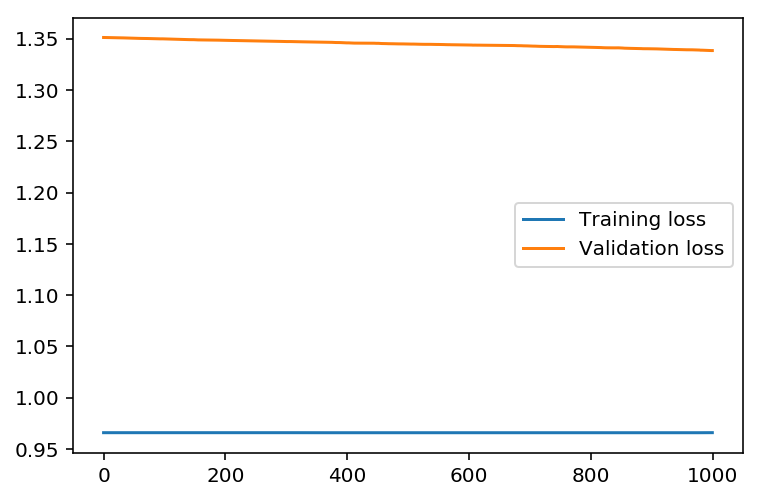

In [13]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()

## Check out your predictions

Here, use the test data to view how well your network is modeling the data. If something is completely wrong here, make sure each step in your network is implemented correctly.

/home/vcsalvador/miniconda3/envs/dlnd/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.


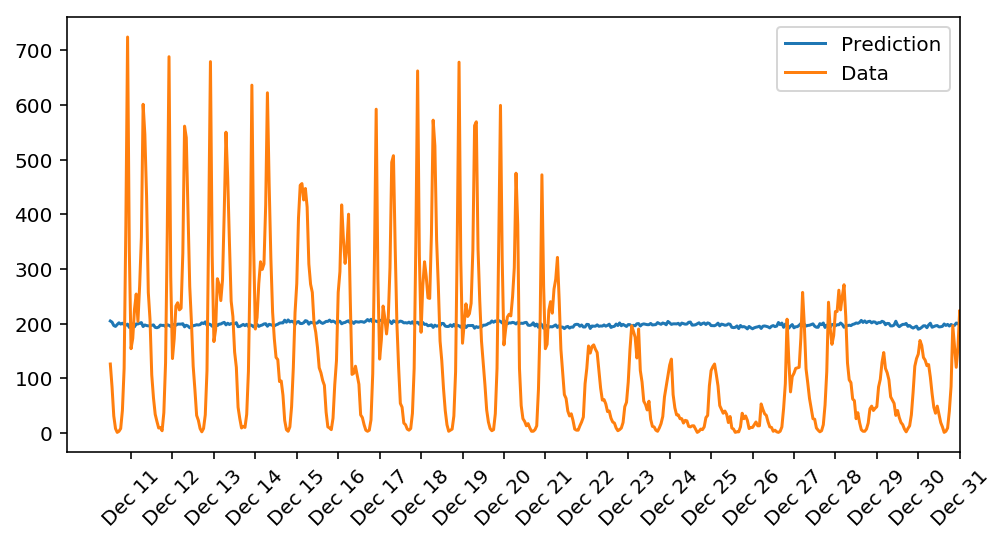

In [14]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features).T*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

## OPTIONAL: Thinking about your results(this question will not be evaluated in the rubric).
 
Answer these questions about your results. How well does the model predict the data? Where does it fail? Why does it fail where it does?

> **Note:** You can edit the text in this cell by double clicking on it. When you want to render the text, press control + enter

#### Your answer below